# Afriat

In [1]:
ood_seed = 10

In [2]:
num_ood = 1  # not functioning

In [3]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [6]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0.0', 'Pericentral', 'Control'),
  ('0.0', 'Periportal', 'Control'),
  ('12.0', 'Pericentral', 'Infected'),
  ('12.0', 'Pericentral', 'Uninfected'),
  ('12.0', 'Periportal', 'Infected'),
  ('12.0', 'Periportal', 'Uninfected'),
  ('2.0', 'Pericentral', 'Uninfected'),
  ('2.0', 'Periportal', 'Infected'),
  ('2.0', 'Periportal', 'Uninfected'),
  ('24.0', 'Pericentral', 'Infected'),
  ('24.0', 'Pericentral', 'Uninfected'),
  ('24.0', 'Periportal', 'Infected'),
  ('24.0', 'Periportal', 'Uninfected'),
  ('30.0', 'Pericentral', 'Infected'),
  ('30.0', 'Pericentral', 'Uninfected'),
  ('30.0', 'Periportal', 'Infected'),
  ('30.0', 'Periportal', 'Uninfected'),
  ('36.0', 'Pericentral', 'Infected'),
  ('36.0', 'Pericentral', 'Uninfected'),
  ('36.0', 'Periportal', 'Infected'),
  ('36.0', 'Periportal', 'Uninfected')],
 21)

In [7]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

('24.0', 'Pericentral', 'Uninfected')

Removed datapoint: 1117


In [8]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "status_control",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "time_cat",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "zone",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [9]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates = True,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=None,
    model_level_metrics_helper_covariates=None
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: 9wc52x2v
Name: grievous-tauntaun-215
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/9wc52x2v
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240504_225404-9wc52x2v/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `training` set. Number of elements in each group: 2551,3293,8505
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `training` set. Number of elements in each group: 2551,2566,1709,2559,1640,3324
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `training` set. Number of elements in each group: 3577,10772
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `validation` set. Number of elements in each group: 654,816,2117
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `validation` set. Number of elements in each group: 654,636,399,614,409,875
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `validation` set. Number of elements in each group: 890,2697
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:12<2:03:39, 12.39s/it]

Epoch 1/600:   0%|          | 1/600 [00:12<2:03:39, 12.39s/it, v_num=2v_1, total_loss_train=3.74e+3, kl_local_train=54.8]

Epoch 2/600:   0%|          | 1/600 [00:12<2:03:39, 12.39s/it, v_num=2v_1, total_loss_train=3.74e+3, kl_local_train=54.8]

Epoch 2/600:   0%|          | 2/600 [00:23<1:56:37, 11.70s/it, v_num=2v_1, total_loss_train=3.74e+3, kl_local_train=54.8]

Epoch 2/600:   0%|          | 2/600 [00:23<1:56:37, 11.70s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=84]  

Epoch 3/600:   0%|          | 2/600 [00:23<1:56:37, 11.70s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=84]

Epoch 3/600:   0%|          | 3/600 [00:34<1:54:20, 11.49s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=84]

Epoch 3/600:   0%|          | 3/600 [00:34<1:54:20, 11.49s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=85.7]

Epoch 4/600:   0%|          | 3/600 [00:34<1:54:20, 11.49s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=85.7]

Epoch 4/600:   1%|          | 4/600 [00:46<1:53:27, 11.42s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=85.7]

Epoch 4/600:   1%|          | 4/600 [00:46<1:53:27, 11.42s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=81.8]

Epoch 5/600:   1%|          | 4/600 [00:46<1:53:27, 11.42s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=81.8]

Epoch 5/600:   1%|          | 5/600 [00:57<1:53:16, 11.42s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=81.8]

Epoch 5/600:   1%|          | 5/600 [00:57<1:53:16, 11.42s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=74.3]

Epoch 6/600:   1%|          | 5/600 [00:57<1:53:16, 11.42s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=74.3]

Epoch 6/600:   1%|          | 6/600 [01:09<1:53:23, 11.45s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=74.3]

Epoch 6/600:   1%|          | 6/600 [01:09<1:53:23, 11.45s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=63]  

Epoch 7/600:   1%|          | 6/600 [01:09<1:53:23, 11.45s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=63]

Epoch 7/600:   1%|          | 7/600 [01:20<1:53:36, 11.50s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=63]

Epoch 7/600:   1%|          | 7/600 [01:20<1:53:36, 11.50s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=48.5]

Epoch 8/600:   1%|          | 7/600 [01:20<1:53:36, 11.50s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=48.5]

Epoch 8/600:   1%|▏         | 8/600 [01:32<1:53:45, 11.53s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=48.5]

Epoch 8/600:   1%|▏         | 8/600 [01:32<1:53:45, 11.53s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=30]  

Epoch 9/600:   1%|▏         | 8/600 [01:32<1:53:45, 11.53s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=30]

Epoch 9/600:   2%|▏         | 9/600 [01:43<1:53:15, 11.50s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=30]

Epoch 9/600:   2%|▏         | 9/600 [01:43<1:53:15, 11.50s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=43.3]

Epoch 10/600:   2%|▏         | 9/600 [01:43<1:53:15, 11.50s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=43.3]

Epoch 10/600:   2%|▏         | 10/600 [01:55<1:52:25, 11.43s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=43.3]

Epoch 10/600:   2%|▏         | 10/600 [01:55<1:52:25, 11.43s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=102] 

Epoch 11/600:   2%|▏         | 10/600 [01:55<1:52:25, 11.43s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=102]

Epoch 11/600:   2%|▏         | 11/600 [02:06<1:51:35, 11.37s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=102]

Epoch 11/600:   2%|▏         | 11/600 [02:06<1:51:35, 11.37s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=210]

Epoch 12/600:   2%|▏         | 11/600 [02:06<1:51:35, 11.37s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=210]

Epoch 12/600:   2%|▏         | 12/600 [02:17<1:50:56, 11.32s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=210]

Epoch 12/600:   2%|▏         | 12/600 [02:17<1:50:56, 11.32s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=294]

Epoch 13/600:   2%|▏         | 12/600 [02:17<1:50:56, 11.32s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=294]

Epoch 13/600:   2%|▏         | 13/600 [02:28<1:50:26, 11.29s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=294]

Epoch 13/600:   2%|▏         | 13/600 [02:28<1:50:26, 11.29s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=308]

Epoch 14/600:   2%|▏         | 13/600 [02:28<1:50:26, 11.29s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=308]

Epoch 14/600:   2%|▏         | 14/600 [02:39<1:50:04, 11.27s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=308]

Epoch 14/600:   2%|▏         | 14/600 [02:39<1:50:04, 11.27s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=278]

Epoch 15/600:   2%|▏         | 14/600 [02:39<1:50:04, 11.27s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=278]

Epoch 15/600:   2%|▎         | 15/600 [02:51<1:49:49, 11.26s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=278]

Epoch 15/600:   2%|▎         | 15/600 [02:51<1:49:49, 11.26s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=217]

Epoch 16/600:   2%|▎         | 15/600 [02:51<1:49:49, 11.26s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=217]

Epoch 16/600:   3%|▎         | 16/600 [03:02<1:49:31, 11.25s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=217]

Epoch 16/600:   3%|▎         | 16/600 [03:02<1:49:31, 11.25s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=187]

Epoch 17/600:   3%|▎         | 16/600 [03:02<1:49:31, 11.25s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=187]

Epoch 17/600:   3%|▎         | 17/600 [03:13<1:49:22, 11.26s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=187]

Epoch 17/600:   3%|▎         | 17/600 [03:13<1:49:22, 11.26s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=174]

Epoch 18/600:   3%|▎         | 17/600 [03:13<1:49:22, 11.26s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=174]

Epoch 18/600:   3%|▎         | 18/600 [03:24<1:49:09, 11.25s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=174]

Epoch 18/600:   3%|▎         | 18/600 [03:24<1:49:09, 11.25s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=167]

Epoch 19/600:   3%|▎         | 18/600 [03:24<1:49:09, 11.25s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=167]

Epoch 19/600:   3%|▎         | 19/600 [03:36<1:48:59, 11.26s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=167]

Epoch 19/600:   3%|▎         | 19/600 [03:36<1:48:59, 11.26s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=178]

Epoch 20/600:   3%|▎         | 19/600 [03:36<1:48:59, 11.26s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=178]

Epoch 20/600:   3%|▎         | 20/600 [03:47<1:49:33, 11.33s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=178]

Epoch 20/600:   3%|▎         | 20/600 [03:47<1:49:33, 11.33s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=195]

Epoch 21/600:   3%|▎         | 20/600 [03:47<1:49:33, 11.33s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=195]

Epoch 21/600:   4%|▎         | 21/600 [03:58<1:49:08, 11.31s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=195]

Epoch 21/600:   4%|▎         | 21/600 [03:58<1:49:08, 11.31s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=190]

Epoch 22/600:   4%|▎         | 21/600 [03:58<1:49:08, 11.31s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=190]

Epoch 22/600:   4%|▎         | 22/600 [04:10<1:48:30, 11.26s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=190]

Epoch 22/600:   4%|▎         | 22/600 [04:10<1:48:30, 11.26s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=202]

Epoch 23/600:   4%|▎         | 22/600 [04:10<1:48:30, 11.26s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=202]

Epoch 23/600:   4%|▍         | 23/600 [04:21<1:48:06, 11.24s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=202]

Epoch 23/600:   4%|▍         | 23/600 [04:21<1:48:06, 11.24s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=209]

Epoch 24/600:   4%|▍         | 23/600 [04:21<1:48:06, 11.24s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=209]

Epoch 24/600:   4%|▍         | 24/600 [04:32<1:48:03, 11.26s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=209]

Epoch 24/600:   4%|▍         | 24/600 [04:32<1:48:03, 11.26s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=209]

Epoch 25/600:   4%|▍         | 24/600 [04:32<1:48:03, 11.26s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=209]

Epoch 25/600:   4%|▍         | 25/600 [04:43<1:48:03, 11.28s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=209]

Epoch 25/600:   4%|▍         | 25/600 [04:43<1:48:03, 11.28s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=209]

Epoch 26/600:   4%|▍         | 25/600 [04:43<1:48:03, 11.28s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=209]

Epoch 26/600:   4%|▍         | 26/600 [04:55<1:47:56, 11.28s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=209]

Epoch 26/600:   4%|▍         | 26/600 [04:55<1:47:56, 11.28s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=206]

Epoch 27/600:   4%|▍         | 26/600 [04:55<1:47:56, 11.28s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=206]

Epoch 27/600:   4%|▍         | 27/600 [05:06<1:47:59, 11.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=206]

Epoch 27/600:   4%|▍         | 27/600 [05:06<1:47:59, 11.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=202]

Epoch 28/600:   4%|▍         | 27/600 [05:06<1:47:59, 11.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=202]

Epoch 28/600:   5%|▍         | 28/600 [05:17<1:47:46, 11.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=202]

Epoch 28/600:   5%|▍         | 28/600 [05:17<1:47:46, 11.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=199]

Epoch 29/600:   5%|▍         | 28/600 [05:17<1:47:46, 11.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=199]

Epoch 29/600:   5%|▍         | 29/600 [05:29<1:47:37, 11.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=199]

Epoch 29/600:   5%|▍         | 29/600 [05:29<1:47:37, 11.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=192]

Epoch 30/600:   5%|▍         | 29/600 [05:29<1:47:37, 11.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=192]

Epoch 30/600:   5%|▌         | 30/600 [05:41<1:50:12, 11.60s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=192]

Epoch 30/600:   5%|▌         | 30/600 [05:41<1:50:12, 11.60s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=193]

Epoch 31/600:   5%|▌         | 30/600 [05:41<1:50:12, 11.60s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=193]

Epoch 31/600:   5%|▌         | 31/600 [05:53<1:52:35, 11.87s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=193]

Epoch 31/600:   5%|▌         | 31/600 [05:53<1:52:35, 11.87s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=186]

Epoch 32/600:   5%|▌         | 31/600 [05:53<1:52:35, 11.87s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=186]

Epoch 32/600:   5%|▌         | 32/600 [06:06<1:54:16, 12.07s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=186]

Epoch 32/600:   5%|▌         | 32/600 [06:06<1:54:16, 12.07s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=188]

Epoch 33/600:   5%|▌         | 32/600 [06:06<1:54:16, 12.07s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=188]

Epoch 33/600:   6%|▌         | 33/600 [06:19<1:55:47, 12.25s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=188]

Epoch 33/600:   6%|▌         | 33/600 [06:19<1:55:47, 12.25s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=186]

Epoch 34/600:   6%|▌         | 33/600 [06:19<1:55:47, 12.25s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=186]

Epoch 34/600:   6%|▌         | 34/600 [06:31<1:56:35, 12.36s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=186]

Epoch 34/600:   6%|▌         | 34/600 [06:31<1:56:35, 12.36s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=185]

Epoch 35/600:   6%|▌         | 34/600 [06:31<1:56:35, 12.36s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=185]

Epoch 35/600:   6%|▌         | 35/600 [06:44<1:56:37, 12.39s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=185]

Epoch 35/600:   6%|▌         | 35/600 [06:44<1:56:37, 12.39s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=190]

Epoch 36/600:   6%|▌         | 35/600 [06:44<1:56:37, 12.39s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=190]

Epoch 36/600:   6%|▌         | 36/600 [06:56<1:57:13, 12.47s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=190]

Epoch 36/600:   6%|▌         | 36/600 [06:56<1:57:13, 12.47s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=184]

Epoch 37/600:   6%|▌         | 36/600 [06:56<1:57:13, 12.47s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=184]

Epoch 37/600:   6%|▌         | 37/600 [07:09<1:56:56, 12.46s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=184]

Epoch 37/600:   6%|▌         | 37/600 [07:09<1:56:56, 12.46s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=181]

Epoch 38/600:   6%|▌         | 37/600 [07:09<1:56:56, 12.46s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=181]

Epoch 38/600:   6%|▋         | 38/600 [07:21<1:56:51, 12.48s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=181]

Epoch 38/600:   6%|▋         | 38/600 [07:21<1:56:51, 12.48s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=179]

Epoch 39/600:   6%|▋         | 38/600 [07:21<1:56:51, 12.48s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=179]

Epoch 39/600:   6%|▋         | 39/600 [07:34<1:56:30, 12.46s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=179]

Epoch 39/600:   6%|▋         | 39/600 [07:34<1:56:30, 12.46s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=178]

Epoch 40/600:   6%|▋         | 39/600 [07:34<1:56:30, 12.46s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=178]

Epoch 40/600:   7%|▋         | 40/600 [07:46<1:55:49, 12.41s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=178]

Epoch 40/600:   7%|▋         | 40/600 [07:46<1:55:49, 12.41s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=178]

Epoch 41/600:   7%|▋         | 40/600 [07:46<1:55:49, 12.41s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=178]

Epoch 41/600:   7%|▋         | 41/600 [07:59<1:55:51, 12.44s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=178]

Epoch 41/600:   7%|▋         | 41/600 [07:59<1:55:51, 12.44s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=178]

Epoch 42/600:   7%|▋         | 41/600 [07:59<1:55:51, 12.44s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=178]

Epoch 42/600:   7%|▋         | 42/600 [08:11<1:56:28, 12.52s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=178]

Epoch 42/600:   7%|▋         | 42/600 [08:11<1:56:28, 12.52s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=183]

Epoch 43/600:   7%|▋         | 42/600 [08:11<1:56:28, 12.52s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=183]

Epoch 43/600:   7%|▋         | 43/600 [08:24<1:57:11, 12.62s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=183]

Epoch 43/600:   7%|▋         | 43/600 [08:24<1:57:11, 12.62s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=183]

Epoch 44/600:   7%|▋         | 43/600 [08:24<1:57:11, 12.62s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=183]

Epoch 44/600:   7%|▋         | 44/600 [08:37<1:56:25, 12.56s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=183]

Epoch 44/600:   7%|▋         | 44/600 [08:37<1:56:25, 12.56s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=184]

Epoch 45/600:   7%|▋         | 44/600 [08:37<1:56:25, 12.56s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=184]

Epoch 45/600:   8%|▊         | 45/600 [08:49<1:55:21, 12.47s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=184]

Epoch 45/600:   8%|▊         | 45/600 [08:49<1:55:21, 12.47s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=185]

Epoch 46/600:   8%|▊         | 45/600 [08:49<1:55:21, 12.47s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=185]

Epoch 46/600:   8%|▊         | 46/600 [09:01<1:54:53, 12.44s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=185]

Epoch 46/600:   8%|▊         | 46/600 [09:01<1:54:53, 12.44s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=182]

Epoch 47/600:   8%|▊         | 46/600 [09:01<1:54:53, 12.44s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=182]

Epoch 47/600:   8%|▊         | 47/600 [09:14<1:54:31, 12.43s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=182]

Epoch 47/600:   8%|▊         | 47/600 [09:14<1:54:31, 12.43s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=183]

Epoch 48/600:   8%|▊         | 47/600 [09:14<1:54:31, 12.43s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=183]

Epoch 48/600:   8%|▊         | 48/600 [09:26<1:54:25, 12.44s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=183]

Epoch 48/600:   8%|▊         | 48/600 [09:26<1:54:25, 12.44s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=182]

Epoch 49/600:   8%|▊         | 48/600 [09:26<1:54:25, 12.44s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=182]

Epoch 49/600:   8%|▊         | 49/600 [09:38<1:53:57, 12.41s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=182]

Epoch 49/600:   8%|▊         | 49/600 [09:38<1:53:57, 12.41s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=184]

Epoch 50/600:   8%|▊         | 49/600 [09:38<1:53:57, 12.41s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=184]

Epoch 50/600:   8%|▊         | 50/600 [09:51<1:54:25, 12.48s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=184]

Epoch 50/600:   8%|▊         | 50/600 [09:51<1:54:25, 12.48s/it, v_num=2v_1, total_loss_train=3.28e+3, kl_local_train=183]

Epoch 51/600:   8%|▊         | 50/600 [09:51<1:54:25, 12.48s/it, v_num=2v_1, total_loss_train=3.28e+3, kl_local_train=183]

Epoch 51/600:   8%|▊         | 51/600 [10:03<1:54:05, 12.47s/it, v_num=2v_1, total_loss_train=3.28e+3, kl_local_train=183]

Epoch 51/600:   8%|▊         | 51/600 [10:03<1:54:05, 12.47s/it, v_num=2v_1, total_loss_train=3.28e+3, kl_local_train=178]

Epoch 52/600:   8%|▊         | 51/600 [10:03<1:54:05, 12.47s/it, v_num=2v_1, total_loss_train=3.28e+3, kl_local_train=178]

Epoch 52/600:   9%|▊         | 52/600 [10:16<1:53:24, 12.42s/it, v_num=2v_1, total_loss_train=3.28e+3, kl_local_train=178]

Epoch 52/600:   9%|▊         | 52/600 [10:16<1:53:24, 12.42s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=172]

Epoch 53/600:   9%|▊         | 52/600 [10:16<1:53:24, 12.42s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=172]

Epoch 53/600:   9%|▉         | 53/600 [10:28<1:53:33, 12.46s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=172]

Epoch 53/600:   9%|▉         | 53/600 [10:28<1:53:33, 12.46s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 54/600:   9%|▉         | 53/600 [10:28<1:53:33, 12.46s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 54/600:   9%|▉         | 54/600 [10:41<1:53:25, 12.46s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 54/600:   9%|▉         | 54/600 [10:41<1:53:25, 12.46s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 55/600:   9%|▉         | 54/600 [10:41<1:53:25, 12.46s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 55/600:   9%|▉         | 55/600 [10:53<1:53:06, 12.45s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 55/600:   9%|▉         | 55/600 [10:53<1:53:06, 12.45s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 56/600:   9%|▉         | 55/600 [10:53<1:53:06, 12.45s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 56/600:   9%|▉         | 56/600 [11:05<1:52:07, 12.37s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 56/600:   9%|▉         | 56/600 [11:05<1:52:07, 12.37s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 57/600:   9%|▉         | 56/600 [11:05<1:52:07, 12.37s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 57/600:  10%|▉         | 57/600 [11:18<1:51:48, 12.35s/it, v_num=2v_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 57/600:  10%|▉         | 57/600 [11:18<1:51:48, 12.35s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=168]

Epoch 58/600:  10%|▉         | 57/600 [11:18<1:51:48, 12.35s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=168]

Epoch 58/600:  10%|▉         | 58/600 [11:30<1:51:41, 12.37s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=168]

Epoch 58/600:  10%|▉         | 58/600 [11:30<1:51:41, 12.37s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=165]

Epoch 59/600:  10%|▉         | 58/600 [11:30<1:51:41, 12.37s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=165]

Epoch 59/600:  10%|▉         | 59/600 [11:43<1:51:42, 12.39s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=165]

Epoch 59/600:  10%|▉         | 59/600 [11:43<1:51:42, 12.39s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=167]

Epoch 60/600:  10%|▉         | 59/600 [11:43<1:51:42, 12.39s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=167]

Epoch 60/600:  10%|█         | 60/600 [11:55<1:51:35, 12.40s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=167]

Epoch 60/600:  10%|█         | 60/600 [11:55<1:51:35, 12.40s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=168]

Epoch 61/600:  10%|█         | 60/600 [11:55<1:51:35, 12.40s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=168]

Epoch 61/600:  10%|█         | 61/600 [12:07<1:51:34, 12.42s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=168]

Epoch 61/600:  10%|█         | 61/600 [12:07<1:51:34, 12.42s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=166]

Epoch 62/600:  10%|█         | 61/600 [12:07<1:51:34, 12.42s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=166]

Epoch 62/600:  10%|█         | 62/600 [12:20<1:51:34, 12.44s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=166]

Epoch 62/600:  10%|█         | 62/600 [12:20<1:51:34, 12.44s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=162]

Epoch 63/600:  10%|█         | 62/600 [12:20<1:51:34, 12.44s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=162]

Epoch 63/600:  10%|█         | 63/600 [12:32<1:51:31, 12.46s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=162]

Epoch 63/600:  10%|█         | 63/600 [12:32<1:51:31, 12.46s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=160]

Epoch 64/600:  10%|█         | 63/600 [12:32<1:51:31, 12.46s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=160]

Epoch 64/600:  11%|█         | 64/600 [12:45<1:51:08, 12.44s/it, v_num=2v_1, total_loss_train=3.26e+3, kl_local_train=160]

Epoch 64/600:  11%|█         | 64/600 [12:45<1:51:08, 12.44s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=159]

Epoch 65/600:  11%|█         | 64/600 [12:45<1:51:08, 12.44s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=159]

Epoch 65/600:  11%|█         | 65/600 [12:57<1:50:30, 12.39s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=159]

Epoch 65/600:  11%|█         | 65/600 [12:57<1:50:30, 12.39s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=159]

Epoch 66/600:  11%|█         | 65/600 [12:57<1:50:30, 12.39s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=159]

Epoch 66/600:  11%|█         | 66/600 [13:10<1:50:26, 12.41s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=159]

Epoch 66/600:  11%|█         | 66/600 [13:10<1:50:26, 12.41s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=159]

Epoch 67/600:  11%|█         | 66/600 [13:10<1:50:26, 12.41s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=159]

Epoch 67/600:  11%|█         | 67/600 [13:22<1:50:18, 12.42s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=159]

Epoch 67/600:  11%|█         | 67/600 [13:22<1:50:18, 12.42s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=158]

Epoch 68/600:  11%|█         | 67/600 [13:22<1:50:18, 12.42s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=158]

Epoch 68/600:  11%|█▏        | 68/600 [13:34<1:49:54, 12.40s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=158]

Epoch 68/600:  11%|█▏        | 68/600 [13:34<1:49:54, 12.40s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=160]

Epoch 69/600:  11%|█▏        | 68/600 [13:34<1:49:54, 12.40s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=160]

Epoch 69/600:  12%|█▏        | 69/600 [13:47<1:49:25, 12.36s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=160]

Epoch 69/600:  12%|█▏        | 69/600 [13:47<1:49:25, 12.36s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=158]

Epoch 70/600:  12%|█▏        | 69/600 [13:47<1:49:25, 12.36s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=158]

Epoch 70/600:  12%|█▏        | 70/600 [13:59<1:49:21, 12.38s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=158]

Epoch 70/600:  12%|█▏        | 70/600 [13:59<1:49:21, 12.38s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=155]

Epoch 71/600:  12%|█▏        | 70/600 [13:59<1:49:21, 12.38s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=155]

Epoch 71/600:  12%|█▏        | 71/600 [14:11<1:49:20, 12.40s/it, v_num=2v_1, total_loss_train=3.25e+3, kl_local_train=155]

Epoch 71/600:  12%|█▏        | 71/600 [14:11<1:49:20, 12.40s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=153]

Epoch 72/600:  12%|█▏        | 71/600 [14:12<1:49:20, 12.40s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=153]

Epoch 72/600:  12%|█▏        | 72/600 [14:24<1:49:25, 12.43s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=153]

Epoch 72/600:  12%|█▏        | 72/600 [14:24<1:49:25, 12.43s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=152]

Epoch 73/600:  12%|█▏        | 72/600 [14:24<1:49:25, 12.43s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=152]

Epoch 73/600:  12%|█▏        | 73/600 [14:37<1:49:25, 12.46s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=152]

Epoch 73/600:  12%|█▏        | 73/600 [14:37<1:49:25, 12.46s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=152]

Epoch 74/600:  12%|█▏        | 73/600 [14:37<1:49:25, 12.46s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=152]

Epoch 74/600:  12%|█▏        | 74/600 [14:49<1:49:13, 12.46s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=152]

Epoch 74/600:  12%|█▏        | 74/600 [14:49<1:49:13, 12.46s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=151]

Epoch 75/600:  12%|█▏        | 74/600 [14:49<1:49:13, 12.46s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=151]

Epoch 75/600:  12%|█▎        | 75/600 [15:01<1:48:54, 12.45s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=151]

Epoch 75/600:  12%|█▎        | 75/600 [15:01<1:48:54, 12.45s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=152]

Epoch 76/600:  12%|█▎        | 75/600 [15:01<1:48:54, 12.45s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=152]

Epoch 76/600:  13%|█▎        | 76/600 [15:14<1:48:18, 12.40s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=152]

Epoch 76/600:  13%|█▎        | 76/600 [15:14<1:48:18, 12.40s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=151]

Epoch 77/600:  13%|█▎        | 76/600 [15:14<1:48:18, 12.40s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=151]

Epoch 77/600:  13%|█▎        | 77/600 [15:26<1:47:59, 12.39s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=151]

Epoch 77/600:  13%|█▎        | 77/600 [15:26<1:47:59, 12.39s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=149]

Epoch 78/600:  13%|█▎        | 77/600 [15:26<1:47:59, 12.39s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=149]

Epoch 78/600:  13%|█▎        | 78/600 [15:38<1:47:44, 12.38s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=149]

Epoch 78/600:  13%|█▎        | 78/600 [15:38<1:47:44, 12.38s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=148]

Epoch 79/600:  13%|█▎        | 78/600 [15:38<1:47:44, 12.38s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=148]

Epoch 79/600:  13%|█▎        | 79/600 [15:51<1:47:06, 12.33s/it, v_num=2v_1, total_loss_train=3.24e+3, kl_local_train=148]

Epoch 79/600:  13%|█▎        | 79/600 [15:51<1:47:06, 12.33s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=149]

Epoch 80/600:  13%|█▎        | 79/600 [15:51<1:47:06, 12.33s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=149]

Epoch 80/600:  13%|█▎        | 80/600 [16:03<1:47:32, 12.41s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=149]

Epoch 80/600:  13%|█▎        | 80/600 [16:03<1:47:32, 12.41s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=146]

Epoch 81/600:  13%|█▎        | 80/600 [16:03<1:47:32, 12.41s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=146]

Epoch 81/600:  14%|█▎        | 81/600 [16:16<1:47:11, 12.39s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=146]

Epoch 81/600:  14%|█▎        | 81/600 [16:16<1:47:11, 12.39s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=146]

Epoch 82/600:  14%|█▎        | 81/600 [16:16<1:47:11, 12.39s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=146]

Epoch 82/600:  14%|█▎        | 82/600 [16:28<1:46:52, 12.38s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=146]

Epoch 82/600:  14%|█▎        | 82/600 [16:28<1:46:52, 12.38s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=146]

Epoch 83/600:  14%|█▎        | 82/600 [16:28<1:46:52, 12.38s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=146]

Epoch 83/600:  14%|█▍        | 83/600 [16:40<1:46:28, 12.36s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=146]

Epoch 83/600:  14%|█▍        | 83/600 [16:40<1:46:28, 12.36s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=146]

Epoch 84/600:  14%|█▍        | 83/600 [16:40<1:46:28, 12.36s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=146]

Epoch 84/600:  14%|█▍        | 84/600 [16:52<1:45:56, 12.32s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=146]

Epoch 84/600:  14%|█▍        | 84/600 [16:52<1:45:56, 12.32s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=147]

Epoch 85/600:  14%|█▍        | 84/600 [16:52<1:45:56, 12.32s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=147]

Epoch 85/600:  14%|█▍        | 85/600 [17:05<1:45:41, 12.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=147]

Epoch 85/600:  14%|█▍        | 85/600 [17:05<1:45:41, 12.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=145]

Epoch 86/600:  14%|█▍        | 85/600 [17:05<1:45:41, 12.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=145]

Epoch 86/600:  14%|█▍        | 86/600 [17:17<1:45:25, 12.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=145]

Epoch 86/600:  14%|█▍        | 86/600 [17:17<1:45:25, 12.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=142]

Epoch 87/600:  14%|█▍        | 86/600 [17:17<1:45:25, 12.31s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=142]

Epoch 87/600:  14%|█▍        | 87/600 [17:30<1:45:41, 12.36s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=142]

Epoch 87/600:  14%|█▍        | 87/600 [17:30<1:45:41, 12.36s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=141]

Epoch 88/600:  14%|█▍        | 87/600 [17:30<1:45:41, 12.36s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=141]

Epoch 88/600:  15%|█▍        | 88/600 [17:42<1:45:48, 12.40s/it, v_num=2v_1, total_loss_train=3.23e+3, kl_local_train=141]

Epoch 88/600:  15%|█▍        | 88/600 [17:42<1:45:48, 12.40s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=140]

Epoch 89/600:  15%|█▍        | 88/600 [17:42<1:45:48, 12.40s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=140]

Epoch 89/600:  15%|█▍        | 89/600 [17:54<1:45:40, 12.41s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=140]

Epoch 89/600:  15%|█▍        | 89/600 [17:54<1:45:40, 12.41s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=139]

Epoch 90/600:  15%|█▍        | 89/600 [17:54<1:45:40, 12.41s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=139]

Epoch 90/600:  15%|█▌        | 90/600 [18:07<1:45:11, 12.37s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=139]

Epoch 90/600:  15%|█▌        | 90/600 [18:07<1:45:11, 12.37s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=140]

Epoch 91/600:  15%|█▌        | 90/600 [18:07<1:45:11, 12.37s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=140]

Epoch 91/600:  15%|█▌        | 91/600 [18:19<1:44:55, 12.37s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=140]

Epoch 91/600:  15%|█▌        | 91/600 [18:19<1:44:55, 12.37s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=138]

Epoch 92/600:  15%|█▌        | 91/600 [18:19<1:44:55, 12.37s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=138]

Epoch 92/600:  15%|█▌        | 92/600 [18:32<1:44:57, 12.40s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=138]

Epoch 92/600:  15%|█▌        | 92/600 [18:32<1:44:57, 12.40s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=137]

Epoch 93/600:  15%|█▌        | 92/600 [18:32<1:44:57, 12.40s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=137]

Epoch 93/600:  16%|█▌        | 93/600 [18:44<1:44:23, 12.35s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=137]

Epoch 93/600:  16%|█▌        | 93/600 [18:44<1:44:23, 12.35s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=138]

Epoch 94/600:  16%|█▌        | 93/600 [18:44<1:44:23, 12.35s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=138]

Epoch 94/600:  16%|█▌        | 94/600 [18:56<1:44:24, 12.38s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=138]

Epoch 94/600:  16%|█▌        | 94/600 [18:56<1:44:24, 12.38s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=138]

Epoch 95/600:  16%|█▌        | 94/600 [18:56<1:44:24, 12.38s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=138]

Epoch 95/600:  16%|█▌        | 95/600 [19:09<1:44:13, 12.38s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=138]

Epoch 95/600:  16%|█▌        | 95/600 [19:09<1:44:13, 12.38s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=138]

Epoch 96/600:  16%|█▌        | 95/600 [19:09<1:44:13, 12.38s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=138]

Epoch 96/600:  16%|█▌        | 96/600 [19:21<1:43:36, 12.33s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=138]

Epoch 96/600:  16%|█▌        | 96/600 [19:21<1:43:36, 12.33s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=137]

Epoch 97/600:  16%|█▌        | 96/600 [19:21<1:43:36, 12.33s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=137]

Epoch 97/600:  16%|█▌        | 97/600 [19:33<1:43:57, 12.40s/it, v_num=2v_1, total_loss_train=3.22e+3, kl_local_train=137]

Epoch 97/600:  16%|█▌        | 97/600 [19:33<1:43:57, 12.40s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=136]

Epoch 98/600:  16%|█▌        | 97/600 [19:33<1:43:57, 12.40s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=136]

Epoch 98/600:  16%|█▋        | 98/600 [19:46<1:43:56, 12.42s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=136]

Epoch 98/600:  16%|█▋        | 98/600 [19:46<1:43:56, 12.42s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=135]

Epoch 99/600:  16%|█▋        | 98/600 [19:46<1:43:56, 12.42s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=135]

Epoch 99/600:  16%|█▋        | 99/600 [19:59<1:44:23, 12.50s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=135]

Epoch 99/600:  16%|█▋        | 99/600 [19:59<1:44:23, 12.50s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=135]

Epoch 100/600:  16%|█▋        | 99/600 [19:59<1:44:23, 12.50s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=135]

Epoch 100/600:  17%|█▋        | 100/600 [20:11<1:44:30, 12.54s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=135]

Epoch 100/600:  17%|█▋        | 100/600 [20:11<1:44:30, 12.54s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=135]

Epoch 101/600:  17%|█▋        | 100/600 [20:11<1:44:30, 12.54s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=135]

Epoch 101/600:  17%|█▋        | 101/600 [20:24<1:44:16, 12.54s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=135]

Epoch 101/600:  17%|█▋        | 101/600 [20:24<1:44:16, 12.54s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=132]

Epoch 102/600:  17%|█▋        | 101/600 [20:24<1:44:16, 12.54s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=132]

Epoch 102/600:  17%|█▋        | 102/600 [20:36<1:43:13, 12.44s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=132]

Epoch 102/600:  17%|█▋        | 102/600 [20:36<1:43:13, 12.44s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=132]

Epoch 103/600:  17%|█▋        | 102/600 [20:36<1:43:13, 12.44s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=132]

Epoch 103/600:  17%|█▋        | 103/600 [20:48<1:43:03, 12.44s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=132]

Epoch 103/600:  17%|█▋        | 103/600 [20:48<1:43:03, 12.44s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=134]

Epoch 104/600:  17%|█▋        | 103/600 [20:48<1:43:03, 12.44s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=134]

Epoch 104/600:  17%|█▋        | 104/600 [21:01<1:42:58, 12.46s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=134]

Epoch 104/600:  17%|█▋        | 104/600 [21:01<1:42:58, 12.46s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=132]

Epoch 105/600:  17%|█▋        | 104/600 [21:01<1:42:58, 12.46s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=132]

Epoch 105/600:  18%|█▊        | 105/600 [21:13<1:42:50, 12.47s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=132]

Epoch 105/600:  18%|█▊        | 105/600 [21:13<1:42:50, 12.47s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=130]

Epoch 106/600:  18%|█▊        | 105/600 [21:13<1:42:50, 12.47s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=130]

Epoch 106/600:  18%|█▊        | 106/600 [21:26<1:42:39, 12.47s/it, v_num=2v_1, total_loss_train=3.21e+3, kl_local_train=130]

Epoch 106/600:  18%|█▊        | 106/600 [21:26<1:42:39, 12.47s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=131] 

Epoch 107/600:  18%|█▊        | 106/600 [21:26<1:42:39, 12.47s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=131]

Epoch 107/600:  18%|█▊        | 107/600 [21:38<1:42:31, 12.48s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=131]

Epoch 107/600:  18%|█▊        | 107/600 [21:38<1:42:31, 12.48s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=132]

Epoch 108/600:  18%|█▊        | 107/600 [21:38<1:42:31, 12.48s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=132]

Epoch 108/600:  18%|█▊        | 108/600 [21:51<1:42:17, 12.47s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=132]

Epoch 108/600:  18%|█▊        | 108/600 [21:51<1:42:17, 12.47s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=132]

Epoch 109/600:  18%|█▊        | 108/600 [21:51<1:42:17, 12.47s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=132]

Epoch 109/600:  18%|█▊        | 109/600 [22:03<1:42:09, 12.48s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=132]

Epoch 109/600:  18%|█▊        | 109/600 [22:03<1:42:09, 12.48s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=129]

Epoch 110/600:  18%|█▊        | 109/600 [22:03<1:42:09, 12.48s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=129]

Epoch 110/600:  18%|█▊        | 110/600 [22:16<1:42:07, 12.50s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=129]

Epoch 110/600:  18%|█▊        | 110/600 [22:16<1:42:07, 12.50s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=130]

Epoch 111/600:  18%|█▊        | 110/600 [22:16<1:42:07, 12.50s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=130]

Epoch 111/600:  18%|█▊        | 111/600 [22:28<1:41:55, 12.51s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=130]

Epoch 111/600:  18%|█▊        | 111/600 [22:28<1:41:55, 12.51s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=129]

Epoch 112/600:  18%|█▊        | 111/600 [22:28<1:41:55, 12.51s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=129]

Epoch 112/600:  19%|█▊        | 112/600 [22:41<1:41:39, 12.50s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=129]

Epoch 112/600:  19%|█▊        | 112/600 [22:41<1:41:39, 12.50s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=129]

Epoch 113/600:  19%|█▊        | 112/600 [22:41<1:41:39, 12.50s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=129]

Epoch 113/600:  19%|█▉        | 113/600 [22:53<1:41:05, 12.45s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=129]

Epoch 113/600:  19%|█▉        | 113/600 [22:53<1:41:05, 12.45s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=128]

Epoch 114/600:  19%|█▉        | 113/600 [22:53<1:41:05, 12.45s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=128]

Epoch 114/600:  19%|█▉        | 114/600 [23:06<1:40:58, 12.47s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=128]

Epoch 114/600:  19%|█▉        | 114/600 [23:06<1:40:58, 12.47s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=126]

Epoch 115/600:  19%|█▉        | 114/600 [23:06<1:40:58, 12.47s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=126]

Epoch 115/600:  19%|█▉        | 115/600 [23:18<1:41:02, 12.50s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=126]

Epoch 115/600:  19%|█▉        | 115/600 [23:18<1:41:02, 12.50s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=127]

Epoch 116/600:  19%|█▉        | 115/600 [23:18<1:41:02, 12.50s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=127]

Epoch 116/600:  19%|█▉        | 116/600 [23:31<1:41:05, 12.53s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=127]

Epoch 116/600:  19%|█▉        | 116/600 [23:31<1:41:05, 12.53s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=128]

Epoch 117/600:  19%|█▉        | 116/600 [23:31<1:41:05, 12.53s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=128]

Epoch 117/600:  20%|█▉        | 117/600 [23:43<1:40:52, 12.53s/it, v_num=2v_1, total_loss_train=3.2e+3, kl_local_train=128]

Epoch 117/600:  20%|█▉        | 117/600 [23:43<1:40:52, 12.53s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=128]

Epoch 118/600:  20%|█▉        | 117/600 [23:43<1:40:52, 12.53s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=128]

Epoch 118/600:  20%|█▉        | 118/600 [23:56<1:40:33, 12.52s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=128]

Epoch 118/600:  20%|█▉        | 118/600 [23:56<1:40:33, 12.52s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=128]

Epoch 119/600:  20%|█▉        | 118/600 [23:56<1:40:33, 12.52s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=128]

Epoch 119/600:  20%|█▉        | 119/600 [24:08<1:40:14, 12.50s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=128]

Epoch 119/600:  20%|█▉        | 119/600 [24:08<1:40:14, 12.50s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 120/600:  20%|█▉        | 119/600 [24:08<1:40:14, 12.50s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 120/600:  20%|██        | 120/600 [24:21<1:39:28, 12.43s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 120/600:  20%|██        | 120/600 [24:21<1:39:28, 12.43s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 121/600:  20%|██        | 120/600 [24:21<1:39:28, 12.43s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 121/600:  20%|██        | 121/600 [24:33<1:39:50, 12.51s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 121/600:  20%|██        | 121/600 [24:33<1:39:50, 12.51s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=125]

Epoch 122/600:  20%|██        | 121/600 [24:33<1:39:50, 12.51s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=125]

Epoch 122/600:  20%|██        | 122/600 [24:46<1:38:55, 12.42s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=125]

Epoch 122/600:  20%|██        | 122/600 [24:46<1:38:55, 12.42s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 123/600:  20%|██        | 122/600 [24:46<1:38:55, 12.42s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 123/600:  20%|██        | 123/600 [24:58<1:39:12, 12.48s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 123/600:  20%|██        | 123/600 [24:58<1:39:12, 12.48s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 124/600:  20%|██        | 123/600 [24:58<1:39:12, 12.48s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 124/600:  21%|██        | 124/600 [25:11<1:40:18, 12.64s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 124/600:  21%|██        | 124/600 [25:11<1:40:18, 12.64s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=123]

Epoch 125/600:  21%|██        | 124/600 [25:11<1:40:18, 12.64s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=123]

Epoch 125/600:  21%|██        | 125/600 [25:24<1:39:55, 12.62s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=123]

Epoch 125/600:  21%|██        | 125/600 [25:24<1:39:55, 12.62s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=123]

Epoch 126/600:  21%|██        | 125/600 [25:24<1:39:55, 12.62s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=123]

Epoch 126/600:  21%|██        | 126/600 [25:36<1:39:21, 12.58s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=123]

Epoch 126/600:  21%|██        | 126/600 [25:36<1:39:21, 12.58s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=123]

Epoch 127/600:  21%|██        | 126/600 [25:36<1:39:21, 12.58s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=123]

Epoch 127/600:  21%|██        | 127/600 [25:49<1:38:38, 12.51s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=123]

Epoch 127/600:  21%|██        | 127/600 [25:49<1:38:38, 12.51s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 128/600:  21%|██        | 127/600 [25:49<1:38:38, 12.51s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 128/600:  21%|██▏       | 128/600 [26:01<1:38:01, 12.46s/it, v_num=2v_1, total_loss_train=3.19e+3, kl_local_train=124]

Epoch 128/600:  21%|██▏       | 128/600 [26:01<1:38:01, 12.46s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=124]

Epoch 129/600:  21%|██▏       | 128/600 [26:01<1:38:01, 12.46s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=124]

Epoch 129/600:  22%|██▏       | 129/600 [26:13<1:37:48, 12.46s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=124]

Epoch 129/600:  22%|██▏       | 129/600 [26:13<1:37:48, 12.46s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=124]

Epoch 130/600:  22%|██▏       | 129/600 [26:13<1:37:48, 12.46s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=124]

Epoch 130/600:  22%|██▏       | 130/600 [26:26<1:37:32, 12.45s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=124]

Epoch 130/600:  22%|██▏       | 130/600 [26:26<1:37:32, 12.45s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=122]

Epoch 131/600:  22%|██▏       | 130/600 [26:26<1:37:32, 12.45s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=122]

Epoch 131/600:  22%|██▏       | 131/600 [26:38<1:37:12, 12.44s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=122]

Epoch 131/600:  22%|██▏       | 131/600 [26:38<1:37:12, 12.44s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=121]

Epoch 132/600:  22%|██▏       | 131/600 [26:38<1:37:12, 12.44s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=121]

Epoch 132/600:  22%|██▏       | 132/600 [26:51<1:37:02, 12.44s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=121]

Epoch 132/600:  22%|██▏       | 132/600 [26:51<1:37:02, 12.44s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=121]

Epoch 133/600:  22%|██▏       | 132/600 [26:51<1:37:02, 12.44s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=121]

Epoch 133/600:  22%|██▏       | 133/600 [27:03<1:36:37, 12.42s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=121]

Epoch 133/600:  22%|██▏       | 133/600 [27:03<1:36:37, 12.42s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 134/600:  22%|██▏       | 133/600 [27:03<1:36:37, 12.42s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 134/600:  22%|██▏       | 134/600 [27:15<1:36:21, 12.41s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 134/600:  22%|██▏       | 134/600 [27:15<1:36:21, 12.41s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 135/600:  22%|██▏       | 134/600 [27:15<1:36:21, 12.41s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 135/600:  22%|██▎       | 135/600 [27:28<1:36:24, 12.44s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 135/600:  22%|██▎       | 135/600 [27:28<1:36:24, 12.44s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 136/600:  22%|██▎       | 135/600 [27:28<1:36:24, 12.44s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 136/600:  23%|██▎       | 136/600 [27:40<1:36:08, 12.43s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 136/600:  23%|██▎       | 136/600 [27:40<1:36:08, 12.43s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 137/600:  23%|██▎       | 136/600 [27:40<1:36:08, 12.43s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 137/600:  23%|██▎       | 137/600 [27:53<1:36:01, 12.44s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 137/600:  23%|██▎       | 137/600 [27:53<1:36:01, 12.44s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 138/600:  23%|██▎       | 137/600 [27:53<1:36:01, 12.44s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 138/600:  23%|██▎       | 138/600 [28:05<1:35:44, 12.43s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 138/600:  23%|██▎       | 138/600 [28:05<1:35:44, 12.43s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 139/600:  23%|██▎       | 138/600 [28:05<1:35:44, 12.43s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 139/600:  23%|██▎       | 139/600 [28:17<1:34:56, 12.36s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=119]

Epoch 139/600:  23%|██▎       | 139/600 [28:17<1:34:56, 12.36s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=118]

Epoch 140/600:  23%|██▎       | 139/600 [28:17<1:34:56, 12.36s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=118]

Epoch 140/600:  23%|██▎       | 140/600 [28:30<1:34:59, 12.39s/it, v_num=2v_1, total_loss_train=3.18e+3, kl_local_train=118]

Epoch 140/600:  23%|██▎       | 140/600 [28:30<1:34:59, 12.39s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=118]

Epoch 141/600:  23%|██▎       | 140/600 [28:30<1:34:59, 12.39s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=118]

Epoch 141/600:  24%|██▎       | 141/600 [28:42<1:34:58, 12.42s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=118]

Epoch 141/600:  24%|██▎       | 141/600 [28:42<1:34:58, 12.42s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=117]

Epoch 142/600:  24%|██▎       | 141/600 [28:42<1:34:58, 12.42s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=117]

Epoch 142/600:  24%|██▎       | 142/600 [28:55<1:35:02, 12.45s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=117]

Epoch 142/600:  24%|██▎       | 142/600 [28:55<1:35:02, 12.45s/it, v_num=2v_1, total_loss_train=3173.5, kl_local_train=117] 

Epoch 143/600:  24%|██▎       | 142/600 [28:55<1:35:02, 12.45s/it, v_num=2v_1, total_loss_train=3173.5, kl_local_train=117]

Epoch 143/600:  24%|██▍       | 143/600 [29:07<1:35:04, 12.48s/it, v_num=2v_1, total_loss_train=3173.5, kl_local_train=117]

Epoch 143/600:  24%|██▍       | 143/600 [29:07<1:35:04, 12.48s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=117]

Epoch 144/600:  24%|██▍       | 143/600 [29:07<1:35:04, 12.48s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=117]

Epoch 144/600:  24%|██▍       | 144/600 [29:20<1:34:10, 12.39s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=117]

Epoch 144/600:  24%|██▍       | 144/600 [29:20<1:34:10, 12.39s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=116]

Epoch 145/600:  24%|██▍       | 144/600 [29:20<1:34:10, 12.39s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=116]

Epoch 145/600:  24%|██▍       | 145/600 [29:32<1:34:11, 12.42s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=116]

Epoch 145/600:  24%|██▍       | 145/600 [29:32<1:34:11, 12.42s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=116]

Epoch 146/600:  24%|██▍       | 145/600 [29:32<1:34:11, 12.42s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=116]

Epoch 146/600:  24%|██▍       | 146/600 [29:45<1:33:57, 12.42s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=116]

Epoch 146/600:  24%|██▍       | 146/600 [29:45<1:33:57, 12.42s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=116]

Epoch 147/600:  24%|██▍       | 146/600 [29:45<1:33:57, 12.42s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=116]

Epoch 147/600:  24%|██▍       | 147/600 [29:57<1:33:48, 12.43s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=116]

Epoch 147/600:  24%|██▍       | 147/600 [29:57<1:33:48, 12.43s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=115]

Epoch 148/600:  24%|██▍       | 147/600 [29:57<1:33:48, 12.43s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=115]

Epoch 148/600:  25%|██▍       | 148/600 [30:10<1:33:52, 12.46s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=115]

Epoch 148/600:  25%|██▍       | 148/600 [30:10<1:33:52, 12.46s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=115]

Epoch 149/600:  25%|██▍       | 148/600 [30:10<1:33:52, 12.46s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=115]

Epoch 149/600:  25%|██▍       | 149/600 [30:22<1:33:24, 12.43s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=115]

Epoch 149/600:  25%|██▍       | 149/600 [30:22<1:33:24, 12.43s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=115]

Epoch 150/600:  25%|██▍       | 149/600 [30:22<1:33:24, 12.43s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=115]

Epoch 150/600:  25%|██▌       | 150/600 [30:34<1:33:26, 12.46s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=115]

Epoch 150/600:  25%|██▌       | 150/600 [30:34<1:33:26, 12.46s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=115]

Epoch 151/600:  25%|██▌       | 150/600 [30:34<1:33:26, 12.46s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=115]

Epoch 151/600:  25%|██▌       | 151/600 [30:47<1:33:18, 12.47s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=115]

Epoch 151/600:  25%|██▌       | 151/600 [30:47<1:33:18, 12.47s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=114]

Epoch 152/600:  25%|██▌       | 151/600 [30:47<1:33:18, 12.47s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=114]

Epoch 152/600:  25%|██▌       | 152/600 [30:59<1:33:21, 12.50s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=114]

Epoch 152/600:  25%|██▌       | 152/600 [30:59<1:33:21, 12.50s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=114]

Epoch 153/600:  25%|██▌       | 152/600 [31:00<1:33:21, 12.50s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=114]

Epoch 153/600:  26%|██▌       | 153/600 [31:12<1:32:54, 12.47s/it, v_num=2v_1, total_loss_train=3.17e+3, kl_local_train=114]

Epoch 153/600:  26%|██▌       | 153/600 [31:12<1:32:54, 12.47s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=114]

Epoch 154/600:  26%|██▌       | 153/600 [31:12<1:32:54, 12.47s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=114]

Epoch 154/600:  26%|██▌       | 154/600 [31:24<1:32:08, 12.40s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=114]

Epoch 154/600:  26%|██▌       | 154/600 [31:24<1:32:08, 12.40s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=113]

Epoch 155/600:  26%|██▌       | 154/600 [31:24<1:32:08, 12.40s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=113]

Epoch 155/600:  26%|██▌       | 155/600 [31:37<1:31:57, 12.40s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=113]

Epoch 155/600:  26%|██▌       | 155/600 [31:37<1:31:57, 12.40s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=113]

Epoch 156/600:  26%|██▌       | 155/600 [31:37<1:31:57, 12.40s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=113]

Epoch 156/600:  26%|██▌       | 156/600 [31:49<1:31:35, 12.38s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=113]

Epoch 156/600:  26%|██▌       | 156/600 [31:49<1:31:35, 12.38s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=113]

Epoch 157/600:  26%|██▌       | 156/600 [31:49<1:31:35, 12.38s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=113]

Epoch 157/600:  26%|██▌       | 157/600 [32:01<1:31:30, 12.39s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=113]

Epoch 157/600:  26%|██▌       | 157/600 [32:01<1:31:30, 12.39s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=113]

Epoch 158/600:  26%|██▌       | 157/600 [32:01<1:31:30, 12.39s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=113]

Epoch 158/600:  26%|██▋       | 158/600 [32:14<1:31:08, 12.37s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=113]

Epoch 158/600:  26%|██▋       | 158/600 [32:14<1:31:08, 12.37s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=112]

Epoch 159/600:  26%|██▋       | 158/600 [32:14<1:31:08, 12.37s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=112]

Epoch 159/600:  26%|██▋       | 159/600 [32:26<1:31:10, 12.41s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=112]

Epoch 159/600:  26%|██▋       | 159/600 [32:26<1:31:10, 12.41s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=112]

Epoch 160/600:  26%|██▋       | 159/600 [32:26<1:31:10, 12.41s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=112]

Epoch 160/600:  27%|██▋       | 160/600 [32:38<1:30:06, 12.29s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=112]

Epoch 160/600:  27%|██▋       | 160/600 [32:38<1:30:06, 12.29s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=111]

Epoch 161/600:  27%|██▋       | 160/600 [32:38<1:30:06, 12.29s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=111]

Epoch 161/600:  27%|██▋       | 161/600 [32:50<1:29:37, 12.25s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=111]

Epoch 161/600:  27%|██▋       | 161/600 [32:50<1:29:37, 12.25s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=112]

Epoch 162/600:  27%|██▋       | 161/600 [32:50<1:29:37, 12.25s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=112]

Epoch 162/600:  27%|██▋       | 162/600 [33:03<1:29:51, 12.31s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=112]

Epoch 162/600:  27%|██▋       | 162/600 [33:03<1:29:51, 12.31s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=110]

Epoch 163/600:  27%|██▋       | 162/600 [33:03<1:29:51, 12.31s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=110]

Epoch 163/600:  27%|██▋       | 163/600 [33:15<1:29:46, 12.33s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=110]

Epoch 163/600:  27%|██▋       | 163/600 [33:15<1:29:46, 12.33s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=111]

Epoch 164/600:  27%|██▋       | 163/600 [33:15<1:29:46, 12.33s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=111]

Epoch 164/600:  27%|██▋       | 164/600 [33:27<1:29:44, 12.35s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=111]

Epoch 164/600:  27%|██▋       | 164/600 [33:27<1:29:44, 12.35s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=110]

Epoch 165/600:  27%|██▋       | 164/600 [33:27<1:29:44, 12.35s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=110]

Epoch 165/600:  28%|██▊       | 165/600 [33:40<1:29:05, 12.29s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=110]

Epoch 165/600:  28%|██▊       | 165/600 [33:40<1:29:05, 12.29s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=110]

Epoch 166/600:  28%|██▊       | 165/600 [33:40<1:29:05, 12.29s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=110]

Epoch 166/600:  28%|██▊       | 166/600 [33:52<1:29:05, 12.32s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=110]

Epoch 166/600:  28%|██▊       | 166/600 [33:52<1:29:05, 12.32s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=111]

Epoch 167/600:  28%|██▊       | 166/600 [33:52<1:29:05, 12.32s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=111]

Epoch 167/600:  28%|██▊       | 167/600 [34:04<1:29:08, 12.35s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=111]

Epoch 167/600:  28%|██▊       | 167/600 [34:04<1:29:08, 12.35s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=111]

Epoch 168/600:  28%|██▊       | 167/600 [34:04<1:29:08, 12.35s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=111]

Epoch 168/600:  28%|██▊       | 168/600 [34:17<1:29:13, 12.39s/it, v_num=2v_1, total_loss_train=3.16e+3, kl_local_train=111]

Epoch 168/600:  28%|██▊       | 168/600 [34:17<1:29:13, 12.39s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 169/600:  28%|██▊       | 168/600 [34:17<1:29:13, 12.39s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 169/600:  28%|██▊       | 169/600 [34:29<1:29:14, 12.42s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 169/600:  28%|██▊       | 169/600 [34:29<1:29:14, 12.42s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 170/600:  28%|██▊       | 169/600 [34:29<1:29:14, 12.42s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 170/600:  28%|██▊       | 170/600 [34:42<1:28:56, 12.41s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 170/600:  28%|██▊       | 170/600 [34:42<1:28:56, 12.41s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=108]

Epoch 171/600:  28%|██▊       | 170/600 [34:42<1:28:56, 12.41s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=108]

Epoch 171/600:  28%|██▊       | 171/600 [34:54<1:28:46, 12.42s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=108]

Epoch 171/600:  28%|██▊       | 171/600 [34:54<1:28:46, 12.42s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 172/600:  28%|██▊       | 171/600 [34:54<1:28:46, 12.42s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 172/600:  29%|██▊       | 172/600 [35:07<1:28:22, 12.39s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 172/600:  29%|██▊       | 172/600 [35:07<1:28:22, 12.39s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 173/600:  29%|██▊       | 172/600 [35:07<1:28:22, 12.39s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 173/600:  29%|██▉       | 173/600 [35:19<1:27:59, 12.36s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 173/600:  29%|██▉       | 173/600 [35:19<1:27:59, 12.36s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=108]

Epoch 174/600:  29%|██▉       | 173/600 [35:19<1:27:59, 12.36s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=108]

Epoch 174/600:  29%|██▉       | 174/600 [35:31<1:28:08, 12.41s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=108]

Epoch 174/600:  29%|██▉       | 174/600 [35:31<1:28:08, 12.41s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 175/600:  29%|██▉       | 174/600 [35:31<1:28:08, 12.41s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 175/600:  29%|██▉       | 175/600 [35:43<1:26:49, 12.26s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 175/600:  29%|██▉       | 175/600 [35:43<1:26:49, 12.26s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=108]

Epoch 176/600:  29%|██▉       | 175/600 [35:43<1:26:49, 12.26s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=108]

Epoch 176/600:  29%|██▉       | 176/600 [35:54<1:23:58, 11.88s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=108]

Epoch 176/600:  29%|██▉       | 176/600 [35:54<1:23:58, 11.88s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 177/600:  29%|██▉       | 176/600 [35:54<1:23:58, 11.88s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 177/600:  30%|██▉       | 177/600 [36:05<1:22:00, 11.63s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 177/600:  30%|██▉       | 177/600 [36:05<1:22:00, 11.63s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=106]

Epoch 178/600:  30%|██▉       | 177/600 [36:05<1:22:00, 11.63s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=106]

Epoch 178/600:  30%|██▉       | 178/600 [36:16<1:20:35, 11.46s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=106]

Epoch 178/600:  30%|██▉       | 178/600 [36:16<1:20:35, 11.46s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 179/600:  30%|██▉       | 178/600 [36:16<1:20:35, 11.46s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 179/600:  30%|██▉       | 179/600 [36:27<1:19:30, 11.33s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 179/600:  30%|██▉       | 179/600 [36:27<1:19:30, 11.33s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 180/600:  30%|██▉       | 179/600 [36:27<1:19:30, 11.33s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 180/600:  30%|███       | 180/600 [36:38<1:18:42, 11.24s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 180/600:  30%|███       | 180/600 [36:38<1:18:42, 11.24s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 181/600:  30%|███       | 180/600 [36:38<1:18:42, 11.24s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 181/600:  30%|███       | 181/600 [36:50<1:18:07, 11.19s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 181/600:  30%|███       | 181/600 [36:50<1:18:07, 11.19s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=106]

Epoch 182/600:  30%|███       | 181/600 [36:50<1:18:07, 11.19s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=106]

Epoch 182/600:  30%|███       | 182/600 [37:01<1:17:33, 11.13s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=106]

Epoch 182/600:  30%|███       | 182/600 [37:01<1:17:33, 11.13s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 183/600:  30%|███       | 182/600 [37:01<1:17:33, 11.13s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 183/600:  30%|███       | 183/600 [37:12<1:17:10, 11.10s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=107]

Epoch 183/600:  30%|███       | 183/600 [37:12<1:17:10, 11.10s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=106]

Epoch 184/600:  30%|███       | 183/600 [37:12<1:17:10, 11.10s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=106]

Epoch 184/600:  31%|███       | 184/600 [37:23<1:16:53, 11.09s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=106]

Epoch 184/600:  31%|███       | 184/600 [37:23<1:16:53, 11.09s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=106]

Epoch 185/600:  31%|███       | 184/600 [37:23<1:16:53, 11.09s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=106]

Epoch 185/600:  31%|███       | 185/600 [37:34<1:16:33, 11.07s/it, v_num=2v_1, total_loss_train=3.15e+3, kl_local_train=106]

Epoch 185/600:  31%|███       | 185/600 [37:34<1:16:33, 11.07s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=105]

Epoch 186/600:  31%|███       | 185/600 [37:34<1:16:33, 11.07s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=105]

Epoch 186/600:  31%|███       | 186/600 [37:45<1:16:19, 11.06s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=105]

Epoch 186/600:  31%|███       | 186/600 [37:45<1:16:19, 11.06s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=105]

Epoch 187/600:  31%|███       | 186/600 [37:45<1:16:19, 11.06s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=105]

Epoch 187/600:  31%|███       | 187/600 [37:56<1:16:03, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=105]

Epoch 187/600:  31%|███       | 187/600 [37:56<1:16:03, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 188/600:  31%|███       | 187/600 [37:56<1:16:03, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 188/600:  31%|███▏      | 188/600 [38:07<1:15:53, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 188/600:  31%|███▏      | 188/600 [38:07<1:15:53, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=105]

Epoch 189/600:  31%|███▏      | 188/600 [38:07<1:15:53, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=105]

Epoch 189/600:  32%|███▏      | 189/600 [38:18<1:15:40, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=105]

Epoch 189/600:  32%|███▏      | 189/600 [38:18<1:15:40, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 190/600:  32%|███▏      | 189/600 [38:18<1:15:40, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 190/600:  32%|███▏      | 190/600 [38:29<1:15:22, 11.03s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 190/600:  32%|███▏      | 190/600 [38:29<1:15:22, 11.03s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 191/600:  32%|███▏      | 190/600 [38:29<1:15:22, 11.03s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 191/600:  32%|███▏      | 191/600 [38:40<1:15:14, 11.04s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 191/600:  32%|███▏      | 191/600 [38:40<1:15:14, 11.04s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 192/600:  32%|███▏      | 191/600 [38:40<1:15:14, 11.04s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 192/600:  32%|███▏      | 192/600 [38:51<1:15:13, 11.06s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 192/600:  32%|███▏      | 192/600 [38:51<1:15:13, 11.06s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 193/600:  32%|███▏      | 192/600 [38:51<1:15:13, 11.06s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 193/600:  32%|███▏      | 193/600 [39:02<1:14:58, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 193/600:  32%|███▏      | 193/600 [39:02<1:14:58, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 194/600:  32%|███▏      | 193/600 [39:02<1:14:58, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 194/600:  32%|███▏      | 194/600 [39:13<1:14:45, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 194/600:  32%|███▏      | 194/600 [39:13<1:14:45, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=103]

Epoch 195/600:  32%|███▏      | 194/600 [39:13<1:14:45, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=103]

Epoch 195/600:  32%|███▎      | 195/600 [39:24<1:14:30, 11.04s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=103]

Epoch 195/600:  32%|███▎      | 195/600 [39:24<1:14:30, 11.04s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=103]

Epoch 196/600:  32%|███▎      | 195/600 [39:24<1:14:30, 11.04s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=103]

Epoch 196/600:  33%|███▎      | 196/600 [39:35<1:14:16, 11.03s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=103]

Epoch 196/600:  33%|███▎      | 196/600 [39:35<1:14:16, 11.03s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 197/600:  33%|███▎      | 196/600 [39:35<1:14:16, 11.03s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 197/600:  33%|███▎      | 197/600 [39:46<1:14:08, 11.04s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=104]

Epoch 197/600:  33%|███▎      | 197/600 [39:46<1:14:08, 11.04s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 198/600:  33%|███▎      | 197/600 [39:46<1:14:08, 11.04s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 198/600:  33%|███▎      | 198/600 [39:57<1:13:56, 11.04s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 198/600:  33%|███▎      | 198/600 [39:57<1:13:56, 11.04s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=103]

Epoch 199/600:  33%|███▎      | 198/600 [39:57<1:13:56, 11.04s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=103]

Epoch 199/600:  33%|███▎      | 199/600 [40:08<1:13:43, 11.03s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=103]

Epoch 199/600:  33%|███▎      | 199/600 [40:08<1:13:43, 11.03s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=103]

Epoch 200/600:  33%|███▎      | 199/600 [40:08<1:13:43, 11.03s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=103]

Epoch 200/600:  33%|███▎      | 200/600 [40:19<1:13:38, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=103]

Epoch 200/600:  33%|███▎      | 200/600 [40:19<1:13:38, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 201/600:  33%|███▎      | 200/600 [40:19<1:13:38, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 201/600:  34%|███▎      | 201/600 [40:30<1:13:29, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 201/600:  34%|███▎      | 201/600 [40:30<1:13:29, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 202/600:  34%|███▎      | 201/600 [40:30<1:13:29, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 202/600:  34%|███▎      | 202/600 [40:41<1:13:18, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 202/600:  34%|███▎      | 202/600 [40:41<1:13:18, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 203/600:  34%|███▎      | 202/600 [40:41<1:13:18, 11.05s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 203/600:  34%|███▍      | 203/600 [40:52<1:13:14, 11.07s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 203/600:  34%|███▍      | 203/600 [40:52<1:13:14, 11.07s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 204/600:  34%|███▍      | 203/600 [40:52<1:13:14, 11.07s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 204/600:  34%|███▍      | 204/600 [41:04<1:13:05, 11.07s/it, v_num=2v_1, total_loss_train=3.14e+3, kl_local_train=102]

Epoch 204/600:  34%|███▍      | 204/600 [41:04<1:13:05, 11.07s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=100]

Epoch 205/600:  34%|███▍      | 204/600 [41:04<1:13:05, 11.07s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=100]

Epoch 205/600:  34%|███▍      | 205/600 [41:15<1:12:47, 11.06s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=100]

Epoch 205/600:  34%|███▍      | 205/600 [41:15<1:12:47, 11.06s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 206/600:  34%|███▍      | 205/600 [41:15<1:12:47, 11.06s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 206/600:  34%|███▍      | 206/600 [41:26<1:12:31, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 206/600:  34%|███▍      | 206/600 [41:26<1:12:31, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 207/600:  34%|███▍      | 206/600 [41:26<1:12:31, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 207/600:  34%|███▍      | 207/600 [41:37<1:12:24, 11.06s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 207/600:  34%|███▍      | 207/600 [41:37<1:12:24, 11.06s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 208/600:  34%|███▍      | 207/600 [41:37<1:12:24, 11.06s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 208/600:  35%|███▍      | 208/600 [41:48<1:12:07, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 208/600:  35%|███▍      | 208/600 [41:48<1:12:07, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=100]

Epoch 209/600:  35%|███▍      | 208/600 [41:48<1:12:07, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=100]

Epoch 209/600:  35%|███▍      | 209/600 [41:59<1:11:46, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=100]

Epoch 209/600:  35%|███▍      | 209/600 [41:59<1:11:46, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 210/600:  35%|███▍      | 209/600 [41:59<1:11:46, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 210/600:  35%|███▌      | 210/600 [42:10<1:11:42, 11.03s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 210/600:  35%|███▌      | 210/600 [42:10<1:11:42, 11.03s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 211/600:  35%|███▌      | 210/600 [42:10<1:11:42, 11.03s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 211/600:  35%|███▌      | 211/600 [42:21<1:11:28, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 211/600:  35%|███▌      | 211/600 [42:21<1:11:28, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 212/600:  35%|███▌      | 211/600 [42:21<1:11:28, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 212/600:  35%|███▌      | 212/600 [42:32<1:11:18, 11.03s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=101]

Epoch 212/600:  35%|███▌      | 212/600 [42:32<1:11:18, 11.03s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=100]

Epoch 213/600:  35%|███▌      | 212/600 [42:32<1:11:18, 11.03s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=100]

Epoch 213/600:  36%|███▌      | 213/600 [42:43<1:11:05, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=100]

Epoch 213/600:  36%|███▌      | 213/600 [42:43<1:11:05, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.7]

Epoch 214/600:  36%|███▌      | 213/600 [42:43<1:11:05, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.7]

Epoch 214/600:  36%|███▌      | 214/600 [42:54<1:10:54, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.7]

Epoch 214/600:  36%|███▌      | 214/600 [42:54<1:10:54, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.8]

Epoch 215/600:  36%|███▌      | 214/600 [42:54<1:10:54, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.8]

Epoch 215/600:  36%|███▌      | 215/600 [43:05<1:10:46, 11.03s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.8]

Epoch 215/600:  36%|███▌      | 215/600 [43:05<1:10:46, 11.03s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.5]

Epoch 216/600:  36%|███▌      | 215/600 [43:05<1:10:46, 11.03s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.5]

Epoch 216/600:  36%|███▌      | 216/600 [43:16<1:10:33, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.5]

Epoch 216/600:  36%|███▌      | 216/600 [43:16<1:10:33, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.9]

Epoch 217/600:  36%|███▌      | 216/600 [43:16<1:10:33, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.9]

Epoch 217/600:  36%|███▌      | 217/600 [43:27<1:10:21, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.9]

Epoch 217/600:  36%|███▌      | 217/600 [43:27<1:10:21, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98.4]

Epoch 218/600:  36%|███▌      | 217/600 [43:27<1:10:21, 11.02s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98.4]

Epoch 218/600:  36%|███▋      | 218/600 [43:38<1:10:14, 11.03s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98.4]

Epoch 218/600:  36%|███▋      | 218/600 [43:38<1:10:14, 11.03s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.1]

Epoch 219/600:  36%|███▋      | 218/600 [43:38<1:10:14, 11.03s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.1]

Epoch 219/600:  36%|███▋      | 219/600 [43:49<1:10:05, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=99.1]

Epoch 219/600:  36%|███▋      | 219/600 [43:49<1:10:05, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98.7]

Epoch 220/600:  36%|███▋      | 219/600 [43:49<1:10:05, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98.7]

Epoch 220/600:  37%|███▋      | 220/600 [44:00<1:10:03, 11.06s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98.7]

Epoch 220/600:  37%|███▋      | 220/600 [44:00<1:10:03, 11.06s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98.7]

Epoch 221/600:  37%|███▋      | 220/600 [44:00<1:10:03, 11.06s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98.7]

Epoch 221/600:  37%|███▋      | 221/600 [44:11<1:09:44, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98.7]

Epoch 221/600:  37%|███▋      | 221/600 [44:11<1:09:44, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98.5]

Epoch 222/600:  37%|███▋      | 221/600 [44:11<1:09:44, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98.5]

Epoch 222/600:  37%|███▋      | 222/600 [44:22<1:09:31, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98.5]

Epoch 222/600:  37%|███▋      | 222/600 [44:22<1:09:31, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98]  

Epoch 223/600:  37%|███▋      | 222/600 [44:22<1:09:31, 11.04s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98]

Epoch 223/600:  37%|███▋      | 223/600 [44:33<1:09:07, 11.00s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=98]

Epoch 223/600:  37%|███▋      | 223/600 [44:33<1:09:07, 11.00s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=97.9]

Epoch 224/600:  37%|███▋      | 223/600 [44:33<1:09:07, 11.00s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=97.9]

Epoch 224/600:  37%|███▋      | 224/600 [44:44<1:08:58, 11.01s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=97.9]

Epoch 224/600:  37%|███▋      | 224/600 [44:44<1:08:58, 11.01s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=97.8]

Epoch 225/600:  37%|███▋      | 224/600 [44:44<1:08:58, 11.01s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=97.8]

Epoch 225/600:  38%|███▊      | 225/600 [44:55<1:08:50, 11.01s/it, v_num=2v_1, total_loss_train=3.13e+3, kl_local_train=97.8]

Epoch 225/600:  38%|███▊      | 225/600 [44:55<1:08:50, 11.01s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97.4]

Epoch 226/600:  38%|███▊      | 225/600 [44:55<1:08:50, 11.01s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97.4]

Epoch 226/600:  38%|███▊      | 226/600 [45:06<1:08:42, 11.02s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97.4]

Epoch 226/600:  38%|███▊      | 226/600 [45:06<1:08:42, 11.02s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.9]

Epoch 227/600:  38%|███▊      | 226/600 [45:06<1:08:42, 11.02s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.9]

Epoch 227/600:  38%|███▊      | 227/600 [45:17<1:08:34, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.9]

Epoch 227/600:  38%|███▊      | 227/600 [45:17<1:08:34, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97]  

Epoch 228/600:  38%|███▊      | 227/600 [45:17<1:08:34, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97]

Epoch 228/600:  38%|███▊      | 228/600 [45:28<1:08:26, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97]

Epoch 228/600:  38%|███▊      | 228/600 [45:28<1:08:26, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.2]

Epoch 229/600:  38%|███▊      | 228/600 [45:28<1:08:26, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.2]

Epoch 229/600:  38%|███▊      | 229/600 [45:39<1:08:33, 11.09s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.2]

Epoch 229/600:  38%|███▊      | 229/600 [45:39<1:08:33, 11.09s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97.6]

Epoch 230/600:  38%|███▊      | 229/600 [45:39<1:08:33, 11.09s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97.6]

Epoch 230/600:  38%|███▊      | 230/600 [45:50<1:08:19, 11.08s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97.6]

Epoch 230/600:  38%|███▊      | 230/600 [45:50<1:08:19, 11.08s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97]  

Epoch 231/600:  38%|███▊      | 230/600 [45:50<1:08:19, 11.08s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97]

Epoch 231/600:  38%|███▊      | 231/600 [46:02<1:08:05, 11.07s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97]

Epoch 231/600:  38%|███▊      | 231/600 [46:02<1:08:05, 11.07s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.5]

Epoch 232/600:  38%|███▊      | 231/600 [46:02<1:08:05, 11.07s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.5]

Epoch 232/600:  39%|███▊      | 232/600 [46:13<1:07:51, 11.06s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.5]

Epoch 232/600:  39%|███▊      | 232/600 [46:13<1:07:51, 11.06s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97.1]

Epoch 233/600:  39%|███▊      | 232/600 [46:13<1:07:51, 11.06s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97.1]

Epoch 233/600:  39%|███▉      | 233/600 [46:24<1:07:46, 11.08s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=97.1]

Epoch 233/600:  39%|███▉      | 233/600 [46:24<1:07:46, 11.08s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.3]

Epoch 234/600:  39%|███▉      | 233/600 [46:24<1:07:46, 11.08s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.3]

Epoch 234/600:  39%|███▉      | 234/600 [46:35<1:07:31, 11.07s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.3]

Epoch 234/600:  39%|███▉      | 234/600 [46:35<1:07:31, 11.07s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.8]

Epoch 235/600:  39%|███▉      | 234/600 [46:35<1:07:31, 11.07s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.8]

Epoch 235/600:  39%|███▉      | 235/600 [46:46<1:07:18, 11.07s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.8]

Epoch 235/600:  39%|███▉      | 235/600 [46:46<1:07:18, 11.07s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.7]

Epoch 236/600:  39%|███▉      | 235/600 [46:46<1:07:18, 11.07s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.7]

Epoch 236/600:  39%|███▉      | 236/600 [46:57<1:07:03, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.7]

Epoch 236/600:  39%|███▉      | 236/600 [46:57<1:07:03, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.2]

Epoch 237/600:  39%|███▉      | 236/600 [46:57<1:07:03, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.2]

Epoch 237/600:  40%|███▉      | 237/600 [47:08<1:06:51, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.2]

Epoch 237/600:  40%|███▉      | 237/600 [47:08<1:06:51, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.2]

Epoch 238/600:  40%|███▉      | 237/600 [47:08<1:06:51, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.2]

Epoch 238/600:  40%|███▉      | 238/600 [47:19<1:06:40, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.2]

Epoch 238/600:  40%|███▉      | 238/600 [47:19<1:06:40, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.1]

Epoch 239/600:  40%|███▉      | 238/600 [47:19<1:06:40, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.1]

Epoch 239/600:  40%|███▉      | 239/600 [47:30<1:06:24, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.1]

Epoch 239/600:  40%|███▉      | 239/600 [47:30<1:06:24, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.8]

Epoch 240/600:  40%|███▉      | 239/600 [47:30<1:06:24, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.8]

Epoch 240/600:  40%|████      | 240/600 [47:41<1:06:11, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.8]

Epoch 240/600:  40%|████      | 240/600 [47:41<1:06:11, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.4]

Epoch 241/600:  40%|████      | 240/600 [47:41<1:06:11, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.4]

Epoch 241/600:  40%|████      | 241/600 [47:52<1:06:04, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=96.4]

Epoch 241/600:  40%|████      | 241/600 [47:52<1:06:04, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.8]

Epoch 242/600:  40%|████      | 241/600 [47:52<1:06:04, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.8]

Epoch 242/600:  40%|████      | 242/600 [48:03<1:05:54, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.8]

Epoch 242/600:  40%|████      | 242/600 [48:03<1:05:54, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.7]

Epoch 243/600:  40%|████      | 242/600 [48:03<1:05:54, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.7]

Epoch 243/600:  40%|████      | 243/600 [48:14<1:05:45, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=95.7]

Epoch 243/600:  40%|████      | 243/600 [48:14<1:05:45, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.5]

Epoch 244/600:  40%|████      | 243/600 [48:14<1:05:45, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.5]

Epoch 244/600:  41%|████      | 244/600 [48:25<1:05:29, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.5]

Epoch 244/600:  41%|████      | 244/600 [48:25<1:05:29, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.9]

Epoch 245/600:  41%|████      | 244/600 [48:25<1:05:29, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.9]

Epoch 245/600:  41%|████      | 245/600 [48:36<1:05:19, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.9]

Epoch 245/600:  41%|████      | 245/600 [48:36<1:05:19, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.5]

Epoch 246/600:  41%|████      | 245/600 [48:36<1:05:19, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.5]

Epoch 246/600:  41%|████      | 246/600 [48:47<1:05:04, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.5]

Epoch 246/600:  41%|████      | 246/600 [48:47<1:05:04, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.3]

Epoch 247/600:  41%|████      | 246/600 [48:47<1:05:04, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.3]

Epoch 247/600:  41%|████      | 247/600 [48:58<1:04:54, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.3]

Epoch 247/600:  41%|████      | 247/600 [48:58<1:04:54, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.5]

Epoch 248/600:  41%|████      | 247/600 [48:58<1:04:54, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.5]

Epoch 248/600:  41%|████▏     | 248/600 [49:09<1:04:48, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.5]

Epoch 248/600:  41%|████▏     | 248/600 [49:09<1:04:48, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.2]

Epoch 249/600:  41%|████▏     | 248/600 [49:09<1:04:48, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.2]

Epoch 249/600:  42%|████▏     | 249/600 [49:20<1:04:34, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.2]

Epoch 249/600:  42%|████▏     | 249/600 [49:20<1:04:34, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.1]

Epoch 250/600:  42%|████▏     | 249/600 [49:20<1:04:34, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.1]

Epoch 250/600:  42%|████▏     | 250/600 [49:31<1:04:25, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.1]

Epoch 250/600:  42%|████▏     | 250/600 [49:31<1:04:25, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=93.5]

Epoch 251/600:  42%|████▏     | 250/600 [49:31<1:04:25, 11.05s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=93.5]

Epoch 251/600:  42%|████▏     | 251/600 [49:42<1:04:09, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=93.5]

Epoch 251/600:  42%|████▏     | 251/600 [49:42<1:04:09, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.1]

Epoch 252/600:  42%|████▏     | 251/600 [49:42<1:04:09, 11.03s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.1]

Epoch 252/600:  42%|████▏     | 252/600 [49:53<1:04:02, 11.04s/it, v_num=2v_1, total_loss_train=3.12e+3, kl_local_train=94.1]

Epoch 252/600:  42%|████▏     | 252/600 [49:53<1:04:02, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=94.1]

Epoch 253/600:  42%|████▏     | 252/600 [49:53<1:04:02, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=94.1]

Epoch 253/600:  42%|████▏     | 253/600 [50:04<1:03:51, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=94.1]

Epoch 253/600:  42%|████▏     | 253/600 [50:04<1:03:51, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=93.2]

Epoch 254/600:  42%|████▏     | 253/600 [50:05<1:03:51, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=93.2]

Epoch 254/600:  42%|████▏     | 254/600 [50:16<1:03:39, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=93.2]

Epoch 254/600:  42%|████▏     | 254/600 [50:16<1:03:39, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=93.4]

Epoch 255/600:  42%|████▏     | 254/600 [50:16<1:03:39, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=93.4]

Epoch 255/600:  42%|████▎     | 255/600 [50:27<1:03:31, 11.05s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=93.4]

Epoch 255/600:  42%|████▎     | 255/600 [50:27<1:03:31, 11.05s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=93]  

Epoch 256/600:  42%|████▎     | 255/600 [50:27<1:03:31, 11.05s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=93]

Epoch 256/600:  43%|████▎     | 256/600 [50:38<1:03:33, 11.08s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=93]

Epoch 256/600:  43%|████▎     | 256/600 [50:38<1:03:33, 11.08s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.8]

Epoch 257/600:  43%|████▎     | 256/600 [50:38<1:03:33, 11.08s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.8]

Epoch 257/600:  43%|████▎     | 257/600 [50:49<1:03:26, 11.10s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.8]

Epoch 257/600:  43%|████▎     | 257/600 [50:49<1:03:26, 11.10s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.6]

Epoch 258/600:  43%|████▎     | 257/600 [50:49<1:03:26, 11.10s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.6]

Epoch 258/600:  43%|████▎     | 258/600 [51:00<1:03:11, 11.09s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.6]

Epoch 258/600:  43%|████▎     | 258/600 [51:00<1:03:11, 11.09s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.9]

Epoch 259/600:  43%|████▎     | 258/600 [51:00<1:03:11, 11.09s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.9]

Epoch 259/600:  43%|████▎     | 259/600 [51:11<1:02:52, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.9]

Epoch 259/600:  43%|████▎     | 259/600 [51:11<1:02:52, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.6]

Epoch 260/600:  43%|████▎     | 259/600 [51:11<1:02:52, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.6]

Epoch 260/600:  43%|████▎     | 260/600 [51:22<1:02:39, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.6]

Epoch 260/600:  43%|████▎     | 260/600 [51:22<1:02:39, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.3]

Epoch 261/600:  43%|████▎     | 260/600 [51:22<1:02:39, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.3]

Epoch 261/600:  44%|████▎     | 261/600 [51:33<1:02:23, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.3]

Epoch 261/600:  44%|████▎     | 261/600 [51:33<1:02:23, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.2]

Epoch 262/600:  44%|████▎     | 261/600 [51:33<1:02:23, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.2]

Epoch 262/600:  44%|████▎     | 262/600 [51:44<1:02:11, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.2]

Epoch 262/600:  44%|████▎     | 262/600 [51:44<1:02:11, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.4]

Epoch 263/600:  44%|████▎     | 262/600 [51:44<1:02:11, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.4]

Epoch 263/600:  44%|████▍     | 263/600 [51:55<1:02:02, 11.05s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.4]

Epoch 263/600:  44%|████▍     | 263/600 [51:55<1:02:02, 11.05s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.4]

Epoch 264/600:  44%|████▍     | 263/600 [51:55<1:02:02, 11.05s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.4]

Epoch 264/600:  44%|████▍     | 264/600 [52:06<1:01:46, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.4]

Epoch 264/600:  44%|████▍     | 264/600 [52:06<1:01:46, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.1]

Epoch 265/600:  44%|████▍     | 264/600 [52:06<1:01:46, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.1]

Epoch 265/600:  44%|████▍     | 265/600 [52:17<1:01:34, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92.1]

Epoch 265/600:  44%|████▍     | 265/600 [52:17<1:01:34, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.9]

Epoch 266/600:  44%|████▍     | 265/600 [52:17<1:01:34, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.9]

Epoch 266/600:  44%|████▍     | 266/600 [52:28<1:01:25, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.9]

Epoch 266/600:  44%|████▍     | 266/600 [52:28<1:01:25, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92]  

Epoch 267/600:  44%|████▍     | 266/600 [52:28<1:01:25, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92]

Epoch 267/600:  44%|████▍     | 267/600 [52:39<1:01:16, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=92]

Epoch 267/600:  44%|████▍     | 267/600 [52:39<1:01:16, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.9]

Epoch 268/600:  44%|████▍     | 267/600 [52:39<1:01:16, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.9]

Epoch 268/600:  45%|████▍     | 268/600 [52:50<1:01:10, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.9]

Epoch 268/600:  45%|████▍     | 268/600 [52:50<1:01:10, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.3]

Epoch 269/600:  45%|████▍     | 268/600 [52:50<1:01:10, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.3]

Epoch 269/600:  45%|████▍     | 269/600 [53:01<1:00:55, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.3]

Epoch 269/600:  45%|████▍     | 269/600 [53:01<1:00:55, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.1]

Epoch 270/600:  45%|████▍     | 269/600 [53:01<1:00:55, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.1]

Epoch 270/600:  45%|████▌     | 270/600 [53:12<1:00:44, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.1]

Epoch 270/600:  45%|████▌     | 270/600 [53:12<1:00:44, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.1]

Epoch 271/600:  45%|████▌     | 270/600 [53:12<1:00:44, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.1]

Epoch 271/600:  45%|████▌     | 271/600 [53:23<1:00:35, 11.05s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.1]

Epoch 271/600:  45%|████▌     | 271/600 [53:23<1:00:35, 11.05s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91]  

Epoch 272/600:  45%|████▌     | 271/600 [53:23<1:00:35, 11.05s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91]

Epoch 272/600:  45%|████▌     | 272/600 [53:35<1:00:28, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91]

Epoch 272/600:  45%|████▌     | 272/600 [53:35<1:00:28, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.9]

Epoch 273/600:  45%|████▌     | 272/600 [53:35<1:00:28, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.9]

Epoch 273/600:  46%|████▌     | 273/600 [53:46<1:00:15, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.9]

Epoch 273/600:  46%|████▌     | 273/600 [53:46<1:00:15, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.2]

Epoch 274/600:  46%|████▌     | 273/600 [53:46<1:00:15, 11.06s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.2]

Epoch 274/600:  46%|████▌     | 274/600 [53:57<59:59, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.2]  

Epoch 274/600:  46%|████▌     | 274/600 [53:57<59:59, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.4]

Epoch 275/600:  46%|████▌     | 274/600 [53:57<59:59, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.4]

Epoch 275/600:  46%|████▌     | 275/600 [54:08<59:47, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=91.4]

Epoch 275/600:  46%|████▌     | 275/600 [54:08<59:47, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.4]

Epoch 276/600:  46%|████▌     | 275/600 [54:08<59:47, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.4]

Epoch 276/600:  46%|████▌     | 276/600 [54:19<59:35, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.4]

Epoch 276/600:  46%|████▌     | 276/600 [54:19<59:35, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.7]

Epoch 277/600:  46%|████▌     | 276/600 [54:19<59:35, 11.04s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.7]

Epoch 277/600:  46%|████▌     | 277/600 [54:30<59:22, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.7]

Epoch 277/600:  46%|████▌     | 277/600 [54:30<59:22, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.7]

Epoch 278/600:  46%|████▌     | 277/600 [54:30<59:22, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.7]

Epoch 278/600:  46%|████▋     | 278/600 [54:41<59:12, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.7]

Epoch 278/600:  46%|████▋     | 278/600 [54:41<59:12, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.5]

Epoch 279/600:  46%|████▋     | 278/600 [54:41<59:12, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.5]

Epoch 279/600:  46%|████▋     | 279/600 [54:52<59:00, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.5]

Epoch 279/600:  46%|████▋     | 279/600 [54:52<59:00, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.2]

Epoch 280/600:  46%|████▋     | 279/600 [54:52<59:00, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.2]

Epoch 280/600:  47%|████▋     | 280/600 [55:03<58:48, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90.2]

Epoch 280/600:  47%|████▋     | 280/600 [55:03<58:48, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90]  

Epoch 281/600:  47%|████▋     | 280/600 [55:03<58:48, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90]

Epoch 281/600:  47%|████▋     | 281/600 [55:14<58:34, 11.02s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=90]

Epoch 281/600:  47%|████▋     | 281/600 [55:14<58:34, 11.02s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=89.9]

Epoch 282/600:  47%|████▋     | 281/600 [55:14<58:34, 11.02s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=89.9]

Epoch 282/600:  47%|████▋     | 282/600 [55:25<58:28, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=89.9]

Epoch 282/600:  47%|████▋     | 282/600 [55:25<58:28, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=89.8]

Epoch 283/600:  47%|████▋     | 282/600 [55:25<58:28, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=89.8]

Epoch 283/600:  47%|████▋     | 283/600 [55:36<58:17, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=89.8]

Epoch 283/600:  47%|████▋     | 283/600 [55:36<58:17, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=89.7]

Epoch 284/600:  47%|████▋     | 283/600 [55:36<58:17, 11.03s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=89.7]

Epoch 284/600:  47%|████▋     | 284/600 [55:47<58:21, 11.08s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=89.7]

Epoch 284/600:  47%|████▋     | 284/600 [55:47<58:21, 11.08s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=89.2]

Epoch 285/600:  47%|████▋     | 284/600 [55:47<58:21, 11.08s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=89.2]

Epoch 285/600:  48%|████▊     | 285/600 [55:58<58:17, 11.10s/it, v_num=2v_1, total_loss_train=3.11e+3, kl_local_train=89.2]

Epoch 285/600:  48%|████▊     | 285/600 [55:58<58:17, 11.10s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=89.2] 

Epoch 286/600:  48%|████▊     | 285/600 [55:58<58:17, 11.10s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=89.2]

Epoch 286/600:  48%|████▊     | 286/600 [56:09<58:17, 11.14s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=89.2]

Epoch 286/600:  48%|████▊     | 286/600 [56:09<58:17, 11.14s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.9]

Epoch 287/600:  48%|████▊     | 286/600 [56:09<58:17, 11.14s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.9]

Epoch 287/600:  48%|████▊     | 287/600 [56:20<57:53, 11.10s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.9]

Epoch 287/600:  48%|████▊     | 287/600 [56:20<57:53, 11.10s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.9]

Epoch 288/600:  48%|████▊     | 287/600 [56:20<57:53, 11.10s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.9]

Epoch 288/600:  48%|████▊     | 288/600 [56:31<57:38, 11.09s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.9]

Epoch 288/600:  48%|████▊     | 288/600 [56:31<57:38, 11.09s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=89.2]

Epoch 289/600:  48%|████▊     | 288/600 [56:31<57:38, 11.09s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=89.2]

Epoch 289/600:  48%|████▊     | 289/600 [56:42<57:21, 11.07s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=89.2]

Epoch 289/600:  48%|████▊     | 289/600 [56:42<57:21, 11.07s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.9]

Epoch 290/600:  48%|████▊     | 289/600 [56:43<57:21, 11.07s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.9]

Epoch 290/600:  48%|████▊     | 290/600 [56:54<57:18, 11.09s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.9]

Epoch 290/600:  48%|████▊     | 290/600 [56:54<57:18, 11.09s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=89]  

Epoch 291/600:  48%|████▊     | 290/600 [56:54<57:18, 11.09s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=89]

Epoch 291/600:  48%|████▊     | 291/600 [57:05<57:12, 11.11s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=89]

Epoch 291/600:  48%|████▊     | 291/600 [57:05<57:12, 11.11s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.5]

Epoch 292/600:  48%|████▊     | 291/600 [57:05<57:12, 11.11s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.5]

Epoch 292/600:  49%|████▊     | 292/600 [57:16<57:03, 11.11s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.5]

Epoch 292/600:  49%|████▊     | 292/600 [57:16<57:03, 11.11s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.5]

Epoch 293/600:  49%|████▊     | 292/600 [57:16<57:03, 11.11s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.5]

Epoch 293/600:  49%|████▉     | 293/600 [57:27<56:50, 11.11s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.5]

Epoch 293/600:  49%|████▉     | 293/600 [57:27<56:50, 11.11s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.2]

Epoch 294/600:  49%|████▉     | 293/600 [57:27<56:50, 11.11s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.2]

Epoch 294/600:  49%|████▉     | 294/600 [57:38<56:36, 11.10s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.2]

Epoch 294/600:  49%|████▉     | 294/600 [57:38<56:36, 11.10s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.6]

Epoch 295/600:  49%|████▉     | 294/600 [57:38<56:36, 11.10s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.6]

Epoch 295/600:  49%|████▉     | 295/600 [57:50<56:57, 11.20s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.6]

Epoch 295/600:  49%|████▉     | 295/600 [57:50<56:57, 11.20s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.2]

Epoch 296/600:  49%|████▉     | 295/600 [57:50<56:57, 11.20s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.2]

Epoch 296/600:  49%|████▉     | 296/600 [58:02<58:24, 11.53s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.2]

Epoch 296/600:  49%|████▉     | 296/600 [58:02<58:24, 11.53s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.7]

Epoch 297/600:  49%|████▉     | 296/600 [58:02<58:24, 11.53s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.7]

Epoch 297/600:  50%|████▉     | 297/600 [58:14<59:23, 11.76s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.7]

Epoch 297/600:  50%|████▉     | 297/600 [58:14<59:23, 11.76s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.1]

Epoch 298/600:  50%|████▉     | 297/600 [58:14<59:23, 11.76s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.1]

Epoch 298/600:  50%|████▉     | 298/600 [58:26<59:43, 11.87s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88.1]

Epoch 298/600:  50%|████▉     | 298/600 [58:26<59:43, 11.87s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88]  

Epoch 299/600:  50%|████▉     | 298/600 [58:26<59:43, 11.87s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88]

Epoch 299/600:  50%|████▉     | 299/600 [58:39<1:00:18, 12.02s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=88]

Epoch 299/600:  50%|████▉     | 299/600 [58:39<1:00:18, 12.02s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.6]

Epoch 300/600:  50%|████▉     | 299/600 [58:39<1:00:18, 12.02s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.6]

Epoch 300/600:  50%|█████     | 300/600 [58:51<1:00:25, 12.09s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.6]

Epoch 300/600:  50%|█████     | 300/600 [58:51<1:00:25, 12.09s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.4]

Epoch 301/600:  50%|█████     | 300/600 [58:51<1:00:25, 12.09s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.4]

Epoch 301/600:  50%|█████     | 301/600 [59:03<1:00:38, 12.17s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.4]

Epoch 301/600:  50%|█████     | 301/600 [59:03<1:00:38, 12.17s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87]  

Epoch 302/600:  50%|█████     | 301/600 [59:03<1:00:38, 12.17s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87]

Epoch 302/600:  50%|█████     | 302/600 [59:16<1:00:40, 12.22s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87]

Epoch 302/600:  50%|█████     | 302/600 [59:16<1:00:40, 12.22s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.7]

Epoch 303/600:  50%|█████     | 302/600 [59:16<1:00:40, 12.22s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.7]

Epoch 303/600:  50%|█████     | 303/600 [59:28<1:00:43, 12.27s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.7]

Epoch 303/600:  50%|█████     | 303/600 [59:28<1:00:43, 12.27s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.9]

Epoch 304/600:  50%|█████     | 303/600 [59:28<1:00:43, 12.27s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.9]

Epoch 304/600:  51%|█████     | 304/600 [59:40<1:00:35, 12.28s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.9]

Epoch 304/600:  51%|█████     | 304/600 [59:40<1:00:35, 12.28s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.8]

Epoch 305/600:  51%|█████     | 304/600 [59:40<1:00:35, 12.28s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.8]

Epoch 305/600:  51%|█████     | 305/600 [59:53<1:00:32, 12.31s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.8]

Epoch 305/600:  51%|█████     | 305/600 [59:53<1:00:32, 12.31s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87]  

Epoch 306/600:  51%|█████     | 305/600 [59:53<1:00:32, 12.31s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87]

Epoch 306/600:  51%|█████     | 306/600 [1:00:05<1:00:20, 12.31s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87]

Epoch 306/600:  51%|█████     | 306/600 [1:00:05<1:00:20, 12.31s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.1]

Epoch 307/600:  51%|█████     | 306/600 [1:00:05<1:00:20, 12.31s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.1]

Epoch 307/600:  51%|█████     | 307/600 [1:00:17<1:00:09, 12.32s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=87.1]

Epoch 307/600:  51%|█████     | 307/600 [1:00:17<1:00:09, 12.32s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.8]

Epoch 308/600:  51%|█████     | 307/600 [1:00:17<1:00:09, 12.32s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.8]

Epoch 308/600:  51%|█████▏    | 308/600 [1:00:30<59:58, 12.33s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.8]  

Epoch 308/600:  51%|█████▏    | 308/600 [1:00:30<59:58, 12.33s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.5]

Epoch 309/600:  51%|█████▏    | 308/600 [1:00:30<59:58, 12.33s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.5]

Epoch 309/600:  52%|█████▏    | 309/600 [1:00:42<59:23, 12.25s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.5]

Epoch 309/600:  52%|█████▏    | 309/600 [1:00:42<59:23, 12.25s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.7]

Epoch 310/600:  52%|█████▏    | 309/600 [1:00:42<59:23, 12.25s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.7]

Epoch 310/600:  52%|█████▏    | 310/600 [1:00:54<59:29, 12.31s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.7]

Epoch 310/600:  52%|█████▏    | 310/600 [1:00:54<59:29, 12.31s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.4]

Epoch 311/600:  52%|█████▏    | 310/600 [1:00:54<59:29, 12.31s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.4]

Epoch 311/600:  52%|█████▏    | 311/600 [1:01:06<59:11, 12.29s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.4]

Epoch 311/600:  52%|█████▏    | 311/600 [1:01:06<59:11, 12.29s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.4]

Epoch 312/600:  52%|█████▏    | 311/600 [1:01:06<59:11, 12.29s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.4]

Epoch 312/600:  52%|█████▏    | 312/600 [1:01:19<59:03, 12.30s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.4]

Epoch 312/600:  52%|█████▏    | 312/600 [1:01:19<59:03, 12.30s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.1]

Epoch 313/600:  52%|█████▏    | 312/600 [1:01:19<59:03, 12.30s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.1]

Epoch 313/600:  52%|█████▏    | 313/600 [1:01:31<58:47, 12.29s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.1]

Epoch 313/600:  52%|█████▏    | 313/600 [1:01:31<58:47, 12.29s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.5]

Epoch 314/600:  52%|█████▏    | 313/600 [1:01:31<58:47, 12.29s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.5]

Epoch 314/600:  52%|█████▏    | 314/600 [1:01:43<58:37, 12.30s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.5]

Epoch 314/600:  52%|█████▏    | 314/600 [1:01:43<58:37, 12.30s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86]  

Epoch 315/600:  52%|█████▏    | 314/600 [1:01:43<58:37, 12.30s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86]

Epoch 315/600:  52%|█████▎    | 315/600 [1:01:56<58:22, 12.29s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86]

Epoch 315/600:  52%|█████▎    | 315/600 [1:01:56<58:22, 12.29s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.2]

Epoch 316/600:  52%|█████▎    | 315/600 [1:01:56<58:22, 12.29s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.2]

Epoch 316/600:  53%|█████▎    | 316/600 [1:02:08<58:19, 12.32s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=86.2]

Epoch 316/600:  53%|█████▎    | 316/600 [1:02:08<58:19, 12.32s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.6]

Epoch 317/600:  53%|█████▎    | 316/600 [1:02:08<58:19, 12.32s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.6]

Epoch 317/600:  53%|█████▎    | 317/600 [1:02:20<58:07, 12.32s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.6]

Epoch 317/600:  53%|█████▎    | 317/600 [1:02:20<58:07, 12.32s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.9]

Epoch 318/600:  53%|█████▎    | 317/600 [1:02:20<58:07, 12.32s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.9]

Epoch 318/600:  53%|█████▎    | 318/600 [1:02:33<57:58, 12.33s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.9]

Epoch 318/600:  53%|█████▎    | 318/600 [1:02:33<57:58, 12.33s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.7]

Epoch 319/600:  53%|█████▎    | 318/600 [1:02:33<57:58, 12.33s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.7]

Epoch 319/600:  53%|█████▎    | 319/600 [1:02:45<57:44, 12.33s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.7]

Epoch 319/600:  53%|█████▎    | 319/600 [1:02:45<57:44, 12.33s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.6]

Epoch 320/600:  53%|█████▎    | 319/600 [1:02:45<57:44, 12.33s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.6]

Epoch 320/600:  53%|█████▎    | 320/600 [1:02:58<57:50, 12.39s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.6]

Epoch 320/600:  53%|█████▎    | 320/600 [1:02:58<57:50, 12.39s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.5]

Epoch 321/600:  53%|█████▎    | 320/600 [1:02:58<57:50, 12.39s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.5]

Epoch 321/600:  54%|█████▎    | 321/600 [1:03:10<57:31, 12.37s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.5]

Epoch 321/600:  54%|█████▎    | 321/600 [1:03:10<57:31, 12.37s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85]  

Epoch 322/600:  54%|█████▎    | 321/600 [1:03:10<57:31, 12.37s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85]

Epoch 322/600:  54%|█████▎    | 322/600 [1:03:22<56:58, 12.30s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85]

Epoch 322/600:  54%|█████▎    | 322/600 [1:03:22<56:58, 12.30s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.3]

Epoch 323/600:  54%|█████▎    | 322/600 [1:03:22<56:58, 12.30s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.3]

Epoch 323/600:  54%|█████▍    | 323/600 [1:03:34<56:54, 12.33s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.3]

Epoch 323/600:  54%|█████▍    | 323/600 [1:03:34<56:54, 12.33s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.2]

Epoch 324/600:  54%|█████▍    | 323/600 [1:03:34<56:54, 12.33s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.2]

Epoch 324/600:  54%|█████▍    | 324/600 [1:03:47<56:39, 12.32s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=85.2]

Epoch 324/600:  54%|█████▍    | 324/600 [1:03:47<56:39, 12.32s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.9]

Epoch 325/600:  54%|█████▍    | 324/600 [1:03:47<56:39, 12.32s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.9]

Epoch 325/600:  54%|█████▍    | 325/600 [1:03:59<56:33, 12.34s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.9]

Epoch 325/600:  54%|█████▍    | 325/600 [1:03:59<56:33, 12.34s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.7]

Epoch 326/600:  54%|█████▍    | 325/600 [1:03:59<56:33, 12.34s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.7]

Epoch 326/600:  54%|█████▍    | 326/600 [1:04:11<56:25, 12.36s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.7]

Epoch 326/600:  54%|█████▍    | 326/600 [1:04:11<56:25, 12.36s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.8]

Epoch 327/600:  54%|█████▍    | 326/600 [1:04:11<56:25, 12.36s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.8]

Epoch 327/600:  55%|█████▍    | 327/600 [1:04:24<56:18, 12.38s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.8]

Epoch 327/600:  55%|█████▍    | 327/600 [1:04:24<56:18, 12.38s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.4]

Epoch 328/600:  55%|█████▍    | 327/600 [1:04:24<56:18, 12.38s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.4]

Epoch 328/600:  55%|█████▍    | 328/600 [1:04:36<56:10, 12.39s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.4]

Epoch 328/600:  55%|█████▍    | 328/600 [1:04:36<56:10, 12.39s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.4]

Epoch 329/600:  55%|█████▍    | 328/600 [1:04:36<56:10, 12.39s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.4]

Epoch 329/600:  55%|█████▍    | 329/600 [1:04:49<56:00, 12.40s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.4]

Epoch 329/600:  55%|█████▍    | 329/600 [1:04:49<56:00, 12.40s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.1]

Epoch 330/600:  55%|█████▍    | 329/600 [1:04:49<56:00, 12.40s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.1]

Epoch 330/600:  55%|█████▌    | 330/600 [1:05:01<55:46, 12.39s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.1]

Epoch 330/600:  55%|█████▌    | 330/600 [1:05:01<55:46, 12.39s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.4]

Epoch 331/600:  55%|█████▌    | 330/600 [1:05:01<55:46, 12.39s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.4]

Epoch 331/600:  55%|█████▌    | 331/600 [1:05:13<55:31, 12.39s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.4]

Epoch 331/600:  55%|█████▌    | 331/600 [1:05:13<55:31, 12.39s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.7]

Epoch 332/600:  55%|█████▌    | 331/600 [1:05:13<55:31, 12.39s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.7]

Epoch 332/600:  55%|█████▌    | 332/600 [1:05:26<55:09, 12.35s/it, v_num=2v_1, total_loss_train=3.1e+3, kl_local_train=84.7]

Epoch 332/600:  55%|█████▌    | 332/600 [1:05:26<55:09, 12.35s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=84.4]

Epoch 333/600:  55%|█████▌    | 332/600 [1:05:26<55:09, 12.35s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=84.4]

Epoch 333/600:  56%|█████▌    | 333/600 [1:05:38<55:11, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=84.4]

Epoch 333/600:  56%|█████▌    | 333/600 [1:05:38<55:11, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.8]

Epoch 334/600:  56%|█████▌    | 333/600 [1:05:38<55:11, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.8]

Epoch 334/600:  56%|█████▌    | 334/600 [1:05:51<54:57, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.8]

Epoch 334/600:  56%|█████▌    | 334/600 [1:05:51<54:57, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.9]

Epoch 335/600:  56%|█████▌    | 334/600 [1:05:51<54:57, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.9]

Epoch 335/600:  56%|█████▌    | 335/600 [1:06:03<54:46, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.9]

Epoch 335/600:  56%|█████▌    | 335/600 [1:06:03<54:46, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=84.2]

Epoch 336/600:  56%|█████▌    | 335/600 [1:06:03<54:46, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=84.2]

Epoch 336/600:  56%|█████▌    | 336/600 [1:06:16<54:38, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=84.2]

Epoch 336/600:  56%|█████▌    | 336/600 [1:06:16<54:38, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.9]

Epoch 337/600:  56%|█████▌    | 336/600 [1:06:16<54:38, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.9]

Epoch 337/600:  56%|█████▌    | 337/600 [1:06:28<54:32, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.9]

Epoch 337/600:  56%|█████▌    | 337/600 [1:06:28<54:32, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.7]

Epoch 338/600:  56%|█████▌    | 337/600 [1:06:28<54:32, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.7]

Epoch 338/600:  56%|█████▋    | 338/600 [1:06:40<54:16, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.7]

Epoch 338/600:  56%|█████▋    | 338/600 [1:06:40<54:16, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.5]

Epoch 339/600:  56%|█████▋    | 338/600 [1:06:40<54:16, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.5]

Epoch 339/600:  56%|█████▋    | 339/600 [1:06:53<53:59, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.5]

Epoch 339/600:  56%|█████▋    | 339/600 [1:06:53<53:59, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.9]

Epoch 340/600:  56%|█████▋    | 339/600 [1:06:53<53:59, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.9]

Epoch 340/600:  57%|█████▋    | 340/600 [1:07:05<53:47, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.9]

Epoch 340/600:  57%|█████▋    | 340/600 [1:07:05<53:47, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.9]

Epoch 341/600:  57%|█████▋    | 340/600 [1:07:05<53:47, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.9]

Epoch 341/600:  57%|█████▋    | 341/600 [1:07:18<53:30, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.9]

Epoch 341/600:  57%|█████▋    | 341/600 [1:07:18<53:30, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.3]

Epoch 342/600:  57%|█████▋    | 341/600 [1:07:18<53:30, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.3]

Epoch 342/600:  57%|█████▋    | 342/600 [1:07:30<53:08, 12.36s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.3]

Epoch 342/600:  57%|█████▋    | 342/600 [1:07:30<53:08, 12.36s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83]  

Epoch 343/600:  57%|█████▋    | 342/600 [1:07:30<53:08, 12.36s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83]

Epoch 343/600:  57%|█████▋    | 343/600 [1:07:42<52:46, 12.32s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83]

Epoch 343/600:  57%|█████▋    | 343/600 [1:07:42<52:46, 12.32s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.1]

Epoch 344/600:  57%|█████▋    | 343/600 [1:07:42<52:46, 12.32s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.1]

Epoch 344/600:  57%|█████▋    | 344/600 [1:07:54<52:42, 12.35s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.1]

Epoch 344/600:  57%|█████▋    | 344/600 [1:07:54<52:42, 12.35s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83]  

Epoch 345/600:  57%|█████▋    | 344/600 [1:07:55<52:42, 12.35s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83]

Epoch 345/600:  57%|█████▊    | 345/600 [1:08:07<52:57, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83]

Epoch 345/600:  57%|█████▊    | 345/600 [1:08:07<52:57, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.9]

Epoch 346/600:  57%|█████▊    | 345/600 [1:08:07<52:57, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.9]

Epoch 346/600:  58%|█████▊    | 346/600 [1:08:20<52:49, 12.48s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.9]

Epoch 346/600:  58%|█████▊    | 346/600 [1:08:20<52:49, 12.48s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.2]

Epoch 347/600:  58%|█████▊    | 346/600 [1:08:20<52:49, 12.48s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.2]

Epoch 347/600:  58%|█████▊    | 347/600 [1:08:32<52:33, 12.47s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.2]

Epoch 347/600:  58%|█████▊    | 347/600 [1:08:32<52:33, 12.47s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.2]

Epoch 348/600:  58%|█████▊    | 347/600 [1:08:32<52:33, 12.47s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.2]

Epoch 348/600:  58%|█████▊    | 348/600 [1:08:44<51:58, 12.37s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=83.2]

Epoch 348/600:  58%|█████▊    | 348/600 [1:08:44<51:58, 12.37s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.5]

Epoch 349/600:  58%|█████▊    | 348/600 [1:08:44<51:58, 12.37s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.5]

Epoch 349/600:  58%|█████▊    | 349/600 [1:08:57<51:54, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.5]

Epoch 349/600:  58%|█████▊    | 349/600 [1:08:57<51:54, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.3]

Epoch 350/600:  58%|█████▊    | 349/600 [1:08:57<51:54, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.3]

Epoch 350/600:  58%|█████▊    | 350/600 [1:09:09<51:23, 12.33s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.3]

Epoch 350/600:  58%|█████▊    | 350/600 [1:09:09<51:23, 12.33s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.5]

Epoch 351/600:  58%|█████▊    | 350/600 [1:09:09<51:23, 12.33s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.5]

Epoch 351/600:  58%|█████▊    | 351/600 [1:09:21<51:21, 12.38s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.5]

Epoch 351/600:  58%|█████▊    | 351/600 [1:09:21<51:21, 12.38s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.8]

Epoch 352/600:  58%|█████▊    | 351/600 [1:09:21<51:21, 12.38s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.8]

Epoch 352/600:  59%|█████▊    | 352/600 [1:09:34<51:16, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.8]

Epoch 352/600:  59%|█████▊    | 352/600 [1:09:34<51:16, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.1]

Epoch 353/600:  59%|█████▊    | 352/600 [1:09:34<51:16, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.1]

Epoch 353/600:  59%|█████▉    | 353/600 [1:09:46<51:13, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.1]

Epoch 353/600:  59%|█████▉    | 353/600 [1:09:46<51:13, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.4]

Epoch 354/600:  59%|█████▉    | 353/600 [1:09:46<51:13, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.4]

Epoch 354/600:  59%|█████▉    | 354/600 [1:09:59<51:06, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.4]

Epoch 354/600:  59%|█████▉    | 354/600 [1:09:59<51:06, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.3]

Epoch 355/600:  59%|█████▉    | 354/600 [1:09:59<51:06, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.3]

Epoch 355/600:  59%|█████▉    | 355/600 [1:10:11<50:56, 12.48s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.3]

Epoch 355/600:  59%|█████▉    | 355/600 [1:10:11<50:56, 12.48s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.4]

Epoch 356/600:  59%|█████▉    | 355/600 [1:10:11<50:56, 12.48s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.4]

Epoch 356/600:  59%|█████▉    | 356/600 [1:10:24<50:38, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82.4]

Epoch 356/600:  59%|█████▉    | 356/600 [1:10:24<50:38, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.7]

Epoch 357/600:  59%|█████▉    | 356/600 [1:10:24<50:38, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.7]

Epoch 357/600:  60%|█████▉    | 357/600 [1:10:36<50:22, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.7]

Epoch 357/600:  60%|█████▉    | 357/600 [1:10:36<50:22, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82]  

Epoch 358/600:  60%|█████▉    | 357/600 [1:10:36<50:22, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82]

Epoch 358/600:  60%|█████▉    | 358/600 [1:10:49<50:04, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=82]

Epoch 358/600:  60%|█████▉    | 358/600 [1:10:49<50:04, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.7]

Epoch 359/600:  60%|█████▉    | 358/600 [1:10:49<50:04, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.7]

Epoch 359/600:  60%|█████▉    | 359/600 [1:11:01<49:28, 12.32s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.7]

Epoch 359/600:  60%|█████▉    | 359/600 [1:11:01<49:28, 12.32s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.8]

Epoch 360/600:  60%|█████▉    | 359/600 [1:11:01<49:28, 12.32s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.8]

Epoch 360/600:  60%|██████    | 360/600 [1:11:13<49:20, 12.34s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.8]

Epoch 360/600:  60%|██████    | 360/600 [1:11:13<49:20, 12.34s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.9]

Epoch 361/600:  60%|██████    | 360/600 [1:11:13<49:20, 12.34s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.9]

Epoch 361/600:  60%|██████    | 361/600 [1:11:25<49:11, 12.35s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.9]

Epoch 361/600:  60%|██████    | 361/600 [1:11:25<49:11, 12.35s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.5]

Epoch 362/600:  60%|██████    | 361/600 [1:11:25<49:11, 12.35s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.5]

Epoch 362/600:  60%|██████    | 362/600 [1:11:38<49:10, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.5]

Epoch 362/600:  60%|██████    | 362/600 [1:11:38<49:10, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.3]

Epoch 363/600:  60%|██████    | 362/600 [1:11:38<49:10, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.3]

Epoch 363/600:  60%|██████    | 363/600 [1:11:50<49:05, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.3]

Epoch 363/600:  60%|██████    | 363/600 [1:11:50<49:05, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.8]

Epoch 364/600:  60%|██████    | 363/600 [1:11:50<49:05, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.8]

Epoch 364/600:  61%|██████    | 364/600 [1:12:03<48:53, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.8]

Epoch 364/600:  61%|██████    | 364/600 [1:12:03<48:53, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.3]

Epoch 365/600:  61%|██████    | 364/600 [1:12:03<48:53, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.3]

Epoch 365/600:  61%|██████    | 365/600 [1:12:15<48:38, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=81.3]

Epoch 365/600:  61%|██████    | 365/600 [1:12:15<48:38, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.9]

Epoch 366/600:  61%|██████    | 365/600 [1:12:15<48:38, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.9]

Epoch 366/600:  61%|██████    | 366/600 [1:12:28<48:23, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.9]

Epoch 366/600:  61%|██████    | 366/600 [1:12:28<48:23, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.9]

Epoch 367/600:  61%|██████    | 366/600 [1:12:28<48:23, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.9]

Epoch 367/600:  61%|██████    | 367/600 [1:12:40<48:09, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.9]

Epoch 367/600:  61%|██████    | 367/600 [1:12:40<48:09, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.6]

Epoch 368/600:  61%|██████    | 367/600 [1:12:40<48:09, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.6]

Epoch 368/600:  61%|██████▏   | 368/600 [1:12:52<47:55, 12.39s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.6]

Epoch 368/600:  61%|██████▏   | 368/600 [1:12:52<47:55, 12.39s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.7]

Epoch 369/600:  61%|██████▏   | 368/600 [1:12:52<47:55, 12.39s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.7]

Epoch 369/600:  62%|██████▏   | 369/600 [1:13:05<47:42, 12.39s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.7]

Epoch 369/600:  62%|██████▏   | 369/600 [1:13:05<47:42, 12.39s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.4]

Epoch 370/600:  62%|██████▏   | 369/600 [1:13:05<47:42, 12.39s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.4]

Epoch 370/600:  62%|██████▏   | 370/600 [1:13:17<47:39, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.4]

Epoch 370/600:  62%|██████▏   | 370/600 [1:13:17<47:39, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.8]

Epoch 371/600:  62%|██████▏   | 370/600 [1:13:17<47:39, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.8]

Epoch 371/600:  62%|██████▏   | 371/600 [1:13:30<47:31, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.8]

Epoch 371/600:  62%|██████▏   | 371/600 [1:13:30<47:31, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.9]

Epoch 372/600:  62%|██████▏   | 371/600 [1:13:30<47:31, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.9]

Epoch 372/600:  62%|██████▏   | 372/600 [1:13:42<47:21, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.9]

Epoch 372/600:  62%|██████▏   | 372/600 [1:13:42<47:21, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.9]

Epoch 373/600:  62%|██████▏   | 372/600 [1:13:42<47:21, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.9]

Epoch 373/600:  62%|██████▏   | 373/600 [1:13:55<47:02, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.9]

Epoch 373/600:  62%|██████▏   | 373/600 [1:13:55<47:02, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.4]

Epoch 374/600:  62%|██████▏   | 373/600 [1:13:55<47:02, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.4]

Epoch 374/600:  62%|██████▏   | 374/600 [1:14:07<46:45, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.4]

Epoch 374/600:  62%|██████▏   | 374/600 [1:14:07<46:45, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.4]

Epoch 375/600:  62%|██████▏   | 374/600 [1:14:07<46:45, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.4]

Epoch 375/600:  62%|██████▎   | 375/600 [1:14:20<46:36, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.4]

Epoch 375/600:  62%|██████▎   | 375/600 [1:14:20<46:36, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.9]

Epoch 376/600:  62%|██████▎   | 375/600 [1:14:20<46:36, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.9]

Epoch 376/600:  63%|██████▎   | 376/600 [1:14:32<46:20, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.9]

Epoch 376/600:  63%|██████▎   | 376/600 [1:14:32<46:20, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.3]

Epoch 377/600:  63%|██████▎   | 376/600 [1:14:32<46:20, 12.41s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.3]

Epoch 377/600:  63%|██████▎   | 377/600 [1:14:44<46:11, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.3]

Epoch 377/600:  63%|██████▎   | 377/600 [1:14:44<46:11, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.2]

Epoch 378/600:  63%|██████▎   | 377/600 [1:14:44<46:11, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.2]

Epoch 378/600:  63%|██████▎   | 378/600 [1:14:57<45:57, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.2]

Epoch 378/600:  63%|██████▎   | 378/600 [1:14:57<45:57, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80]  

Epoch 379/600:  63%|██████▎   | 378/600 [1:14:57<45:57, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80]

Epoch 379/600:  63%|██████▎   | 379/600 [1:15:09<45:46, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80]

Epoch 379/600:  63%|██████▎   | 379/600 [1:15:09<45:46, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.3]

Epoch 380/600:  63%|██████▎   | 379/600 [1:15:09<45:46, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.3]

Epoch 380/600:  63%|██████▎   | 380/600 [1:15:22<45:38, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=80.3]

Epoch 380/600:  63%|██████▎   | 380/600 [1:15:22<45:38, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.9]

Epoch 381/600:  63%|██████▎   | 380/600 [1:15:22<45:38, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.9]

Epoch 381/600:  64%|██████▎   | 381/600 [1:15:34<45:25, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.9]

Epoch 381/600:  64%|██████▎   | 381/600 [1:15:34<45:25, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.3]

Epoch 382/600:  64%|██████▎   | 381/600 [1:15:34<45:25, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.3]

Epoch 382/600:  64%|██████▎   | 382/600 [1:15:47<45:09, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.3]

Epoch 382/600:  64%|██████▎   | 382/600 [1:15:47<45:09, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.4]

Epoch 383/600:  64%|██████▎   | 382/600 [1:15:47<45:09, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.4]

Epoch 383/600:  64%|██████▍   | 383/600 [1:15:59<44:48, 12.39s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.4]

Epoch 383/600:  64%|██████▍   | 383/600 [1:15:59<44:48, 12.39s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.6]

Epoch 384/600:  64%|██████▍   | 383/600 [1:15:59<44:48, 12.39s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.6]

Epoch 384/600:  64%|██████▍   | 384/600 [1:16:11<44:39, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.6]

Epoch 384/600:  64%|██████▍   | 384/600 [1:16:11<44:39, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.6]

Epoch 385/600:  64%|██████▍   | 384/600 [1:16:11<44:39, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.6]

Epoch 385/600:  64%|██████▍   | 385/600 [1:16:24<44:21, 12.38s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.6]

Epoch 385/600:  64%|██████▍   | 385/600 [1:16:24<44:21, 12.38s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.5]

Epoch 386/600:  64%|██████▍   | 385/600 [1:16:24<44:21, 12.38s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.5]

Epoch 386/600:  64%|██████▍   | 386/600 [1:16:36<44:08, 12.38s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.5]

Epoch 386/600:  64%|██████▍   | 386/600 [1:16:36<44:08, 12.38s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.8]

Epoch 387/600:  64%|██████▍   | 386/600 [1:16:36<44:08, 12.38s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.8]

Epoch 387/600:  64%|██████▍   | 387/600 [1:16:48<43:51, 12.35s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.8]

Epoch 387/600:  64%|██████▍   | 387/600 [1:16:48<43:51, 12.35s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.3]

Epoch 388/600:  64%|██████▍   | 387/600 [1:16:48<43:51, 12.35s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.3]

Epoch 388/600:  65%|██████▍   | 388/600 [1:17:01<43:44, 12.38s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.3]

Epoch 388/600:  65%|██████▍   | 388/600 [1:17:01<43:44, 12.38s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.4]

Epoch 389/600:  65%|██████▍   | 388/600 [1:17:01<43:44, 12.38s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.4]

Epoch 389/600:  65%|██████▍   | 389/600 [1:17:13<43:35, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.4]

Epoch 389/600:  65%|██████▍   | 389/600 [1:17:13<43:35, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.7]

Epoch 390/600:  65%|██████▍   | 389/600 [1:17:13<43:35, 12.40s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.7]

Epoch 390/600:  65%|██████▌   | 390/600 [1:17:26<43:31, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.7]

Epoch 390/600:  65%|██████▌   | 390/600 [1:17:26<43:31, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.3]

Epoch 391/600:  65%|██████▌   | 390/600 [1:17:26<43:31, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.3]

Epoch 391/600:  65%|██████▌   | 391/600 [1:17:38<43:24, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.3]

Epoch 391/600:  65%|██████▌   | 391/600 [1:17:38<43:24, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.2]

Epoch 392/600:  65%|██████▌   | 391/600 [1:17:38<43:24, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.2]

Epoch 392/600:  65%|██████▌   | 392/600 [1:17:51<43:09, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=79.2]

Epoch 392/600:  65%|██████▌   | 392/600 [1:17:51<43:09, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.7]

Epoch 393/600:  65%|██████▌   | 392/600 [1:17:51<43:09, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.7]

Epoch 393/600:  66%|██████▌   | 393/600 [1:18:03<42:50, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.7]

Epoch 393/600:  66%|██████▌   | 393/600 [1:18:03<42:50, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.5]

Epoch 394/600:  66%|██████▌   | 393/600 [1:18:03<42:50, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.5]

Epoch 394/600:  66%|██████▌   | 394/600 [1:18:15<42:38, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.5]

Epoch 394/600:  66%|██████▌   | 394/600 [1:18:15<42:38, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.5]

Epoch 395/600:  66%|██████▌   | 394/600 [1:18:15<42:38, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.5]

Epoch 395/600:  66%|██████▌   | 395/600 [1:18:28<42:26, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.5]

Epoch 395/600:  66%|██████▌   | 395/600 [1:18:28<42:26, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.3]

Epoch 396/600:  66%|██████▌   | 395/600 [1:18:28<42:26, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.3]

Epoch 396/600:  66%|██████▌   | 396/600 [1:18:40<42:15, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.3]

Epoch 396/600:  66%|██████▌   | 396/600 [1:18:40<42:15, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.5]

Epoch 397/600:  66%|██████▌   | 396/600 [1:18:40<42:15, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.5]

Epoch 397/600:  66%|██████▌   | 397/600 [1:18:53<42:05, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.5]

Epoch 397/600:  66%|██████▌   | 397/600 [1:18:53<42:05, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.2]

Epoch 398/600:  66%|██████▌   | 397/600 [1:18:53<42:05, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.2]

Epoch 398/600:  66%|██████▋   | 398/600 [1:19:05<41:55, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.2]

Epoch 398/600:  66%|██████▋   | 398/600 [1:19:05<41:55, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.9]

Epoch 399/600:  66%|██████▋   | 398/600 [1:19:05<41:55, 12.45s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.9]

Epoch 399/600:  66%|██████▋   | 399/600 [1:19:18<41:46, 12.47s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.9]

Epoch 399/600:  66%|██████▋   | 399/600 [1:19:18<41:46, 12.47s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78]  

Epoch 400/600:  66%|██████▋   | 399/600 [1:19:18<41:46, 12.47s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78]

Epoch 400/600:  67%|██████▋   | 400/600 [1:19:30<41:34, 12.47s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78]

Epoch 400/600:  67%|██████▋   | 400/600 [1:19:30<41:34, 12.47s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78]

Epoch 401/600:  67%|██████▋   | 400/600 [1:19:30<41:34, 12.47s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78]

Epoch 401/600:  67%|██████▋   | 401/600 [1:19:43<41:19, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78]

Epoch 401/600:  67%|██████▋   | 401/600 [1:19:43<41:19, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.1]

Epoch 402/600:  67%|██████▋   | 401/600 [1:19:43<41:19, 12.46s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.1]

Epoch 402/600:  67%|██████▋   | 402/600 [1:19:55<41:03, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.1]

Epoch 402/600:  67%|██████▋   | 402/600 [1:19:55<41:03, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.2]

Epoch 403/600:  67%|██████▋   | 402/600 [1:19:55<41:03, 12.44s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.2]

Epoch 403/600:  67%|██████▋   | 403/600 [1:20:07<40:47, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78.2]

Epoch 403/600:  67%|██████▋   | 403/600 [1:20:07<40:47, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78]  

Epoch 404/600:  67%|██████▋   | 403/600 [1:20:07<40:47, 12.42s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78]

Epoch 404/600:  67%|██████▋   | 404/600 [1:20:20<40:35, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=78]

Epoch 404/600:  67%|██████▋   | 404/600 [1:20:20<40:35, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.7]

Epoch 405/600:  67%|██████▋   | 404/600 [1:20:20<40:35, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.7]

Epoch 405/600:  68%|██████▊   | 405/600 [1:20:32<40:33, 12.48s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.7]

Epoch 405/600:  68%|██████▊   | 405/600 [1:20:32<40:33, 12.48s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.6]

Epoch 406/600:  68%|██████▊   | 405/600 [1:20:32<40:33, 12.48s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.6]

Epoch 406/600:  68%|██████▊   | 406/600 [1:20:45<40:12, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.6]

Epoch 406/600:  68%|██████▊   | 406/600 [1:20:45<40:12, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.4]

Epoch 407/600:  68%|██████▊   | 406/600 [1:20:45<40:12, 12.43s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.4]

Epoch 407/600:  68%|██████▊   | 407/600 [1:20:58<40:20, 12.54s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.4]

Epoch 407/600:  68%|██████▊   | 407/600 [1:20:58<40:20, 12.54s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.2]

Epoch 408/600:  68%|██████▊   | 407/600 [1:20:58<40:20, 12.54s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.2]

Epoch 408/600:  68%|██████▊   | 408/600 [1:21:10<40:11, 12.56s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.2]

Epoch 408/600:  68%|██████▊   | 408/600 [1:21:10<40:11, 12.56s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.7]

Epoch 409/600:  68%|██████▊   | 408/600 [1:21:10<40:11, 12.56s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.7]

Epoch 409/600:  68%|██████▊   | 409/600 [1:21:23<40:04, 12.59s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.7]

Epoch 409/600:  68%|██████▊   | 409/600 [1:21:23<40:04, 12.59s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.5]

Epoch 410/600:  68%|██████▊   | 409/600 [1:21:23<40:04, 12.59s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.5]

Epoch 410/600:  68%|██████▊   | 410/600 [1:21:35<39:46, 12.56s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.5]

Epoch 410/600:  68%|██████▊   | 410/600 [1:21:35<39:46, 12.56s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=76.9]

Epoch 411/600:  68%|██████▊   | 410/600 [1:21:35<39:46, 12.56s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=76.9]

Epoch 411/600:  68%|██████▊   | 411/600 [1:21:48<39:35, 12.57s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=76.9]

Epoch 411/600:  68%|██████▊   | 411/600 [1:21:48<39:35, 12.57s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.4]

Epoch 412/600:  68%|██████▊   | 411/600 [1:21:48<39:35, 12.57s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.4]

Epoch 412/600:  69%|██████▊   | 412/600 [1:22:00<39:15, 12.53s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.4]

Epoch 412/600:  69%|██████▊   | 412/600 [1:22:00<39:15, 12.53s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.8]

Epoch 413/600:  69%|██████▊   | 412/600 [1:22:00<39:15, 12.53s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.8]

Epoch 413/600:  69%|██████▉   | 413/600 [1:22:13<39:09, 12.56s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.8]

Epoch 413/600:  69%|██████▉   | 413/600 [1:22:13<39:09, 12.56s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.3]

Epoch 414/600:  69%|██████▉   | 413/600 [1:22:13<39:09, 12.56s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.3]

Epoch 414/600:  69%|██████▉   | 414/600 [1:22:26<38:56, 12.56s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.3]

Epoch 414/600:  69%|██████▉   | 414/600 [1:22:26<38:56, 12.56s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77]  

Epoch 415/600:  69%|██████▉   | 414/600 [1:22:26<38:56, 12.56s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77]

Epoch 415/600:  69%|██████▉   | 415/600 [1:22:38<38:44, 12.57s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77]

Epoch 415/600:  69%|██████▉   | 415/600 [1:22:38<38:44, 12.57s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.2]

Epoch 416/600:  69%|██████▉   | 415/600 [1:22:38<38:44, 12.57s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.2]

Epoch 416/600:  69%|██████▉   | 416/600 [1:22:51<38:37, 12.59s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77.2]

Epoch 416/600:  69%|██████▉   | 416/600 [1:22:51<38:37, 12.59s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77]  

Epoch 417/600:  69%|██████▉   | 416/600 [1:22:51<38:37, 12.59s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77]

Epoch 417/600:  70%|██████▉   | 417/600 [1:23:03<38:23, 12.59s/it, v_num=2v_1, total_loss_train=3.09e+3, kl_local_train=77]

Epoch 417/600:  70%|██████▉   | 417/600 [1:23:03<38:23, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.5]

Epoch 418/600:  70%|██████▉   | 417/600 [1:23:03<38:23, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.5]

Epoch 418/600:  70%|██████▉   | 418/600 [1:23:16<38:04, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.5]

Epoch 418/600:  70%|██████▉   | 418/600 [1:23:16<38:04, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.7]

Epoch 419/600:  70%|██████▉   | 418/600 [1:23:16<38:04, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.7]

Epoch 419/600:  70%|██████▉   | 419/600 [1:23:28<37:55, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.7]

Epoch 419/600:  70%|██████▉   | 419/600 [1:23:28<37:55, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.5]

Epoch 420/600:  70%|██████▉   | 419/600 [1:23:28<37:55, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.5]

Epoch 420/600:  70%|███████   | 420/600 [1:23:41<37:43, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.5]

Epoch 420/600:  70%|███████   | 420/600 [1:23:41<37:43, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.6]

Epoch 421/600:  70%|███████   | 420/600 [1:23:41<37:43, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.6]

Epoch 421/600:  70%|███████   | 421/600 [1:23:54<37:31, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.6]

Epoch 421/600:  70%|███████   | 421/600 [1:23:54<37:31, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.1]

Epoch 422/600:  70%|███████   | 421/600 [1:23:54<37:31, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.1]

Epoch 422/600:  70%|███████   | 422/600 [1:24:06<37:18, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.1]

Epoch 422/600:  70%|███████   | 422/600 [1:24:06<37:18, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.6]

Epoch 423/600:  70%|███████   | 422/600 [1:24:06<37:18, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.6]

Epoch 423/600:  70%|███████   | 423/600 [1:24:19<37:06, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.6]

Epoch 423/600:  70%|███████   | 423/600 [1:24:19<37:06, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.1]

Epoch 424/600:  70%|███████   | 423/600 [1:24:19<37:06, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.1]

Epoch 424/600:  71%|███████   | 424/600 [1:24:31<36:58, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.1]

Epoch 424/600:  71%|███████   | 424/600 [1:24:31<36:58, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.8]

Epoch 425/600:  71%|███████   | 424/600 [1:24:31<36:58, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.8]

Epoch 425/600:  71%|███████   | 425/600 [1:24:44<36:21, 12.47s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.8]

Epoch 425/600:  71%|███████   | 425/600 [1:24:44<36:21, 12.47s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.1]

Epoch 426/600:  71%|███████   | 425/600 [1:24:44<36:21, 12.47s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.1]

Epoch 426/600:  71%|███████   | 426/600 [1:24:55<35:07, 12.11s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.1]

Epoch 426/600:  71%|███████   | 426/600 [1:24:55<35:07, 12.11s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.4]

Epoch 427/600:  71%|███████   | 426/600 [1:24:55<35:07, 12.11s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.4]

Epoch 427/600:  71%|███████   | 427/600 [1:25:06<34:03, 11.81s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=76.4]

Epoch 427/600:  71%|███████   | 427/600 [1:25:06<34:03, 11.81s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.8]

Epoch 428/600:  71%|███████   | 427/600 [1:25:06<34:03, 11.81s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.8]

Epoch 428/600:  71%|███████▏  | 428/600 [1:25:17<33:17, 11.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.8]

Epoch 428/600:  71%|███████▏  | 428/600 [1:25:17<33:17, 11.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.9]

Epoch 429/600:  71%|███████▏  | 428/600 [1:25:17<33:17, 11.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.9]

Epoch 429/600:  72%|███████▏  | 429/600 [1:25:28<32:43, 11.48s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.9]

Epoch 429/600:  72%|███████▏  | 429/600 [1:25:28<32:43, 11.48s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.6]

Epoch 430/600:  72%|███████▏  | 429/600 [1:25:28<32:43, 11.48s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.6]

Epoch 430/600:  72%|███████▏  | 430/600 [1:25:40<32:22, 11.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.6]

Epoch 430/600:  72%|███████▏  | 430/600 [1:25:40<32:22, 11.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.6]

Epoch 431/600:  72%|███████▏  | 430/600 [1:25:40<32:22, 11.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.6]

Epoch 431/600:  72%|███████▏  | 431/600 [1:25:51<32:01, 11.37s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.6]

Epoch 431/600:  72%|███████▏  | 431/600 [1:25:51<32:01, 11.37s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.5]

Epoch 432/600:  72%|███████▏  | 431/600 [1:25:51<32:01, 11.37s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.5]

Epoch 432/600:  72%|███████▏  | 432/600 [1:26:02<31:40, 11.31s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.5]

Epoch 432/600:  72%|███████▏  | 432/600 [1:26:02<31:40, 11.31s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.3]

Epoch 433/600:  72%|███████▏  | 432/600 [1:26:02<31:40, 11.31s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.3]

Epoch 433/600:  72%|███████▏  | 433/600 [1:26:13<31:26, 11.29s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.3]

Epoch 433/600:  72%|███████▏  | 433/600 [1:26:13<31:26, 11.29s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.4]

Epoch 434/600:  72%|███████▏  | 433/600 [1:26:13<31:26, 11.29s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.4]

Epoch 434/600:  72%|███████▏  | 434/600 [1:26:25<31:11, 11.27s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.4]

Epoch 434/600:  72%|███████▏  | 434/600 [1:26:25<31:11, 11.27s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.6]

Epoch 435/600:  72%|███████▏  | 434/600 [1:26:25<31:11, 11.27s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.6]

Epoch 435/600:  72%|███████▎  | 435/600 [1:26:36<31:34, 11.48s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.6]

Epoch 435/600:  72%|███████▎  | 435/600 [1:26:36<31:34, 11.48s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.2]

Epoch 436/600:  72%|███████▎  | 435/600 [1:26:37<31:34, 11.48s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.2]

Epoch 436/600:  73%|███████▎  | 436/600 [1:26:49<32:18, 11.82s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.2]

Epoch 436/600:  73%|███████▎  | 436/600 [1:26:49<32:18, 11.82s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.3]

Epoch 437/600:  73%|███████▎  | 436/600 [1:26:49<32:18, 11.82s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.3]

Epoch 437/600:  73%|███████▎  | 437/600 [1:27:02<32:41, 12.03s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.3]

Epoch 437/600:  73%|███████▎  | 437/600 [1:27:02<32:41, 12.03s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.2]

Epoch 438/600:  73%|███████▎  | 437/600 [1:27:02<32:41, 12.03s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.2]

Epoch 438/600:  73%|███████▎  | 438/600 [1:27:14<32:53, 12.18s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.2]

Epoch 438/600:  73%|███████▎  | 438/600 [1:27:14<32:53, 12.18s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75]  

Epoch 439/600:  73%|███████▎  | 438/600 [1:27:14<32:53, 12.18s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75]

Epoch 439/600:  73%|███████▎  | 439/600 [1:27:27<32:57, 12.28s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75]

Epoch 439/600:  73%|███████▎  | 439/600 [1:27:27<32:57, 12.28s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.1]

Epoch 440/600:  73%|███████▎  | 439/600 [1:27:27<32:57, 12.28s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.1]

Epoch 440/600:  73%|███████▎  | 440/600 [1:27:39<32:49, 12.31s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.1]

Epoch 440/600:  73%|███████▎  | 440/600 [1:27:39<32:49, 12.31s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.9]

Epoch 441/600:  73%|███████▎  | 440/600 [1:27:39<32:49, 12.31s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.9]

Epoch 441/600:  74%|███████▎  | 441/600 [1:27:52<32:59, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.9]

Epoch 441/600:  74%|███████▎  | 441/600 [1:27:52<32:59, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.6]

Epoch 442/600:  74%|███████▎  | 441/600 [1:27:52<32:59, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.6]

Epoch 442/600:  74%|███████▎  | 442/600 [1:28:04<32:44, 12.44s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.6]

Epoch 442/600:  74%|███████▎  | 442/600 [1:28:04<32:44, 12.44s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.8]

Epoch 443/600:  74%|███████▎  | 442/600 [1:28:04<32:44, 12.44s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.8]

Epoch 443/600:  74%|███████▍  | 443/600 [1:28:17<32:42, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.8]

Epoch 443/600:  74%|███████▍  | 443/600 [1:28:17<32:42, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75]  

Epoch 444/600:  74%|███████▍  | 443/600 [1:28:17<32:42, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75]

Epoch 444/600:  74%|███████▍  | 444/600 [1:28:29<32:30, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75]

Epoch 444/600:  74%|███████▍  | 444/600 [1:28:29<32:30, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.4]

Epoch 445/600:  74%|███████▍  | 444/600 [1:28:29<32:30, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.4]

Epoch 445/600:  74%|███████▍  | 445/600 [1:28:42<32:20, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.4]

Epoch 445/600:  74%|███████▍  | 445/600 [1:28:42<32:20, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.7]

Epoch 446/600:  74%|███████▍  | 445/600 [1:28:42<32:20, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.7]

Epoch 446/600:  74%|███████▍  | 446/600 [1:28:55<32:10, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.7]

Epoch 446/600:  74%|███████▍  | 446/600 [1:28:55<32:10, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.1]

Epoch 447/600:  74%|███████▍  | 446/600 [1:28:55<32:10, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.1]

Epoch 447/600:  74%|███████▍  | 447/600 [1:29:07<31:56, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=75.1]

Epoch 447/600:  74%|███████▍  | 447/600 [1:29:07<31:56, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.5]

Epoch 448/600:  74%|███████▍  | 447/600 [1:29:07<31:56, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.5]

Epoch 448/600:  75%|███████▍  | 448/600 [1:29:20<31:44, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.5]

Epoch 448/600:  75%|███████▍  | 448/600 [1:29:20<31:44, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.2]

Epoch 449/600:  75%|███████▍  | 448/600 [1:29:20<31:44, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.2]

Epoch 449/600:  75%|███████▍  | 449/600 [1:29:32<31:33, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.2]

Epoch 449/600:  75%|███████▍  | 449/600 [1:29:32<31:33, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.1]

Epoch 450/600:  75%|███████▍  | 449/600 [1:29:32<31:33, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.1]

Epoch 450/600:  75%|███████▌  | 450/600 [1:29:45<31:23, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.1]

Epoch 450/600:  75%|███████▌  | 450/600 [1:29:45<31:23, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.2]

Epoch 451/600:  75%|███████▌  | 450/600 [1:29:45<31:23, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.2]

Epoch 451/600:  75%|███████▌  | 451/600 [1:29:57<31:10, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.2]

Epoch 451/600:  75%|███████▌  | 451/600 [1:29:57<31:10, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74]  

Epoch 452/600:  75%|███████▌  | 451/600 [1:29:57<31:10, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74]

Epoch 452/600:  75%|███████▌  | 452/600 [1:30:10<30:58, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74]

Epoch 452/600:  75%|███████▌  | 452/600 [1:30:10<30:58, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.9]

Epoch 453/600:  75%|███████▌  | 452/600 [1:30:10<30:58, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.9]

Epoch 453/600:  76%|███████▌  | 453/600 [1:30:22<30:47, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.9]

Epoch 453/600:  76%|███████▌  | 453/600 [1:30:22<30:47, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.3]

Epoch 454/600:  76%|███████▌  | 453/600 [1:30:22<30:47, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.3]

Epoch 454/600:  76%|███████▌  | 454/600 [1:30:35<30:32, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.3]

Epoch 454/600:  76%|███████▌  | 454/600 [1:30:35<30:32, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.1]

Epoch 455/600:  76%|███████▌  | 454/600 [1:30:35<30:32, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.1]

Epoch 455/600:  76%|███████▌  | 455/600 [1:30:47<30:06, 12.46s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=74.1]

Epoch 455/600:  76%|███████▌  | 455/600 [1:30:47<30:06, 12.46s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.5]

Epoch 456/600:  76%|███████▌  | 455/600 [1:30:47<30:06, 12.46s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.5]

Epoch 456/600:  76%|███████▌  | 456/600 [1:31:00<29:58, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.5]

Epoch 456/600:  76%|███████▌  | 456/600 [1:31:00<29:58, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.6]

Epoch 457/600:  76%|███████▌  | 456/600 [1:31:00<29:58, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.6]

Epoch 457/600:  76%|███████▌  | 457/600 [1:31:12<29:47, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.6]

Epoch 457/600:  76%|███████▌  | 457/600 [1:31:12<29:47, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.8]

Epoch 458/600:  76%|███████▌  | 457/600 [1:31:12<29:47, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.8]

Epoch 458/600:  76%|███████▋  | 458/600 [1:31:25<29:36, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.8]

Epoch 458/600:  76%|███████▋  | 458/600 [1:31:25<29:36, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.3]

Epoch 459/600:  76%|███████▋  | 458/600 [1:31:25<29:36, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.3]

Epoch 459/600:  76%|███████▋  | 459/600 [1:31:37<29:26, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.3]

Epoch 459/600:  76%|███████▋  | 459/600 [1:31:37<29:26, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.5]

Epoch 460/600:  76%|███████▋  | 459/600 [1:31:37<29:26, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.5]

Epoch 460/600:  77%|███████▋  | 460/600 [1:31:50<29:20, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.5]

Epoch 460/600:  77%|███████▋  | 460/600 [1:31:50<29:20, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.6]

Epoch 461/600:  77%|███████▋  | 460/600 [1:31:50<29:20, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.6]

Epoch 461/600:  77%|███████▋  | 461/600 [1:32:03<29:11, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.6]

Epoch 461/600:  77%|███████▋  | 461/600 [1:32:03<29:11, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.5]

Epoch 462/600:  77%|███████▋  | 461/600 [1:32:03<29:11, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.5]

Epoch 462/600:  77%|███████▋  | 462/600 [1:32:15<28:59, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.5]

Epoch 462/600:  77%|███████▋  | 462/600 [1:32:15<28:59, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.6]

Epoch 463/600:  77%|███████▋  | 462/600 [1:32:15<28:59, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.6]

Epoch 463/600:  77%|███████▋  | 463/600 [1:32:28<28:40, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.6]

Epoch 463/600:  77%|███████▋  | 463/600 [1:32:28<28:40, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.4]

Epoch 464/600:  77%|███████▋  | 463/600 [1:32:28<28:40, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.4]

Epoch 464/600:  77%|███████▋  | 464/600 [1:32:40<28:23, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.4]

Epoch 464/600:  77%|███████▋  | 464/600 [1:32:40<28:23, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.9]

Epoch 465/600:  77%|███████▋  | 464/600 [1:32:40<28:23, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.9]

Epoch 465/600:  78%|███████▊  | 465/600 [1:32:53<28:16, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.9]

Epoch 465/600:  78%|███████▊  | 465/600 [1:32:53<28:16, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.2]

Epoch 466/600:  78%|███████▊  | 465/600 [1:32:53<28:16, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.2]

Epoch 466/600:  78%|███████▊  | 466/600 [1:33:05<27:48, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.2]

Epoch 466/600:  78%|███████▊  | 466/600 [1:33:05<27:48, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.2]

Epoch 467/600:  78%|███████▊  | 466/600 [1:33:05<27:48, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.2]

Epoch 467/600:  78%|███████▊  | 467/600 [1:33:18<27:41, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.2]

Epoch 467/600:  78%|███████▊  | 467/600 [1:33:18<27:41, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.2]

Epoch 468/600:  78%|███████▊  | 467/600 [1:33:18<27:41, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.2]

Epoch 468/600:  78%|███████▊  | 468/600 [1:33:30<27:33, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.2]

Epoch 468/600:  78%|███████▊  | 468/600 [1:33:30<27:33, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.2]

Epoch 469/600:  78%|███████▊  | 468/600 [1:33:30<27:33, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.2]

Epoch 469/600:  78%|███████▊  | 469/600 [1:33:43<27:31, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=73.2]

Epoch 469/600:  78%|███████▊  | 469/600 [1:33:43<27:31, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.8]

Epoch 470/600:  78%|███████▊  | 469/600 [1:33:43<27:31, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.8]

Epoch 470/600:  78%|███████▊  | 470/600 [1:33:56<27:22, 12.64s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.8]

Epoch 470/600:  78%|███████▊  | 470/600 [1:33:56<27:22, 12.64s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.6]

Epoch 471/600:  78%|███████▊  | 470/600 [1:33:56<27:22, 12.64s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.6]

Epoch 471/600:  78%|███████▊  | 471/600 [1:34:08<27:08, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.6]

Epoch 471/600:  78%|███████▊  | 471/600 [1:34:08<27:08, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.6]

Epoch 472/600:  78%|███████▊  | 471/600 [1:34:08<27:08, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.6]

Epoch 472/600:  79%|███████▊  | 472/600 [1:34:21<26:55, 12.62s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.6]

Epoch 472/600:  79%|███████▊  | 472/600 [1:34:21<26:55, 12.62s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.6]

Epoch 473/600:  79%|███████▊  | 472/600 [1:34:21<26:55, 12.62s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.6]

Epoch 473/600:  79%|███████▉  | 473/600 [1:34:34<26:39, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.6]

Epoch 473/600:  79%|███████▉  | 473/600 [1:34:34<26:39, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.5]

Epoch 474/600:  79%|███████▉  | 473/600 [1:34:34<26:39, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.5]

Epoch 474/600:  79%|███████▉  | 474/600 [1:34:46<26:21, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.5]

Epoch 474/600:  79%|███████▉  | 474/600 [1:34:46<26:21, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.9]

Epoch 475/600:  79%|███████▉  | 474/600 [1:34:46<26:21, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.9]

Epoch 475/600:  79%|███████▉  | 475/600 [1:34:58<25:58, 12.47s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.9]

Epoch 475/600:  79%|███████▉  | 475/600 [1:34:58<25:58, 12.47s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.8]

Epoch 476/600:  79%|███████▉  | 475/600 [1:34:58<25:58, 12.47s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.8]

Epoch 476/600:  79%|███████▉  | 476/600 [1:35:11<25:52, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.8]

Epoch 476/600:  79%|███████▉  | 476/600 [1:35:11<25:52, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.4]

Epoch 477/600:  79%|███████▉  | 476/600 [1:35:11<25:52, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.4]

Epoch 477/600:  80%|███████▉  | 477/600 [1:35:24<25:45, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.4]

Epoch 477/600:  80%|███████▉  | 477/600 [1:35:24<25:45, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.3]

Epoch 478/600:  80%|███████▉  | 477/600 [1:35:24<25:45, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.3]

Epoch 478/600:  80%|███████▉  | 478/600 [1:35:36<25:35, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.3]

Epoch 478/600:  80%|███████▉  | 478/600 [1:35:36<25:35, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.1]

Epoch 479/600:  80%|███████▉  | 478/600 [1:35:36<25:35, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.1]

Epoch 479/600:  80%|███████▉  | 479/600 [1:35:49<25:21, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.1]

Epoch 479/600:  80%|███████▉  | 479/600 [1:35:49<25:21, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.3]

Epoch 480/600:  80%|███████▉  | 479/600 [1:35:49<25:21, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.3]

Epoch 480/600:  80%|████████  | 480/600 [1:36:01<25:11, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.3]

Epoch 480/600:  80%|████████  | 480/600 [1:36:01<25:11, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72]  

Epoch 481/600:  80%|████████  | 480/600 [1:36:01<25:11, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72]

Epoch 481/600:  80%|████████  | 481/600 [1:36:14<24:55, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72]

Epoch 481/600:  80%|████████  | 481/600 [1:36:14<24:55, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.4]

Epoch 482/600:  80%|████████  | 481/600 [1:36:14<24:55, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.4]

Epoch 482/600:  80%|████████  | 482/600 [1:36:26<24:43, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.4]

Epoch 482/600:  80%|████████  | 482/600 [1:36:26<24:43, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.9]

Epoch 483/600:  80%|████████  | 482/600 [1:36:27<24:43, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.9]

Epoch 483/600:  80%|████████  | 483/600 [1:36:39<24:31, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.9]

Epoch 483/600:  80%|████████  | 483/600 [1:36:39<24:31, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.1]

Epoch 484/600:  80%|████████  | 483/600 [1:36:39<24:31, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.1]

Epoch 484/600:  81%|████████  | 484/600 [1:36:51<24:10, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72.1]

Epoch 484/600:  81%|████████  | 484/600 [1:36:51<24:10, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.9]

Epoch 485/600:  81%|████████  | 484/600 [1:36:51<24:10, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.9]

Epoch 485/600:  81%|████████  | 485/600 [1:37:04<24:01, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.9]

Epoch 485/600:  81%|████████  | 485/600 [1:37:04<24:01, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.8]

Epoch 486/600:  81%|████████  | 485/600 [1:37:04<24:01, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.8]

Epoch 486/600:  81%|████████  | 486/600 [1:37:17<23:51, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.8]

Epoch 486/600:  81%|████████  | 486/600 [1:37:17<23:51, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.9]

Epoch 487/600:  81%|████████  | 486/600 [1:37:17<23:51, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.9]

Epoch 487/600:  81%|████████  | 487/600 [1:37:29<23:39, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.9]

Epoch 487/600:  81%|████████  | 487/600 [1:37:29<23:39, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72]  

Epoch 488/600:  81%|████████  | 487/600 [1:37:29<23:39, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72]

Epoch 488/600:  81%|████████▏ | 488/600 [1:37:42<23:27, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=72]

Epoch 488/600:  81%|████████▏ | 488/600 [1:37:42<23:27, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.4]

Epoch 489/600:  81%|████████▏ | 488/600 [1:37:42<23:27, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.4]

Epoch 489/600:  82%|████████▏ | 489/600 [1:37:54<23:15, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.4]

Epoch 489/600:  82%|████████▏ | 489/600 [1:37:54<23:15, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.8]

Epoch 490/600:  82%|████████▏ | 489/600 [1:37:54<23:15, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.8]

Epoch 490/600:  82%|████████▏ | 490/600 [1:38:07<23:00, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.8]

Epoch 490/600:  82%|████████▏ | 490/600 [1:38:07<23:00, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.5]

Epoch 491/600:  82%|████████▏ | 490/600 [1:38:07<23:00, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.5]

Epoch 491/600:  82%|████████▏ | 491/600 [1:38:19<22:49, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.5]

Epoch 491/600:  82%|████████▏ | 491/600 [1:38:19<22:49, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.3]

Epoch 492/600:  82%|████████▏ | 491/600 [1:38:19<22:49, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.3]

Epoch 492/600:  82%|████████▏ | 492/600 [1:38:32<22:35, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.3]

Epoch 492/600:  82%|████████▏ | 492/600 [1:38:32<22:35, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.5]

Epoch 493/600:  82%|████████▏ | 492/600 [1:38:32<22:35, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.5]

Epoch 493/600:  82%|████████▏ | 493/600 [1:38:44<22:15, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.5]

Epoch 493/600:  82%|████████▏ | 493/600 [1:38:44<22:15, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.7]

Epoch 494/600:  82%|████████▏ | 493/600 [1:38:44<22:15, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.7]

Epoch 494/600:  82%|████████▏ | 494/600 [1:38:57<22:06, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.7]

Epoch 494/600:  82%|████████▏ | 494/600 [1:38:57<22:06, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.1]

Epoch 495/600:  82%|████████▏ | 494/600 [1:38:57<22:06, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.1]

Epoch 495/600:  82%|████████▎ | 495/600 [1:39:10<21:57, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.1]

Epoch 495/600:  82%|████████▎ | 495/600 [1:39:10<21:57, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.1]

Epoch 496/600:  82%|████████▎ | 495/600 [1:39:10<21:57, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.1]

Epoch 496/600:  83%|████████▎ | 496/600 [1:39:22<21:47, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.1]

Epoch 496/600:  83%|████████▎ | 496/600 [1:39:22<21:47, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71]  

Epoch 497/600:  83%|████████▎ | 496/600 [1:39:22<21:47, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71]

Epoch 497/600:  83%|████████▎ | 497/600 [1:39:35<21:36, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71]

Epoch 497/600:  83%|████████▎ | 497/600 [1:39:35<21:36, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.4]

Epoch 498/600:  83%|████████▎ | 497/600 [1:39:35<21:36, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.4]

Epoch 498/600:  83%|████████▎ | 498/600 [1:39:47<21:14, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.4]

Epoch 498/600:  83%|████████▎ | 498/600 [1:39:47<21:14, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.7]

Epoch 499/600:  83%|████████▎ | 498/600 [1:39:47<21:14, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.7]

Epoch 499/600:  83%|████████▎ | 499/600 [1:40:00<21:03, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.7]

Epoch 499/600:  83%|████████▎ | 499/600 [1:40:00<21:03, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.6]

Epoch 500/600:  83%|████████▎ | 499/600 [1:40:00<21:03, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.6]

Epoch 500/600:  83%|████████▎ | 500/600 [1:40:12<20:51, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.6]

Epoch 500/600:  83%|████████▎ | 500/600 [1:40:12<20:51, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.2]

Epoch 501/600:  83%|████████▎ | 500/600 [1:40:12<20:51, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.2]

Epoch 501/600:  84%|████████▎ | 501/600 [1:40:25<20:41, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=71.2]

Epoch 501/600:  84%|████████▎ | 501/600 [1:40:25<20:41, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.7]

Epoch 502/600:  84%|████████▎ | 501/600 [1:40:25<20:41, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.7]

Epoch 502/600:  84%|████████▎ | 502/600 [1:40:37<20:28, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.7]

Epoch 502/600:  84%|████████▎ | 502/600 [1:40:37<20:28, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.9]

Epoch 503/600:  84%|████████▎ | 502/600 [1:40:37<20:28, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.9]

Epoch 503/600:  84%|████████▍ | 503/600 [1:40:50<20:18, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.9]

Epoch 503/600:  84%|████████▍ | 503/600 [1:40:50<20:18, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.5]

Epoch 504/600:  84%|████████▍ | 503/600 [1:40:50<20:18, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.5]

Epoch 504/600:  84%|████████▍ | 504/600 [1:41:02<20:07, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.5]

Epoch 504/600:  84%|████████▍ | 504/600 [1:41:02<20:07, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.4]

Epoch 505/600:  84%|████████▍ | 504/600 [1:41:03<20:07, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.4]

Epoch 505/600:  84%|████████▍ | 505/600 [1:41:15<19:53, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.4]

Epoch 505/600:  84%|████████▍ | 505/600 [1:41:15<19:53, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.6]

Epoch 506/600:  84%|████████▍ | 505/600 [1:41:15<19:53, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.6]

Epoch 506/600:  84%|████████▍ | 506/600 [1:41:28<19:39, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.6]

Epoch 506/600:  84%|████████▍ | 506/600 [1:41:28<19:39, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.3]

Epoch 507/600:  84%|████████▍ | 506/600 [1:41:28<19:39, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.3]

Epoch 507/600:  84%|████████▍ | 507/600 [1:41:40<19:23, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.3]

Epoch 507/600:  84%|████████▍ | 507/600 [1:41:40<19:23, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.7]

Epoch 508/600:  84%|████████▍ | 507/600 [1:41:40<19:23, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.7]

Epoch 508/600:  85%|████████▍ | 508/600 [1:41:53<19:13, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.7]

Epoch 508/600:  85%|████████▍ | 508/600 [1:41:53<19:13, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.2]

Epoch 509/600:  85%|████████▍ | 508/600 [1:41:53<19:13, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.2]

Epoch 509/600:  85%|████████▍ | 509/600 [1:42:05<19:02, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.2]

Epoch 509/600:  85%|████████▍ | 509/600 [1:42:05<19:02, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70]  

Epoch 510/600:  85%|████████▍ | 509/600 [1:42:05<19:02, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70]

Epoch 510/600:  85%|████████▌ | 510/600 [1:42:18<18:54, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70]

Epoch 510/600:  85%|████████▌ | 510/600 [1:42:18<18:54, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.2]

Epoch 511/600:  85%|████████▌ | 510/600 [1:42:18<18:54, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.2]

Epoch 511/600:  85%|████████▌ | 511/600 [1:42:30<18:41, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.2]

Epoch 511/600:  85%|████████▌ | 511/600 [1:42:30<18:41, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.2]

Epoch 512/600:  85%|████████▌ | 511/600 [1:42:30<18:41, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.2]

Epoch 512/600:  85%|████████▌ | 512/600 [1:42:43<18:28, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.2]

Epoch 512/600:  85%|████████▌ | 512/600 [1:42:43<18:28, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.5]

Epoch 513/600:  85%|████████▌ | 512/600 [1:42:43<18:28, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.5]

Epoch 513/600:  86%|████████▌ | 513/600 [1:42:55<18:11, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70.5]

Epoch 513/600:  86%|████████▌ | 513/600 [1:42:55<18:11, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70]  

Epoch 514/600:  86%|████████▌ | 513/600 [1:42:55<18:11, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70]

Epoch 514/600:  86%|████████▌ | 514/600 [1:43:08<17:53, 12.48s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70]

Epoch 514/600:  86%|████████▌ | 514/600 [1:43:08<17:53, 12.48s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.9]

Epoch 515/600:  86%|████████▌ | 514/600 [1:43:08<17:53, 12.48s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.9]

Epoch 515/600:  86%|████████▌ | 515/600 [1:43:20<17:44, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.9]

Epoch 515/600:  86%|████████▌ | 515/600 [1:43:20<17:44, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.2]

Epoch 516/600:  86%|████████▌ | 515/600 [1:43:20<17:44, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.2]

Epoch 516/600:  86%|████████▌ | 516/600 [1:43:33<17:32, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.2]

Epoch 516/600:  86%|████████▌ | 516/600 [1:43:33<17:32, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70]  

Epoch 517/600:  86%|████████▌ | 516/600 [1:43:33<17:32, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70]

Epoch 517/600:  86%|████████▌ | 517/600 [1:43:46<17:23, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70]

Epoch 517/600:  86%|████████▌ | 517/600 [1:43:46<17:23, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70]

Epoch 518/600:  86%|████████▌ | 517/600 [1:43:46<17:23, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70]

Epoch 518/600:  86%|████████▋ | 518/600 [1:43:58<17:07, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=70]

Epoch 518/600:  86%|████████▋ | 518/600 [1:43:58<17:07, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 519/600:  86%|████████▋ | 518/600 [1:43:58<17:07, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 519/600:  86%|████████▋ | 519/600 [1:44:10<16:46, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 519/600:  86%|████████▋ | 519/600 [1:44:10<16:46, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 520/600:  86%|████████▋ | 519/600 [1:44:10<16:46, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 520/600:  87%|████████▋ | 520/600 [1:44:23<16:37, 12.47s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 520/600:  87%|████████▋ | 520/600 [1:44:23<16:37, 12.47s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.7]

Epoch 521/600:  87%|████████▋ | 520/600 [1:44:23<16:37, 12.47s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.7]

Epoch 521/600:  87%|████████▋ | 521/600 [1:44:35<16:27, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.7]

Epoch 521/600:  87%|████████▋ | 521/600 [1:44:35<16:27, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.7]

Epoch 522/600:  87%|████████▋ | 521/600 [1:44:35<16:27, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.7]

Epoch 522/600:  87%|████████▋ | 522/600 [1:44:48<16:18, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.7]

Epoch 522/600:  87%|████████▋ | 522/600 [1:44:48<16:18, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.7]

Epoch 523/600:  87%|████████▋ | 522/600 [1:44:48<16:18, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.7]

Epoch 523/600:  87%|████████▋ | 523/600 [1:45:01<16:07, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.7]

Epoch 523/600:  87%|████████▋ | 523/600 [1:45:01<16:07, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.9]

Epoch 524/600:  87%|████████▋ | 523/600 [1:45:01<16:07, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.9]

Epoch 524/600:  87%|████████▋ | 524/600 [1:45:13<15:55, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.9]

Epoch 524/600:  87%|████████▋ | 524/600 [1:45:13<15:55, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 525/600:  87%|████████▋ | 524/600 [1:45:13<15:55, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 525/600:  88%|████████▊ | 525/600 [1:45:26<15:41, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 525/600:  88%|████████▊ | 525/600 [1:45:26<15:41, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.2]

Epoch 526/600:  88%|████████▊ | 525/600 [1:45:26<15:41, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.2]

Epoch 526/600:  88%|████████▊ | 526/600 [1:45:38<15:27, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.2]

Epoch 526/600:  88%|████████▊ | 526/600 [1:45:38<15:27, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 527/600:  88%|████████▊ | 526/600 [1:45:38<15:27, 12.54s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 527/600:  88%|████████▊ | 527/600 [1:45:50<15:06, 12.41s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 527/600:  88%|████████▊ | 527/600 [1:45:50<15:06, 12.41s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.2]

Epoch 528/600:  88%|████████▊ | 527/600 [1:45:50<15:06, 12.41s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.2]

Epoch 528/600:  88%|████████▊ | 528/600 [1:46:03<14:53, 12.41s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.2]

Epoch 528/600:  88%|████████▊ | 528/600 [1:46:03<14:53, 12.41s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.3]

Epoch 529/600:  88%|████████▊ | 528/600 [1:46:03<14:53, 12.41s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.3]

Epoch 529/600:  88%|████████▊ | 529/600 [1:46:15<14:42, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.3]

Epoch 529/600:  88%|████████▊ | 529/600 [1:46:15<14:42, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.2]

Epoch 530/600:  88%|████████▊ | 529/600 [1:46:15<14:42, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.2]

Epoch 530/600:  88%|████████▊ | 530/600 [1:46:28<14:34, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.2]

Epoch 530/600:  88%|████████▊ | 530/600 [1:46:28<14:34, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 531/600:  88%|████████▊ | 530/600 [1:46:28<14:34, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 531/600:  88%|████████▊ | 531/600 [1:46:41<14:24, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69.4]

Epoch 531/600:  88%|████████▊ | 531/600 [1:46:41<14:24, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69]  

Epoch 532/600:  88%|████████▊ | 531/600 [1:46:41<14:24, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69]

Epoch 532/600:  89%|████████▊ | 532/600 [1:46:53<14:11, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=69]

Epoch 532/600:  89%|████████▊ | 532/600 [1:46:53<14:11, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.7]

Epoch 533/600:  89%|████████▊ | 532/600 [1:46:53<14:11, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.7]

Epoch 533/600:  89%|████████▉ | 533/600 [1:47:05<13:54, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.7]

Epoch 533/600:  89%|████████▉ | 533/600 [1:47:05<13:54, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.8]

Epoch 534/600:  89%|████████▉ | 533/600 [1:47:05<13:54, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.8]

Epoch 534/600:  89%|████████▉ | 534/600 [1:47:18<13:45, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.8]

Epoch 534/600:  89%|████████▉ | 534/600 [1:47:18<13:45, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.6]

Epoch 535/600:  89%|████████▉ | 534/600 [1:47:18<13:45, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.6]

Epoch 535/600:  89%|████████▉ | 535/600 [1:47:30<13:32, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.6]

Epoch 535/600:  89%|████████▉ | 535/600 [1:47:30<13:32, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.6]

Epoch 536/600:  89%|████████▉ | 535/600 [1:47:30<13:32, 12.50s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.6]

Epoch 536/600:  89%|████████▉ | 536/600 [1:47:43<13:20, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.6]

Epoch 536/600:  89%|████████▉ | 536/600 [1:47:43<13:20, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.4]

Epoch 537/600:  89%|████████▉ | 536/600 [1:47:43<13:20, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.4]

Epoch 537/600:  90%|████████▉ | 537/600 [1:47:56<13:08, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.4]

Epoch 537/600:  90%|████████▉ | 537/600 [1:47:56<13:08, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.8]

Epoch 538/600:  90%|████████▉ | 537/600 [1:47:56<13:08, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.8]

Epoch 538/600:  90%|████████▉ | 538/600 [1:48:08<12:50, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.8]

Epoch 538/600:  90%|████████▉ | 538/600 [1:48:08<12:50, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.8]

Epoch 539/600:  90%|████████▉ | 538/600 [1:48:08<12:50, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.8]

Epoch 539/600:  90%|████████▉ | 539/600 [1:48:20<12:41, 12.48s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.8]

Epoch 539/600:  90%|████████▉ | 539/600 [1:48:20<12:41, 12.48s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.6]

Epoch 540/600:  90%|████████▉ | 539/600 [1:48:20<12:41, 12.48s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.6]

Epoch 540/600:  90%|█████████ | 540/600 [1:48:33<12:31, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.6]

Epoch 540/600:  90%|█████████ | 540/600 [1:48:33<12:31, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.3]

Epoch 541/600:  90%|█████████ | 540/600 [1:48:33<12:31, 12.52s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.3]

Epoch 541/600:  90%|█████████ | 541/600 [1:48:46<12:21, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.3]

Epoch 541/600:  90%|█████████ | 541/600 [1:48:46<12:21, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.4]

Epoch 542/600:  90%|█████████ | 541/600 [1:48:46<12:21, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.4]

Epoch 542/600:  90%|█████████ | 542/600 [1:48:58<12:12, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.4]

Epoch 542/600:  90%|█████████ | 542/600 [1:48:58<12:12, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.3]

Epoch 543/600:  90%|█████████ | 542/600 [1:48:58<12:12, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.3]

Epoch 543/600:  90%|█████████ | 543/600 [1:49:11<12:00, 12.64s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.3]

Epoch 543/600:  90%|█████████ | 543/600 [1:49:11<12:00, 12.64s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.2]

Epoch 544/600:  90%|█████████ | 543/600 [1:49:11<12:00, 12.64s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.2]

Epoch 544/600:  91%|█████████ | 544/600 [1:49:24<11:47, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.2]

Epoch 544/600:  91%|█████████ | 544/600 [1:49:24<11:47, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.4]

Epoch 545/600:  91%|█████████ | 544/600 [1:49:24<11:47, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.4]

Epoch 545/600:  91%|█████████ | 545/600 [1:49:36<11:27, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.4]

Epoch 545/600:  91%|█████████ | 545/600 [1:49:36<11:27, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.3]

Epoch 546/600:  91%|█████████ | 545/600 [1:49:36<11:27, 12.51s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.3]

Epoch 546/600:  91%|█████████ | 546/600 [1:49:48<11:16, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=68.3]

Epoch 546/600:  91%|█████████ | 546/600 [1:49:48<11:16, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.6]

Epoch 547/600:  91%|█████████ | 546/600 [1:49:48<11:16, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.6]

Epoch 547/600:  91%|█████████ | 547/600 [1:50:01<11:05, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.6]

Epoch 547/600:  91%|█████████ | 547/600 [1:50:01<11:05, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.7]

Epoch 548/600:  91%|█████████ | 547/600 [1:50:01<11:05, 12.56s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.7]

Epoch 548/600:  91%|█████████▏| 548/600 [1:50:14<10:54, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.7]

Epoch 548/600:  91%|█████████▏| 548/600 [1:50:14<10:54, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.7]

Epoch 549/600:  91%|█████████▏| 548/600 [1:50:14<10:54, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.7]

Epoch 549/600:  92%|█████████▏| 549/600 [1:50:26<10:42, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.7]

Epoch 549/600:  92%|█████████▏| 549/600 [1:50:26<10:42, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.8]

Epoch 550/600:  92%|█████████▏| 549/600 [1:50:26<10:42, 12.60s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.8]

Epoch 550/600:  92%|█████████▏| 550/600 [1:50:39<10:31, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.8]

Epoch 550/600:  92%|█████████▏| 550/600 [1:50:39<10:31, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.6]

Epoch 551/600:  92%|█████████▏| 550/600 [1:50:39<10:31, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.6]

Epoch 551/600:  92%|█████████▏| 551/600 [1:50:52<10:18, 12.62s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.6]

Epoch 551/600:  92%|█████████▏| 551/600 [1:50:52<10:18, 12.62s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.6]

Epoch 552/600:  92%|█████████▏| 551/600 [1:50:52<10:18, 12.62s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.6]

Epoch 552/600:  92%|█████████▏| 552/600 [1:51:04<10:04, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.6]

Epoch 552/600:  92%|█████████▏| 552/600 [1:51:04<10:04, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.8]

Epoch 553/600:  92%|█████████▏| 552/600 [1:51:04<10:04, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.8]

Epoch 553/600:  92%|█████████▏| 553/600 [1:51:17<09:49, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.8]

Epoch 553/600:  92%|█████████▏| 553/600 [1:51:17<09:49, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.8]

Epoch 554/600:  92%|█████████▏| 553/600 [1:51:17<09:49, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.8]

Epoch 554/600:  92%|█████████▏| 554/600 [1:51:29<09:36, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.8]

Epoch 554/600:  92%|█████████▏| 554/600 [1:51:29<09:36, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.6]

Epoch 555/600:  92%|█████████▏| 554/600 [1:51:29<09:36, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.6]

Epoch 555/600:  92%|█████████▎| 555/600 [1:51:42<09:26, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.6]

Epoch 555/600:  92%|█████████▎| 555/600 [1:51:42<09:26, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.2]

Epoch 556/600:  92%|█████████▎| 555/600 [1:51:42<09:26, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.2]

Epoch 556/600:  93%|█████████▎| 556/600 [1:51:54<09:13, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.2]

Epoch 556/600:  93%|█████████▎| 556/600 [1:51:54<09:13, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.4]

Epoch 557/600:  93%|█████████▎| 556/600 [1:51:54<09:13, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.4]

Epoch 557/600:  93%|█████████▎| 557/600 [1:52:07<09:02, 12.62s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.4]

Epoch 557/600:  93%|█████████▎| 557/600 [1:52:07<09:02, 12.62s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.5]

Epoch 558/600:  93%|█████████▎| 557/600 [1:52:07<09:02, 12.62s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.5]

Epoch 558/600:  93%|█████████▎| 558/600 [1:52:20<08:49, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.5]

Epoch 558/600:  93%|█████████▎| 558/600 [1:52:20<08:49, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.5]

Epoch 559/600:  93%|█████████▎| 558/600 [1:52:20<08:49, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.5]

Epoch 559/600:  93%|█████████▎| 559/600 [1:52:32<08:37, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.5]

Epoch 559/600:  93%|█████████▎| 559/600 [1:52:32<08:37, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.5]

Epoch 560/600:  93%|█████████▎| 559/600 [1:52:32<08:37, 12.61s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.5]

Epoch 560/600:  93%|█████████▎| 560/600 [1:52:45<08:23, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.5]

Epoch 560/600:  93%|█████████▎| 560/600 [1:52:45<08:23, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.4]

Epoch 561/600:  93%|█████████▎| 560/600 [1:52:45<08:23, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.4]

Epoch 561/600:  94%|█████████▎| 561/600 [1:52:57<08:10, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.4]

Epoch 561/600:  94%|█████████▎| 561/600 [1:52:57<08:10, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.4]

Epoch 562/600:  94%|█████████▎| 561/600 [1:52:57<08:10, 12.58s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.4]

Epoch 562/600:  94%|█████████▎| 562/600 [1:53:10<07:58, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.4]

Epoch 562/600:  94%|█████████▎| 562/600 [1:53:10<07:58, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67]  

Epoch 563/600:  94%|█████████▎| 562/600 [1:53:10<07:58, 12.59s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67]

Epoch 563/600:  94%|█████████▍| 563/600 [1:53:23<07:44, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67]

Epoch 563/600:  94%|█████████▍| 563/600 [1:53:23<07:44, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67]

Epoch 564/600:  94%|█████████▍| 563/600 [1:53:23<07:44, 12.55s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67]

Epoch 564/600:  94%|█████████▍| 564/600 [1:53:35<07:29, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67]

Epoch 564/600:  94%|█████████▍| 564/600 [1:53:35<07:29, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67]

Epoch 565/600:  94%|█████████▍| 564/600 [1:53:35<07:29, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67]

Epoch 565/600:  94%|█████████▍| 565/600 [1:53:47<07:18, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67]

Epoch 565/600:  94%|█████████▍| 565/600 [1:53:47<07:18, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 566/600:  94%|█████████▍| 565/600 [1:53:48<07:18, 12.53s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 566/600:  94%|█████████▍| 566/600 [1:54:00<07:09, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 566/600:  94%|█████████▍| 566/600 [1:54:00<07:09, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.3]

Epoch 567/600:  94%|█████████▍| 566/600 [1:54:00<07:09, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.3]

Epoch 567/600:  94%|█████████▍| 567/600 [1:54:13<06:56, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=67.3]

Epoch 567/600:  94%|█████████▍| 567/600 [1:54:13<06:56, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.9]

Epoch 568/600:  94%|█████████▍| 567/600 [1:54:13<06:56, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.9]

Epoch 568/600:  95%|█████████▍| 568/600 [1:54:26<06:45, 12.66s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.9]

Epoch 568/600:  95%|█████████▍| 568/600 [1:54:26<06:45, 12.66s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.6]

Epoch 569/600:  95%|█████████▍| 568/600 [1:54:26<06:45, 12.66s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.6]

Epoch 569/600:  95%|█████████▍| 569/600 [1:54:38<06:31, 12.64s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.6]

Epoch 569/600:  95%|█████████▍| 569/600 [1:54:38<06:31, 12.64s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 570/600:  95%|█████████▍| 569/600 [1:54:38<06:31, 12.64s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 570/600:  95%|█████████▌| 570/600 [1:54:51<06:18, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 570/600:  95%|█████████▌| 570/600 [1:54:51<06:18, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 571/600:  95%|█████████▌| 570/600 [1:54:51<06:18, 12.63s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 571/600:  95%|█████████▌| 571/600 [1:55:03<06:04, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 571/600:  95%|█████████▌| 571/600 [1:55:03<06:04, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 572/600:  95%|█████████▌| 571/600 [1:55:03<06:04, 12.57s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 572/600:  95%|█████████▌| 572/600 [1:55:15<05:41, 12.21s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 572/600:  95%|█████████▌| 572/600 [1:55:15<05:41, 12.21s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 573/600:  95%|█████████▌| 572/600 [1:55:15<05:41, 12.21s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 573/600:  96%|█████████▌| 573/600 [1:55:26<05:20, 11.87s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.8]

Epoch 573/600:  96%|█████████▌| 573/600 [1:55:26<05:20, 11.87s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.5]

Epoch 574/600:  96%|█████████▌| 573/600 [1:55:26<05:20, 11.87s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.5]

Epoch 574/600:  96%|█████████▌| 574/600 [1:55:37<05:02, 11.65s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.5]

Epoch 574/600:  96%|█████████▌| 574/600 [1:55:37<05:02, 11.65s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.5]

Epoch 575/600:  96%|█████████▌| 574/600 [1:55:37<05:02, 11.65s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.5]

Epoch 575/600:  96%|█████████▌| 575/600 [1:55:48<04:47, 11.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.5]

Epoch 575/600:  96%|█████████▌| 575/600 [1:55:48<04:47, 11.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 576/600:  96%|█████████▌| 575/600 [1:55:48<04:47, 11.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 576/600:  96%|█████████▌| 576/600 [1:55:59<04:33, 11.40s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 576/600:  96%|█████████▌| 576/600 [1:55:59<04:33, 11.40s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.6]

Epoch 577/600:  96%|█████████▌| 576/600 [1:55:59<04:33, 11.40s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.6]

Epoch 577/600:  96%|█████████▌| 577/600 [1:56:10<04:20, 11.35s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.6]

Epoch 577/600:  96%|█████████▌| 577/600 [1:56:10<04:20, 11.35s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.4]

Epoch 578/600:  96%|█████████▌| 577/600 [1:56:10<04:20, 11.35s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.4]

Epoch 578/600:  96%|█████████▋| 578/600 [1:56:22<04:09, 11.32s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.4]

Epoch 578/600:  96%|█████████▋| 578/600 [1:56:22<04:09, 11.32s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 579/600:  96%|█████████▋| 578/600 [1:56:22<04:09, 11.32s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 579/600:  96%|█████████▋| 579/600 [1:56:33<03:57, 11.30s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 579/600:  96%|█████████▋| 579/600 [1:56:33<03:57, 11.30s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 580/600:  96%|█████████▋| 579/600 [1:56:33<03:57, 11.30s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 580/600:  97%|█████████▋| 580/600 [1:56:44<03:45, 11.28s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 580/600:  97%|█████████▋| 580/600 [1:56:44<03:45, 11.28s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.2]

Epoch 581/600:  97%|█████████▋| 580/600 [1:56:44<03:45, 11.28s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.2]

Epoch 581/600:  97%|█████████▋| 581/600 [1:56:56<03:35, 11.36s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.2]

Epoch 581/600:  97%|█████████▋| 581/600 [1:56:56<03:35, 11.36s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 582/600:  97%|█████████▋| 581/600 [1:56:56<03:35, 11.36s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 582/600:  97%|█████████▋| 582/600 [1:57:08<03:29, 11.66s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 582/600:  97%|█████████▋| 582/600 [1:57:08<03:29, 11.66s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.1]

Epoch 583/600:  97%|█████████▋| 582/600 [1:57:08<03:29, 11.66s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.1]

Epoch 583/600:  97%|█████████▋| 583/600 [1:57:21<03:22, 11.90s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.1]

Epoch 583/600:  97%|█████████▋| 583/600 [1:57:21<03:22, 11.90s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 584/600:  97%|█████████▋| 583/600 [1:57:21<03:22, 11.90s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 584/600:  97%|█████████▋| 584/600 [1:57:33<03:12, 12.01s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.3]

Epoch 584/600:  97%|█████████▋| 584/600 [1:57:33<03:12, 12.01s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 585/600:  97%|█████████▋| 584/600 [1:57:33<03:12, 12.01s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 585/600:  98%|█████████▊| 585/600 [1:57:45<03:02, 12.19s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 585/600:  98%|█████████▊| 585/600 [1:57:45<03:02, 12.19s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.1]

Epoch 586/600:  98%|█████████▊| 585/600 [1:57:45<03:02, 12.19s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.1]

Epoch 586/600:  98%|█████████▊| 586/600 [1:57:58<02:52, 12.31s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=66.1]

Epoch 586/600:  98%|█████████▊| 586/600 [1:57:58<02:52, 12.31s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.9]

Epoch 587/600:  98%|█████████▊| 586/600 [1:57:58<02:52, 12.31s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.9]

Epoch 587/600:  98%|█████████▊| 587/600 [1:58:11<02:40, 12.38s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.9]

Epoch 587/600:  98%|█████████▊| 587/600 [1:58:11<02:40, 12.38s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 588/600:  98%|█████████▊| 587/600 [1:58:11<02:40, 12.38s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 588/600:  98%|█████████▊| 588/600 [1:58:23<02:28, 12.41s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 588/600:  98%|█████████▊| 588/600 [1:58:23<02:28, 12.41s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.7]

Epoch 589/600:  98%|█████████▊| 588/600 [1:58:23<02:28, 12.41s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.7]

Epoch 589/600:  98%|█████████▊| 589/600 [1:58:36<02:16, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.7]

Epoch 589/600:  98%|█████████▊| 589/600 [1:58:36<02:16, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.9]

Epoch 590/600:  98%|█████████▊| 589/600 [1:58:36<02:16, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.9]

Epoch 590/600:  98%|█████████▊| 590/600 [1:58:48<02:04, 12.44s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.9]

Epoch 590/600:  98%|█████████▊| 590/600 [1:58:48<02:04, 12.44s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 591/600:  98%|█████████▊| 590/600 [1:58:48<02:04, 12.44s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 591/600:  98%|█████████▊| 591/600 [1:59:00<01:52, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 591/600:  98%|█████████▊| 591/600 [1:59:00<01:52, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 592/600:  98%|█████████▊| 591/600 [1:59:01<01:52, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 592/600:  99%|█████████▊| 592/600 [1:59:13<01:39, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 592/600:  99%|█████████▊| 592/600 [1:59:13<01:39, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 593/600:  99%|█████████▊| 592/600 [1:59:13<01:39, 12.45s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 593/600:  99%|█████████▉| 593/600 [1:59:25<01:27, 12.47s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.8]

Epoch 593/600:  99%|█████████▉| 593/600 [1:59:25<01:27, 12.47s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.4]

Epoch 594/600:  99%|█████████▉| 593/600 [1:59:25<01:27, 12.47s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.4]

Epoch 594/600:  99%|█████████▉| 594/600 [1:59:38<01:14, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.4]

Epoch 594/600:  99%|█████████▉| 594/600 [1:59:38<01:14, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.7]

Epoch 595/600:  99%|█████████▉| 594/600 [1:59:38<01:14, 12.49s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.7]

Epoch 595/600:  99%|█████████▉| 595/600 [1:59:50<01:02, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.7]

Epoch 595/600:  99%|█████████▉| 595/600 [1:59:50<01:02, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.4]

Epoch 596/600:  99%|█████████▉| 595/600 [1:59:50<01:02, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.4]

Epoch 596/600:  99%|█████████▉| 596/600 [2:00:03<00:49, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.4]

Epoch 596/600:  99%|█████████▉| 596/600 [2:00:03<00:49, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.4]

Epoch 597/600:  99%|█████████▉| 596/600 [2:00:03<00:49, 12.43s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.4]

Epoch 597/600: 100%|█████████▉| 597/600 [2:00:15<00:37, 12.42s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.4]

Epoch 597/600: 100%|█████████▉| 597/600 [2:00:15<00:37, 12.42s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.6]

Epoch 598/600: 100%|█████████▉| 597/600 [2:00:15<00:37, 12.42s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.6]

Epoch 598/600: 100%|█████████▉| 598/600 [2:00:28<00:24, 12.44s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.6]

Epoch 598/600: 100%|█████████▉| 598/600 [2:00:28<00:24, 12.44s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.5]

Epoch 599/600: 100%|█████████▉| 598/600 [2:00:28<00:24, 12.44s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.5]

Epoch 599/600: 100%|█████████▉| 599/600 [2:00:40<00:12, 12.44s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.5]

Epoch 599/600: 100%|█████████▉| 599/600 [2:00:40<00:12, 12.44s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.2]

Epoch 600/600: 100%|█████████▉| 599/600 [2:00:40<00:12, 12.44s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.2]

Epoch 600/600: 100%|██████████| 600/600 [2:00:53<00:00, 12.46s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.2]

Epoch 600/600: 100%|██████████| 600/600 [2:00:53<00:00, 12.46s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.2]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [2:00:53<00:00, 12.09s/it, v_num=2v_1, total_loss_train=3.08e+3, kl_local_train=65.2]

W&B logger finalized successfully: 
Exit Code: 0



In [10]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"afriat_v2_4_1_ood_expression-seed-{ood_seed}_size-{num_ood}"
)

vae.save(
    dir_path,
    overwrite=True,
)

In [11]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9994755666342988,
 ('train', 'total'): 0.999696762970883}

In [12]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_445727/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [13]:
from tardis._disentanglementmanager import DisentanglementManager as DM

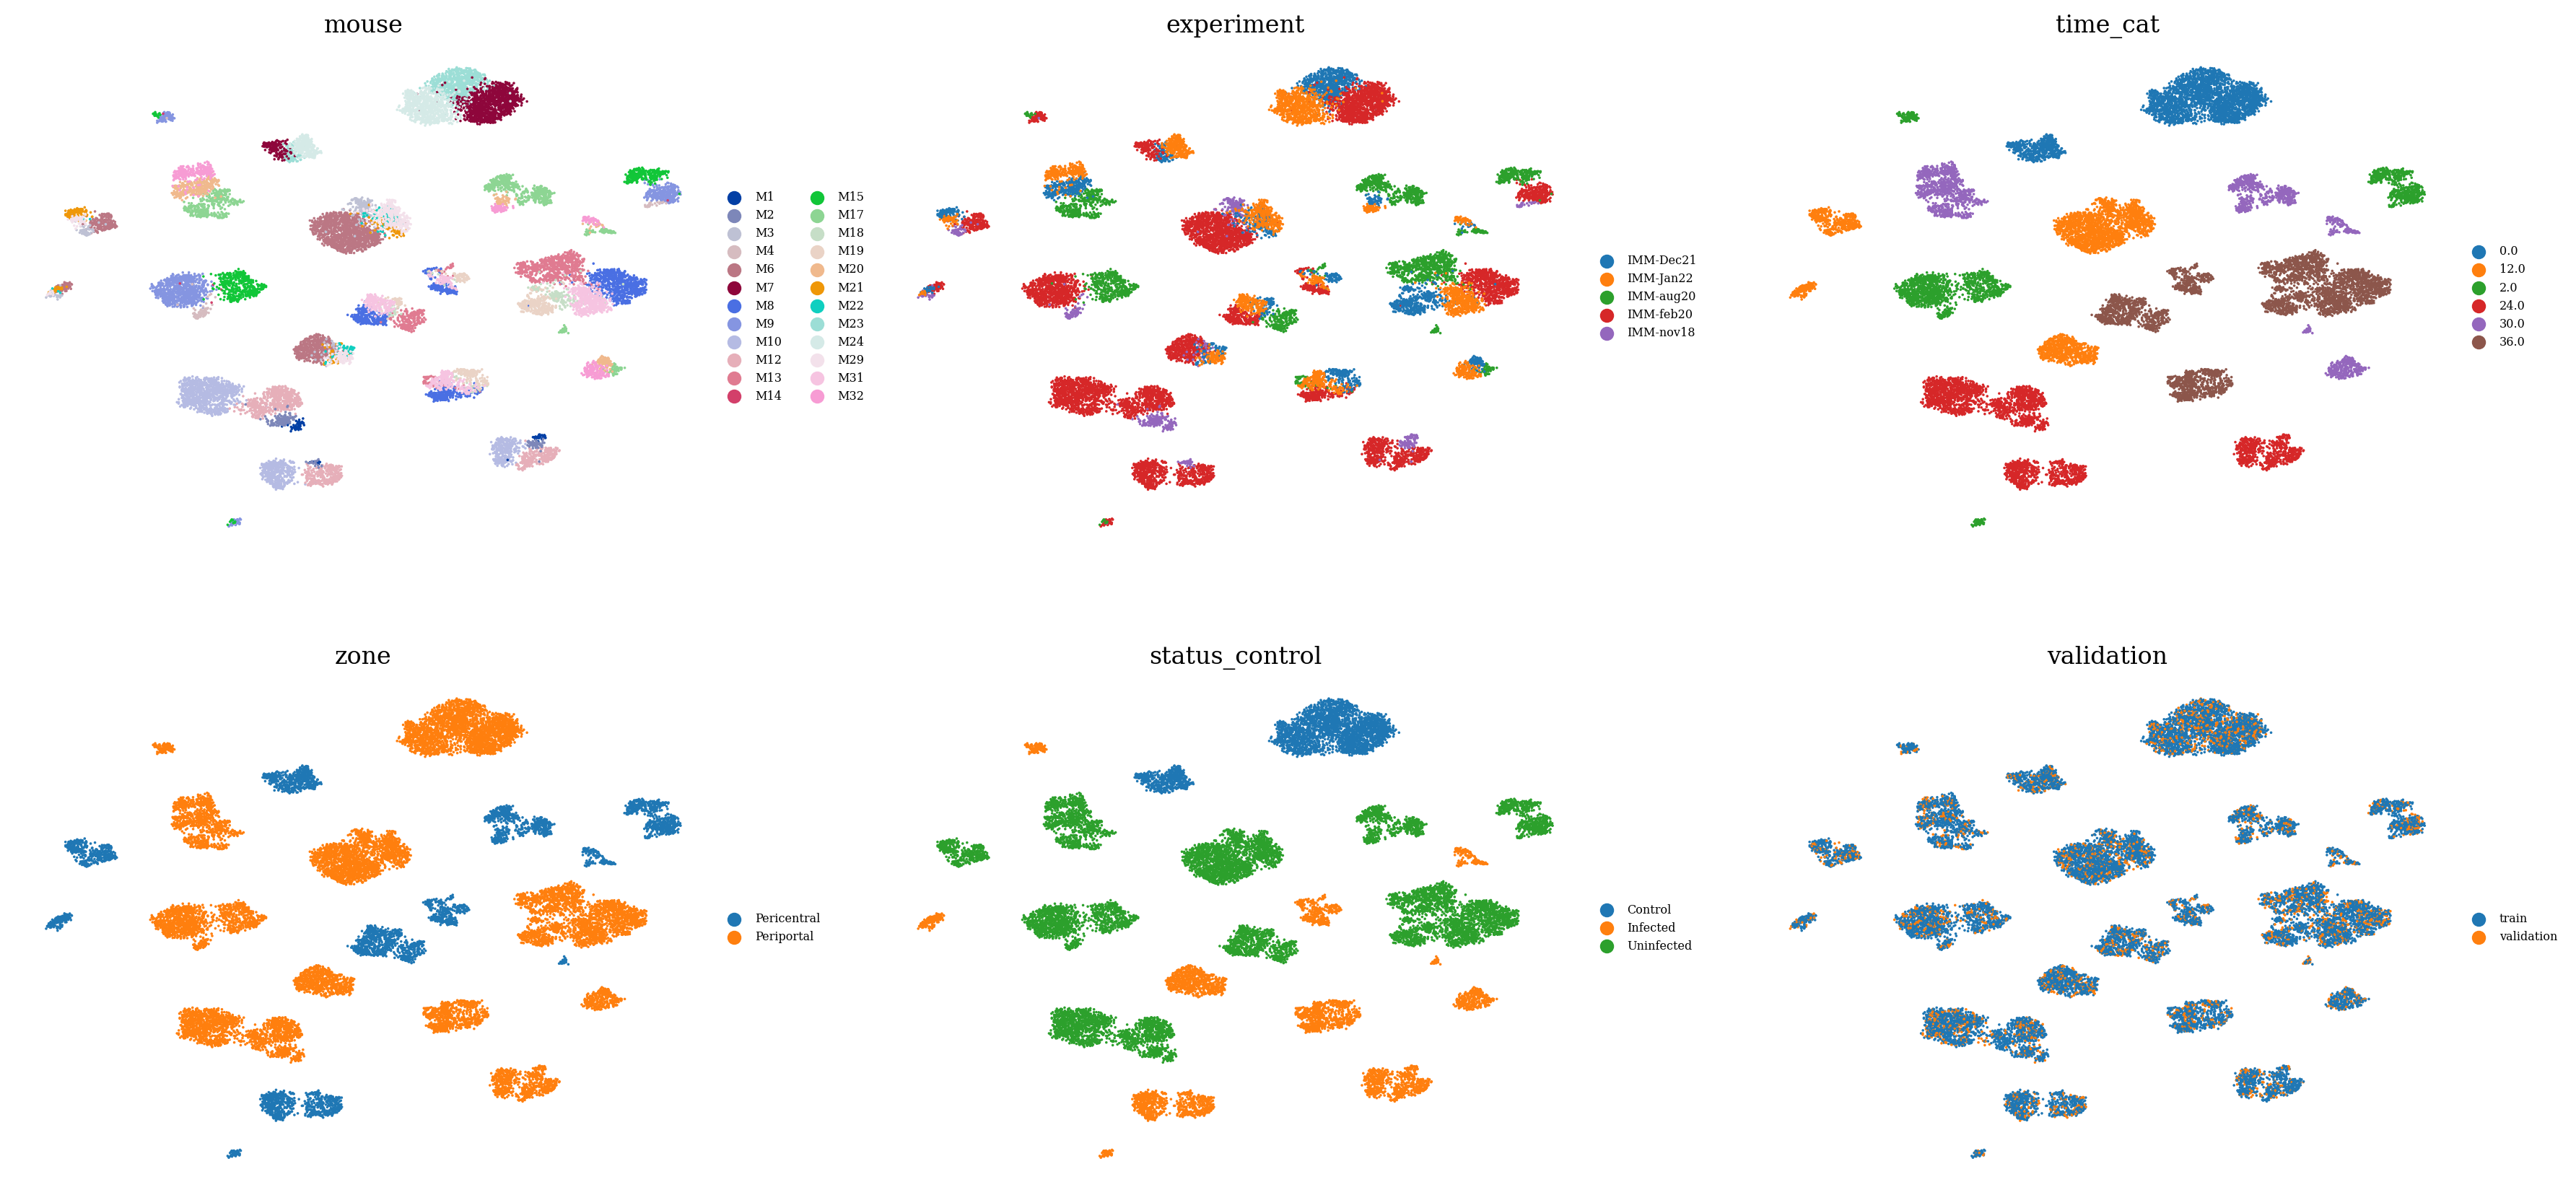

In [14]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

## Preds

In [15]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [16]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


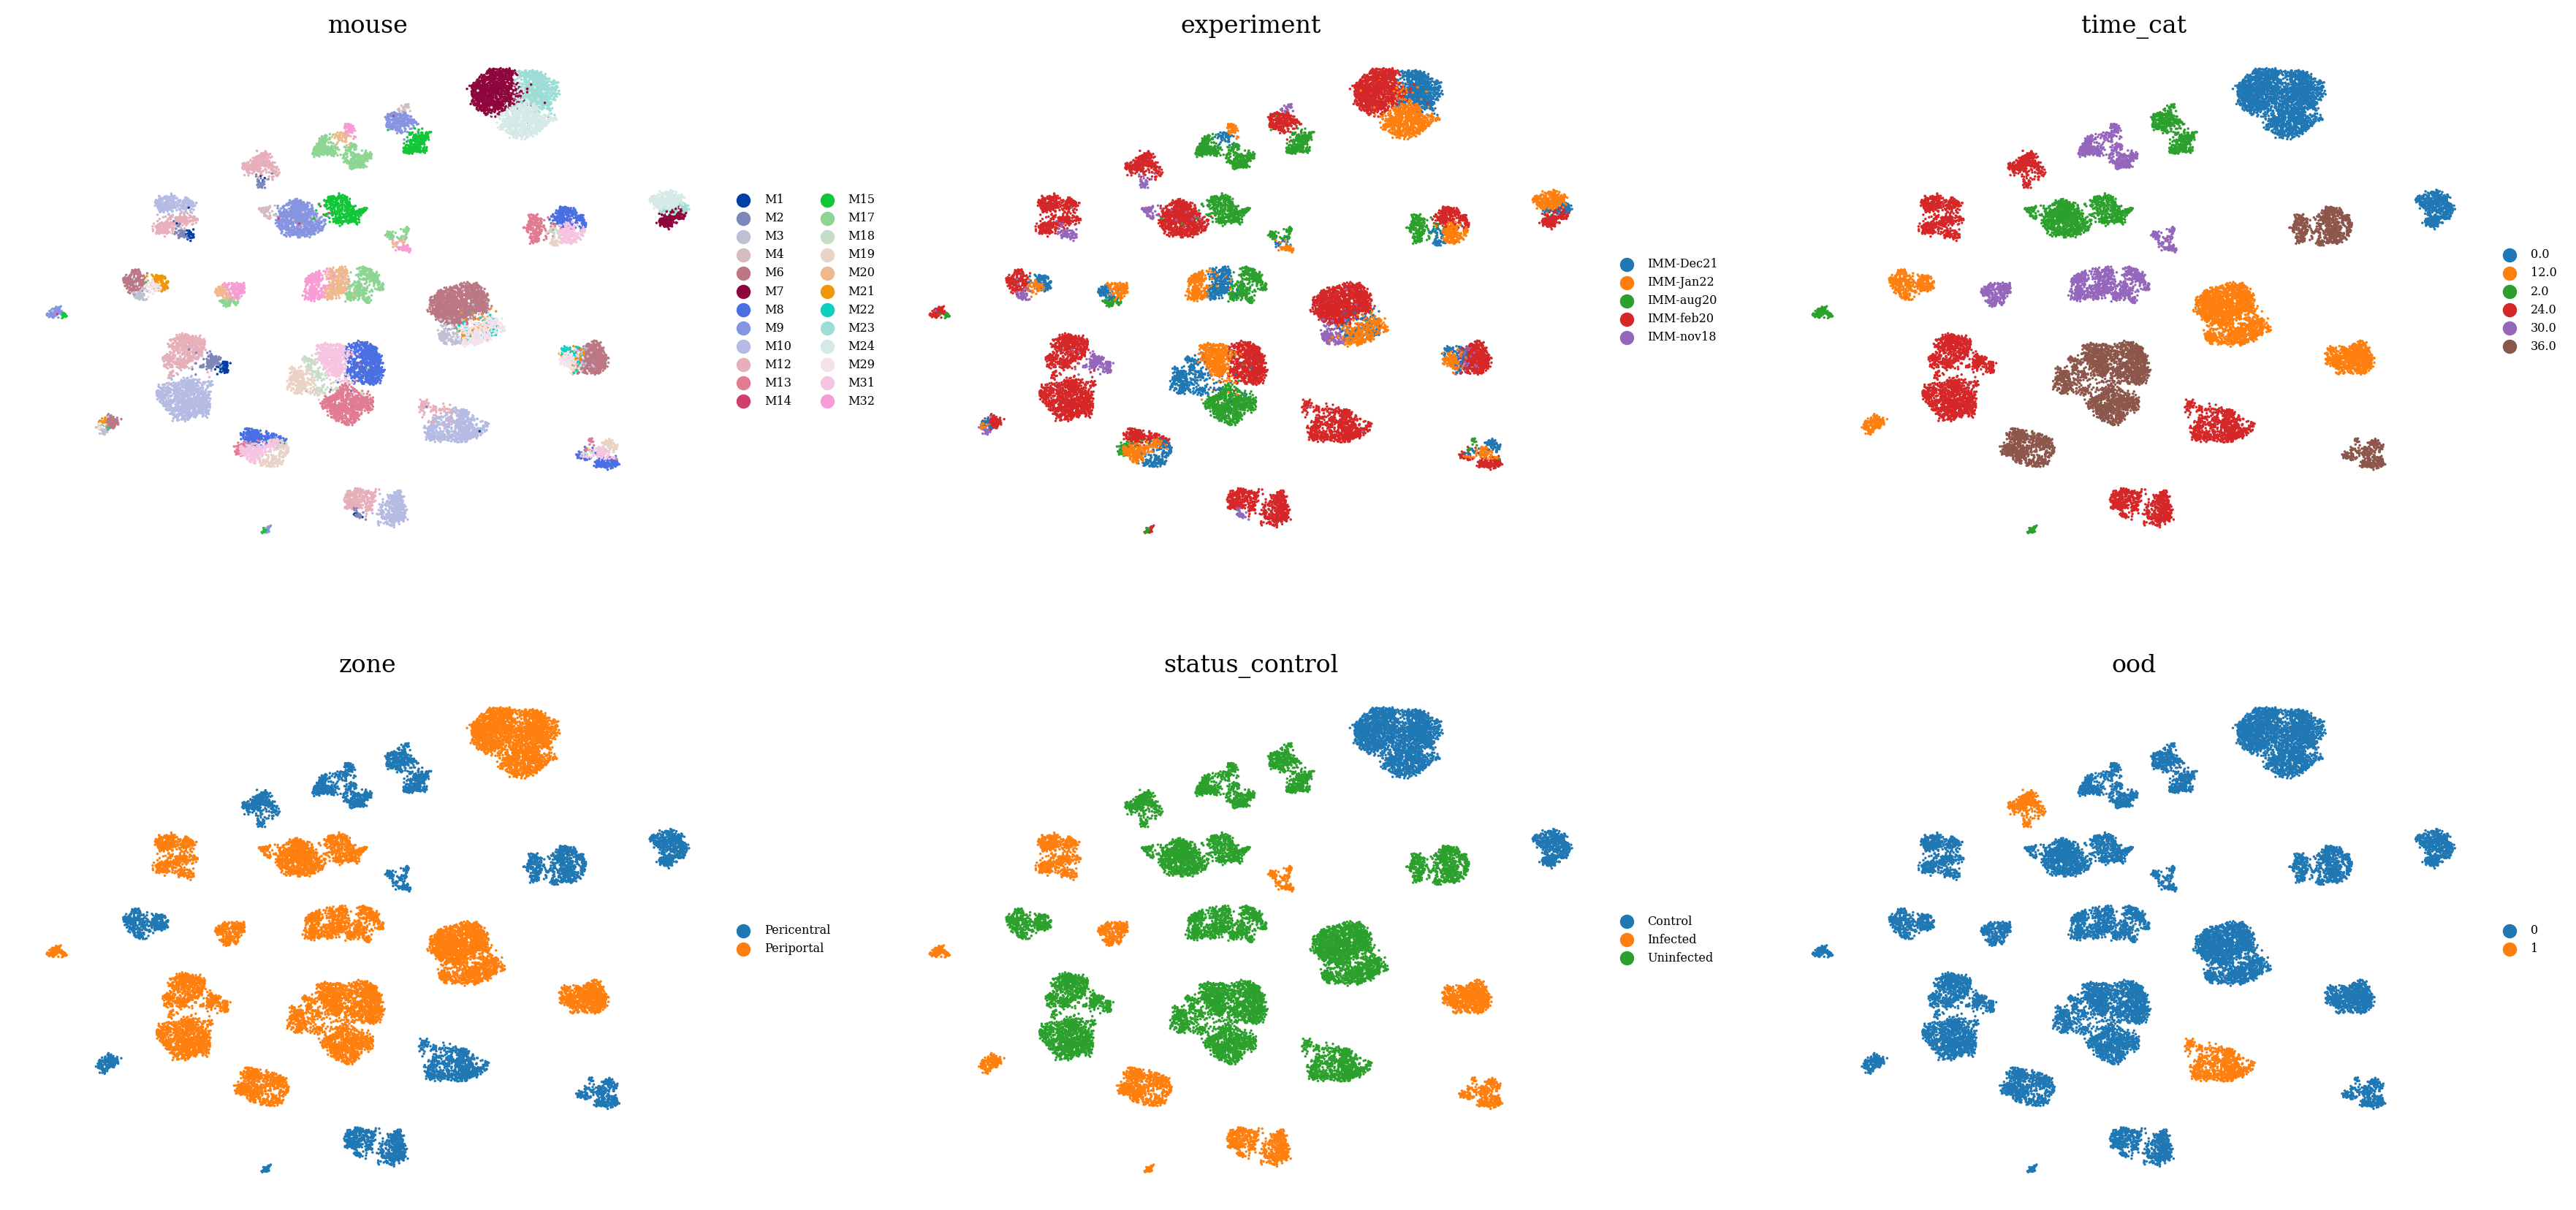

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "ood"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [18]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.4508476355429591


F1 Weighted: 0.45038481083257076



{'accuracy': 1.0,
 'precision_macro': 1.0,
 'recall_macro': 1.0,
 'f1_score_macro': 1.0,
 'precision_micro': 1.0,
 'recall_micro': 1.0,
 'f1_score_micro': 1.0,
 'precision_weighted': 1.0,
 'recall_weighted': 1.0,
 'f1_score_weighted': 1.0,
 'confusion_matrix': array([[1117]])}

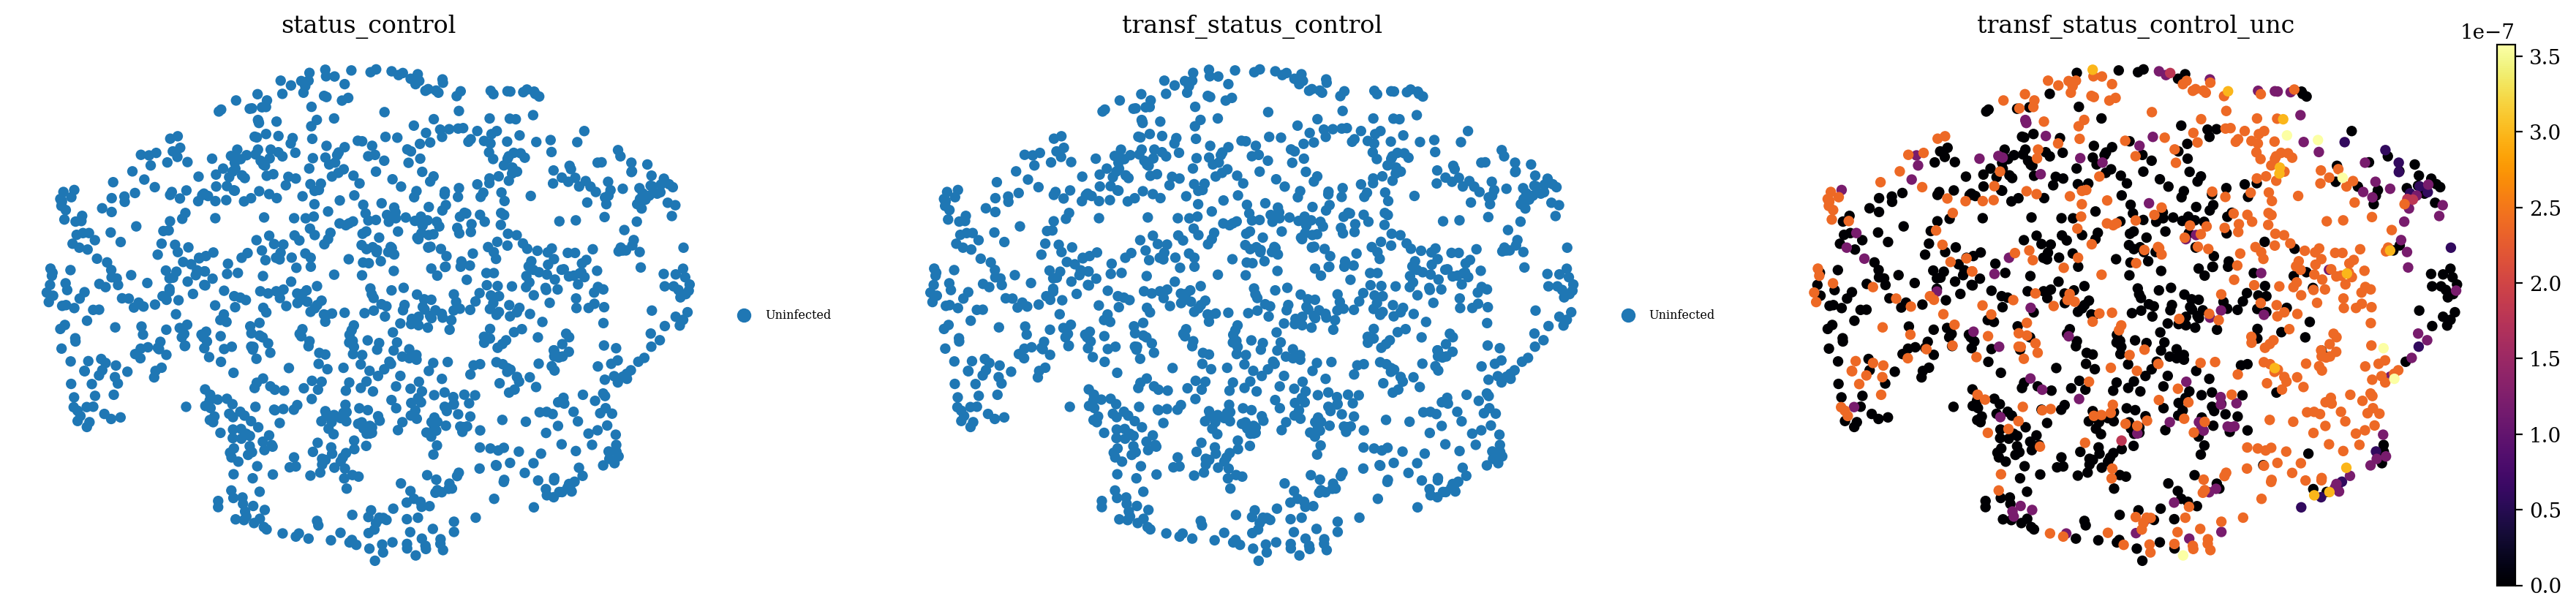

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [20]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata), obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood), obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.4574607673332284


F1 Weighted: 0.4584830029920126



{'accuracy': 0.900626678603402,
 'precision_macro': 0.5,
 'recall_macro': 0.450313339301701,
 'f1_score_macro': 0.47385774846914747,
 'precision_micro': 0.900626678603402,
 'recall_micro': 0.900626678603402,
 'f1_score_micro': 0.900626678603402,
 'precision_weighted': 1.0,
 'recall_weighted': 0.900626678603402,
 'f1_score_weighted': 0.9477154969382949,
 'confusion_matrix': array([[   0,    0],
        [ 111, 1006]])}